### Read me

* This codebook is used once all the videos have been annotated and cleaned up (where json files in the outputs folder and starting with 'ATTN_' are checked and fixed). 

* Calculate features from the output json files using 'features/calculate_features.py'
* outcome files (conf_teams_year.xlsx) are downloaded from sharepoint and stored in data/conf_name


In [1]:
import pandas as pd
import json
import os
from pathlib import Path

In [2]:
attendee_list = pd.read_excel('/Users/eveyhuang/Documents/NICO/gemini_code/data/scialog-all-participants.xlsx')

In [3]:
attendee_list.head()

conf name First Name    Last Name         Role
0   2021ABI      Shiva  Abbbaszadeh       Fellow
1   2021ABI     Samuel     Achilefu  Facilitator
2   2021ABI   Benjamin     Bartelle       Fellow
3   2021ABI  Alexandra      Basford        Guest
4   2021ABI    Carolyn        Bayer       Fellow

### Extract outcome variables from excel sheret

In [ ]:
# Load the CSV file
conf_name = "2021ABI"
csv_file_path = f"/Users/eveyhuang/Documents/NICO/gemini_code/data/{conf_name}/{ABI_teams_2021}.xlsx"
df = pd.read_excel(csv_file_path)

# Process the data
teams_data = []
for index, row in df.iterrows():
    team_id = row['team_id']
    funded_status = 1 if row['funding_status'] == 'funded' else 0
    team_members = row['team_members'].split(', ')
    
    team_info = {
        "team_id": team_id,
        "funded_status": funded_status,
        "members": team_members
    }
    teams_data.append(team_info)

output_file_path = f'/Users/eveyhuang/Documents/NICO/gemini_code/data/{conf_name}/{conf_name}_outcome.json'

# Save the teams_data to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(teams_data, json_file, indent=4)

# Output the result
print(teams_data)

### merge data for each session in output into data folder

In [148]:
import re

def add_times(time1, time2):
    
    # Split the time strings into hours and minutes
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    # Add the hours and minutes separately
    total_hours = hours1 + hours2
    total_minutes = minutes1 + minutes2
    
    # If total minutes are 60 or more, convert to hours
    if total_minutes >= 60:
        total_hours += total_minutes // 60
        total_minutes = total_minutes % 60
    
    #print(f"adding {time1} and {time2} result is {total_hours:02}:{total_minutes:02}")
    # Format the result as "HH:MM"
    return f"{total_hours:02}:{total_minutes:02}"

def normalize_name(full_string):
    """
    Extracts just the name from various formats of name strings.
    
    Args:
        full_string: String containing name and additional information
        
    Returns:
        String containing just the name
    
    """
    if not full_string or full_string.lower() == 'nan':
        return full_string
    
    # Remove common titles
    full_string = re.sub(r'^(Dr\.?|Prof\.?|Professor|Mr\.?|Ms\.?|Mrs\.?)\s+', '', full_string, flags=re.IGNORECASE)
    
    # Handle pipe separator (|) - take everything before the pipe
    if '|' in full_string:
        full_string = full_string.split('|')[0]
    
    # Handle forward slash separator (/) - take everything before the slash
    if '/' in full_string:
        full_string = full_string.split('/')[0]
    
    # Handle underscore separator (_) - take everything before the underscore
    if '_' in full_string:
        full_string = full_string.split('_')[0]
    
    # Handle comma separator (,) - take everything before the comma
    if ',' in full_string:
        full_string = full_string.split(',')[0]
    
    # Remove everything after common separators in parentheses
    if '(' in full_string:
        full_string = full_string.split('(')[0]
    
  
    
    # Clean up any remaining whitespace
    name = full_string.strip()
    
    # Remove periods
    name = name.replace('.', '')
    
    # Handle cases where institution is connected with a hyphen without space
    parts = name.split('-')
    if len(parts) > 1:
        # Check if the part after hyphen contains institutional words
        if any(word in parts[-1].lower() for word in ['university', 'college', 'institute', 'school', 'u of', 'asu', 'mit', 'uga', 'northeastern', 'northwestern', 'stanford', 'harvard', 'yale', 'berkeley', 'ucla', 'ucsd', 'ucsf', 'uci', 'ucd', 'ucsb', 'ucr', 'ucsc', 'caltech', 'uchicago', 'tulane', 'utoledo', 'west', 'wash', 'rice', 'rcsa']):
            name = parts[0].strip()
    
    # Handle cases where institution abbreviation is directly attached (like "Benjamin Bartelle ASU")
    # Split by space and check if last part is an institutional abbreviation
    name_parts = name.split()
    if len(name_parts) > 1:
        last_part = name_parts[-1].upper()
        institutional_abbrevs = ['ASU', 'MIT', 'UGA', 'UCLA', 'MIT', 'UCSD', 'UCSF', 'UCI', 'UCD', 'UCSB', 'UCR', 'UCSC', 'NORTHEASTERN', 'NORTHWESTERN', 'STANFORD', 'HARVARD', 'YALE', 'BERKELEY', 'CALTECH', 'UCHICAGO', 'TULANE', 'UTOLEDO', 'WEST', 'WASH', 'RICE', 'RCSA']
        if last_part in institutional_abbrevs:
            name = ' '.join(name_parts[:-1])
    
    return name.strip()

def split_name(name):
    """Split a name into first and last (handles middle names by joining all but last as first)."""
    parts = name.strip().split()
    if len(parts) == 1:
        return parts[0], ""
    return " ".join(parts[:-1]), parts[-1]

from difflib import SequenceMatcher


def find_matching_name(name, correct_names, last_name_threshold=0.7, first_name_threshold=0.3):
    """
    Fuzzy match names, requiring a strong match on last name and a looser match on first name.
    """
    name_first, name_last = split_name(name.lower())
    best_match = None
    best_score = 0

    for correct_name in correct_names:
        correct_first, correct_last = split_name(correct_name.lower())
        # Compare last names
        last_ratio = SequenceMatcher(None, name_last, correct_last).ratio()
        if last_ratio >= last_name_threshold:
            # Compare first names
            first_ratio = SequenceMatcher(None, name_first, correct_first).ratio()
            # Use average or weighted score for ranking
            score = (last_ratio + first_ratio) / 2
            if first_ratio >= first_name_threshold and score > best_score:
                best_score = score
                best_match = correct_name

    if best_match:
        # print(f"matched {name} to {best_match}")
        return best_match, best_score
    # print(f"no match found for {name}")
    return None, best_score

# Example usage with more complex cases:
def find_and_correct_name(name, correct_names, threshold=0.7):
    """
    Wrapper function that provides more detailed output about name matching.
    
    Args:
        name: String containing the potentially misspelled name
        correct_names: List of correctly spelled names
        threshold: Float between 0 and 1, minimum similarity ratio to consider a match
        
    Returns:
        Dictionary containing matching information
    """
    name = normalize_name(name)
    match, ratio = find_matching_name(name, correct_names, threshold)
    result = {
        "input_name": name,
        "matched_name": match,
        "similarity": round(ratio, 3),
        "is_match": ratio >= threshold
    }
    
    return result

In [202]:
# CHANGE conf name here 
conf_name = '2021NES'

conference_dir = f'data/{conf_name}'
session_dir = f'data/{conf_name}/session_data'
gemini_output_dir = f'outputs/{conf_name}'
output_dir = f'data/{conf_name}/session_data'

In [203]:
# get roles of attendees
name_roles = dict()

conference_attendees = attendee_list[attendee_list['conf name'] == conf_name]

for _, attendee in conference_attendees.iterrows():
    first_name = attendee['First Name']
    last_name = attendee['Last Name']
    role = attendee['Role']
    if not pd.isna(last_name):
        full_name = f"{first_name} {last_name}"
    else:
        full_name = first_name
    name_roles[full_name] = role

print(name_roles)

{'Jennifer Wilcox Wilcox': 'Keynote Speaker', 'Kandis Leslie Abdul-Aziz ': 'Scialog Fellow', 'Ashleigh Baber': 'Scialog Fellow', 'Praveen Bollini': 'Scialog Fellow', 'William J. Bowman': 'Scialog Fellow', 'Nanette  Boyle': 'Scialog Fellow', 'Fikile Brushett': 'Scialog Fellow', 'Rob Coridan': 'Scialog Fellow', 'Pratik Dholabhai': 'Scialog Fellow', 'Greeshma Gadikota': 'Scialog Fellow', 'Betar Gallant': 'Scialog Fellow', 'Rebecca Gieseking': 'Scialog Fellow', 'Matt Green': 'Scialog Fellow', 'Burcu  Gurkan': 'Scialog Fellow', 'Kelsey B.  Hatzell': 'Scialog Fellow', 'Marta  Hatzell': 'Scialog Fellow', 'Andrea  Hicks ': 'Scialog Fellow', 'Caleb Hill': 'Scialog Fellow', 'Adam Holewinski': 'Scialog Fellow', 'Katherine Hornbostel': 'Scialog Fellow', 'Shu Hu': 'Scialog Fellow', 'Jimmy Jiang': 'Scialog Fellow', 'Feng Jiao': 'Scialog Fellow', 'Katie Knowles': 'Scialog Fellow', 'David  Kwabi': 'Scialog Fellow', 'Simona Liguori': 'Scialog Fellow', 'Feng Lin': 'Scialog Fellow', 'Zhou Lin': 'Scialog 

In [187]:
# match names in teams outcome data with attendee list
with open(f'data/{conf_name}/{conf_name}_outcome.json') as f:
    teams_data = json.load(f)

unmatched_names = set()
for team in teams_data:
    members = team['members']
    for name in members:
        if name not in name_roles.keys():
            match_name_result = find_and_correct_name(name, name_roles.keys())
            if match_name_result['is_match']:
                # change the name in temas_data to the matched name
                print(f"matched {name} to {match_name_result['matched_name']}")
                team['members'][members.index(name)] = match_name_result['matched_name']
            else:
                unmatched_names.add(name)
with open(f'data/{conf_name}/{conf_name}_outcome.json', 'w') as f:
    json.dump(teams_data, f, indent=4)
print(f"unmatched names: {unmatched_names}")

matched Tianbiao Leo Liu to Leo Liu
matched Tianbiao Leo Liu to Leo Liu
unmatched names: {'Betar Gallant', 'Venkat Viswanathan'}


In [ ]:
# functions to normalize and match names
import os
import json
from collections import defaultdict


def normalize_keys(entry):
    normalized = {}
    for key, value in entry.items():
        normalized[key.replace(' ', '_')] = value
    return normalized

def convert_time_to_seconds(time_str):
    """
    Convert time string in format "MM:SS" or "M:SS" to total seconds.
    Also handles numeric strings that are already in seconds.
    """
    if isinstance(time_str, (int, float)):
        return int(time_str)
    
    time_str = str(time_str).strip()
    
    # If it's already a number, return it
    try:
        return int(time_str)
    except ValueError:
        pass
    
    # Handle time format like "3:59" or "03:59"
    if ':' in time_str:
        parts = time_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:
            # Handle HH:MM:SS format
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 3600 + minutes * 60 + seconds
    
    # If we can't parse it, return 0
    print(f"Warning: Could not parse time string '{time_str}', using 0 seconds")
    return 0
# merge data from output folders 
def merge_json_files(directory):
    merged_data = []
    all_speakers = []
    speaking_length = 0
    last_end_time = "00:00"
    unmatch_names = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.startswith("all_gm_v4") and file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    for entry in data:
                        entry = normalize_keys(entry)
                        
                        
                        match_name_result = find_and_correct_name(entry['speaker'], name_roles.keys())
                        if match_name_result['is_match']:
                            matched_name = match_name_result['matched_name']
                            # print(f"matched {entry['speaker']} to {match_name_result['matched_name']}")
                            entry['speaker'] = matched_name
                            entry['role'] = name_roles[matched_name]
                        else:
                            # print(f"no match found for {entry['speaker']}")
                            unmatch_names.add(entry['speaker'])
                            entry['speaker'] = match_name_result['input_name']
                            entry['role'] = 'unknown'
                            
                        all_speakers.append(entry['speaker'])
                        if type(entry['speaking_duration']) == str:
                            entry['speaking_duration'] = convert_time_to_seconds(entry['speaking_duration'])
                        speaking_length += int(entry['speaking_duration'])
                        entry['start_time'] = add_times(entry['start_time'], last_end_time)
                        entry['end_time'] = add_times(entry['end_time'], last_end_time)
                            
                        merged_data.append(entry)
                    try:    
                        last_end_time = max(entry['end_time'] for entry in data)
                    except ValueError:
                        print(f"Error processing file {file_path}: {data}")
                        continue
                    
    unique_speakers = set(all_speakers)   
    print(f"{directory}, unmatched names: {unmatch_names}")             
    return merged_data, list(unique_speakers), speaking_length




In [ ]:
# Merge data from individual videos into sessions

if not os.path.exists(output_dir):
     os.makedirs(output_dir)

for folder in os.listdir(gemini_output_dir):
     if folder.startswith("output"):
          folder_path = os.path.join(gemini_output_dir, folder)
          try:
               merged_data, all_speaker, speaking_length = merge_json_files(folder_path)
               result = {
                "all_speakers": list(set(all_speaker)),
                "total_speaking_length": speaking_length,
                "all_data": merged_data,     
               }
               
               output_file_name = folder.replace("output_", "").strip()
               output_file_path = os.path.join(output_dir, f"{output_file_name}.json")
               
               with open(output_file_path, 'w') as f:
                    json.dump(result, f, indent=4)
          except Exception as e:
               print(f"Error processing {folder_path}: {e}")
               continue
          
          

outputs/2022MND/output_2022_04_07_MND_S5, unmatched names: {'Richard Wiener', 'Andrew Feig (RCSA (he/him))', 'Unidentified Speaker', 'Andrew Feig'}
outputs/2022MND/output_2022_04_07_MND_S2, unmatched names: {'Sandra Laney', 'Alexandra Basford'}
outputs/2022MND/output_2022_04_07_MND_S3, unmatched names: {'Richard Wiener', 'Jodi Lilley', 'Andrew Feig'}
outputs/2022MND/output_2022_04_07_MND_S4, unmatched names: {'Okay.', 'Andrew Feig (RCSA (he/him)', 'Andrew Feig'}
outputs/2022MND/output_2022_04_08_MND_S6, unmatched names: set()
outputs/2022MND/output_2022_04_08_MND_S1, unmatched names: {'Richard Wiener', 'Silvia Ronco'}
outputs/2022MND/output_2022_04_08_MND_S8, unmatched names: {'Richard Wiener'}
outputs/2022MND/output_2022_04_08_MND_S9, unmatched names: {'Richard Wiener', 'Andrew Feig'}
outputs/2022MND/output_2022_04_08_MND_S7, unmatched names: {'Rima kaddourah daouk', 'Unidentified Speaker', 'Andrew Feig'}
outputs/2022MND/output_2022_04_08_MND_S12, unmatched names: {'Jaeyun (Jae) Sung'

In [180]:
# Read outcome.json to get team information (match each person to their team and funding status)

outcome_file = os.path.join(conference_dir, f'{conf_name}_outcome.json')
with open(outcome_file, 'r') as f:
    outcome_data = json.load(f)

# Create a mapping of normalized full names to their team IDs
name_to_teams = defaultdict(list)  # Changed to defaultdict to store multiple teams per person
for proposal in outcome_data:
    team_id = proposal.get('team_id', '')
    member_names = proposal.get('members', [])
    funded_status = proposal.get('funded_status', None)
    
    if member_names:
        for name in member_names:
            if name in name_roles.keys():
                role = name_roles[name]
            else:
                role = 'unknown'
            name_to_teams[name].append({
                'team_id': team_id,
                'full_name': name,
                'role': role,
                'funded_status': funded_status
            })


with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'w') as f:
    data = json.dump(name_to_teams, f, indent=4)

print(data)

None


In [204]:
## Create session outcomes data

from collections import defaultdict, OrderedDict

with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'r') as f:
    name_to_teams = json.load(f)
    
all_sessions = OrderedDict()

print(f"searaching in conference_dir: {session_dir} for {conf_name}")
# Process each JSON file in the directory
for filename in os.listdir(session_dir):
    if filename.endswith('.json') and filename != f'{conf_name}_outcome.json':
        file_path = os.path.join(session_dir, filename)
        
        
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
            except:
                print(f"Error loading {filename}")
                continue
        
        if "all_speakers" in data:
            # Create an ordered dictionary for this session
            session_data = OrderedDict()
            session_data["all_speakers"] = list(set(data["all_speakers"]))
            session_data["facilitators"] = []
            for name in session_data["all_speakers"]:
                if name in name_roles.keys():
                    role = name_roles[name]
                    if 'facilitator' in role.lower():
                        session_data["facilitators"].append(name)
            # Find teams present in this session
            teams_in_session = defaultdict(list)
            for name in data["all_speakers"]:
                
                if name in name_to_teams:
                    # Add person to all their teams
                    for team_info in name_to_teams[name]:
                        teams_in_session[team_info['team_id']].append({
                            'name': team_info['full_name'],
                            'funded_status': team_info['funded_status'],
                            'team_id': team_info['team_id']
                        })
                
            
            # Add team information to session data, only including teams with at least 2 members
            if teams_in_session:
                session_data["teams"] = OrderedDict()
                for team_id, team_info in teams_in_session.items():
                    if len(team_info) >= 2:  # Only include teams with 2 or more members
                        session_data["teams"][team_id] = {
                            "members": [member['name'] for member in team_info],
                            "funded_status": team_info[0]['funded_status'] if team_info else None
                        }
            
            # Add to the main dictionary using the filename (without .json) as the key
            session_name = os.path.splitext(filename)[0]
            all_sessions[session_name] = session_data
            
            
        else:
            print(f"Skipping {filename} because it doesn't contain 'all_speakers'")


seen_names = set()
for session_data in all_sessions.values():
    if "all_speakers" in session_data:
        seen_names.update(session_data["all_speakers"])

# Step 2: Find unmatched names
unmatched_names = set(name_to_teams.keys()) - seen_names

# Step 3: Print them
print("*** Names in outcome.json not identified in any session (could be due to different spellings or typos):")
for name in unmatched_names:
    print(name)
    
all_sessions['missing_names'] = list(unmatched_names)
# Step 2: Find people not in any team
not_in_any_team = seen_names - set(name_to_teams.keys())

# Step 3: Print them
print("*** People in sessions who never joined any team:")
for name in not_in_any_team:
    print(name)

all_sessions['people_not_in_any_team'] = list(set(not_in_any_team))
with open(f'data/{conf_name}/{conf_name}_session_outcomes.json', 'w') as f:
    data = json.dump(all_sessions, f, indent=4)


searaching in conference_dir: data/2021NES/session_data for 2021NES
*** Names in outcome.json not identified in any session (could be due to different spellings or typos):
*** People in sessions who never joined any team:
Caleb Hill
Andrew Feig
Kandis Leslie Abdul-Aziz 
Lena Petrova
Richard Wiener
BotB1
Alissa  Park
Chloe Davis
Lauren Wagner
Jesús Velázquez
Silvia Ronco
George Shields
Emily Carter
BotB6
Burcu  Gurkan
Evan Michelson
Marcel Schreier - UW-Sc Madison
Sarbajit Banerjee
Fikile Brushett
Isabella Gee
Rodriguez
Roger Aines
MARCEL SCHREIER - UW Madison
Joan Brennecke
Ellen Stechel
Jeffrey Long
Patricia Barron
Jordi Cabana
Ellen B Stechel Arizona State University
Child
BotB1 [Unidentified female speaker]
Aleksandra Vojvodic
Aris Thorne
Banerjee Sarbajit
Zhou Lin UMass quantum chemist
David Chen
Marcel Schreier - UWisc Madison
Rob Coridan
Gayle Jackson
Praveen Bollini
Marcel Schreier - UW Madison
Kenji Tanaka
Christopher Jones
Pete Reiners
Unknown speaker
Jarad Mason


### Merge all features and outcomes

In [35]:


"""
Creates a DataFrame called 'all_data' from featurized data across all conferences.

Returns:
    pd.DataFrame: DataFrame with conference, session, and all feature columns
"""
conferences = ['2020NES', '2021ABI', '2021MND', '2021MZT', '2021SLU', '2021CMC', '2021NES', '2022MND']
all_data = []

for conf_name in conferences:
    # Path to featurized data directory for this conference
    featurized_dir = f'data/{conf_name}/featurized data'
    
    # Check if directory exists
    if not os.path.exists(featurized_dir):
        print(f"Warning: Directory {featurized_dir} does not exist, skipping...")
        continue
    
    # Get all JSON files in the featurized data directory
    json_files = [f for f in os.listdir(featurized_dir) if f.endswith('.json')]
    
    for json_file in json_files:
        # Create session name (filename without .json extension)
        session_name = json_file.replace('.json', '').replace('features_', '')
        
        # Load the JSON data
        json_path = os.path.join(featurized_dir, json_file)
        try:
            with open(json_path, 'r') as f:
                features = json.load(f)
            
            # Create row data
            row_data = {
                'conference': conf_name,
                'session': session_name
            }
            # Exclude multiple fields
            exclude_fields = []
            filtered_features = {k: v for k, v in features.items() if k not in exclude_fields}
            row_data.update(filtered_features)
            # Add all feature key-value pairs to the row
            #row_data.update(features)
            
            all_data.append(row_data)
            
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            continue
    
    # Create DataFrame
    all_data_df = pd.DataFrame(all_data)
    
    print(f"Created DataFrame with {len(all_data_df)} rows and {len(all_data_df.columns)} columns")
    print(f"Columns: {list(all_data_df.columns)}")
    
    print(all_data_df.head())

# Usage:
# all_data = create_all_data_dataframe()

Created DataFrame with 16 rows and 34 columns
Columns: ['conference', 'session', 'num_members', 'meeting_length', 'num_interruption', 'percent_time_screenshare', 'num_propose_new_idea', 'num_develop_idea', 'num_ask_question', 'num_signal_expertise', 'num_identify_gap', 'num_acknowledge_contribution', 'num_supportive_response', 'num_critical_response', 'num_offer_feedback', 'num_summarize_conversation', 'num_express_humor', 'num_encourage_participation', 'num_process_management', 'num_assign_task', 'num_clarify_goal', 'num_confirm_decision', 'num_people_ask_question', 'num_people_identify_gap', 'num_people_supportive_response', 'num_people_critical_response', 'num_people_offer_feedback', 'num_people_summarize_conversation', 'num_people_express_humor', 'num_people_encourage_participation', 'num_people_process_management', 'num_people_assign_task', 'num_people_clarify_goal', 'num_people_confirm_decision']
  conference             session  num_members  meeting_length  \
0    2020NES   2020

In [36]:

# Prepare lists to store the new columns
num_teams_list = []
num_funded_teams_list = []

for idx, row in all_data_df.iterrows():
    conf = row['conference']
    session = row['session']
    session_outcomes_path = f'data/{conf}/{conf}_session_outcomes.json'
    
    # Default values
    num_teams = 0
    num_funded_teams = 0
    
    try:
        with open(session_outcomes_path, 'r') as f:
            session_outcomes = json.load(f)
        
        session_data = session_outcomes.get(session, {})
        teams = session_data.get('teams', {})
        num_teams = len(teams)
        num_funded_teams = sum(1 for t in teams.values() if t.get('funded_status') == 1)
    except Exception as e:
        print(f"Error processing {conf} {session}: {e}")
    
    num_teams_list.append(num_teams)
    num_funded_teams_list.append(num_funded_teams)

# Add the new columns to the DataFrame
all_data_df['num_teams'] = num_teams_list
all_data_df['num_funded_teams'] = num_funded_teams_list


print(all_data_df[['conference', 'session', 'num_teams', 'num_funded_teams']].head())

  conference             session  num_teams  num_funded_teams
0    2020NES   2020_11_05_NES_S6          2                 0
1    2020NES   2020_11_06_NES_S1          2                 1
2    2020NES  2020_11_06_NES_S10          0                 0
3    2020NES   2020_11_06_NES_S7          2                 0
4    2020NES   2020_11_05_NES_S1          1                 0


In [37]:
print(all_data_df[all_data_df['conference'] == '2021MND'][['session', 'num_teams', 'num_funded_teams']])

               session  num_teams  num_funded_teams
40   2021_04_23_MND_S7          1                 0
41   2021_04_22_MND_S2          0                 0
42   2021_04_22_MND_S3          1                 0
43  2021_04_23_MND_S16          2                 0
44   2021_04_23_MND_S6          2                 0
45   2021_04_22_MND_S4          1                 1
46   2021_04_23_MND_S1          2                 0
47  2021_04_23_MND_S11          3                 1
48   2021_04_22_MND_S8          1                 0
49  2021_04_23_MND_S10          0                 0
50   2021_04_22_MND_S5          0                 0
51   2021_04_22_MND_S6          0                 0
52  2021_04_23_MND_S13          0                 0
53   2021_04_23_MND_S3          2                 0
54   2021_04_23_MND_S2          2                 1
55  2021_04_23_MND_S12          1                 0
56   2021_04_22_MND_S7          2                 0
57  2021_04_23_MND_S15          0                 0
58   2021_04

In [ ]:
# Create binary versions

all_data_df['has_teams'] = (all_data_df['num_teams'] > 0).astype(int)
all_data_df['has_funded_teams'] = (all_data_df['num_funded_teams'] > 0).astype(int)



In [54]:
all_data_df.to_excel('data/all_data_df.xlsx', index=False)

### summary statistics

In [19]:
all_data_df=pd.read_excel('data/all_data_df.xlsx')


SUMMARY STATISTICS BY CONFERENCE

NUM TEAMS:
----------------------------------------
            count  mean   std  min  max
conference                             
2020NES        16  1.94  0.85    0    3
2021ABI        24  1.38  1.06    0    3
2021CMC        21  1.43  0.98    0    3
2021MND        24  1.04  0.95    0    3
2021MZT        15  1.47  2.03    0    8
2021NES        18  1.56  1.25    0    4
2021SLU        20  1.45  1.00    0    3
2022MND        18  1.00  0.97    0    3

NUM FUNDED TEAMS:
----------------------------------------
            count  mean   std  min  max
conference                             
2020NES        16  0.62  0.72    0    2
2021ABI        24  0.38  0.58    0    2
2021CMC        21  0.57  0.75    0    2
2021MND        24  0.21  0.41    0    1
2021MZT        15  0.73  1.39    0    5
2021NES        18  0.56  0.62    0    2
2021SLU        20  0.55  0.60    0    2
2022MND        18  0.33  0.49    0    1

MEETING LENGTH:
------------------------------------

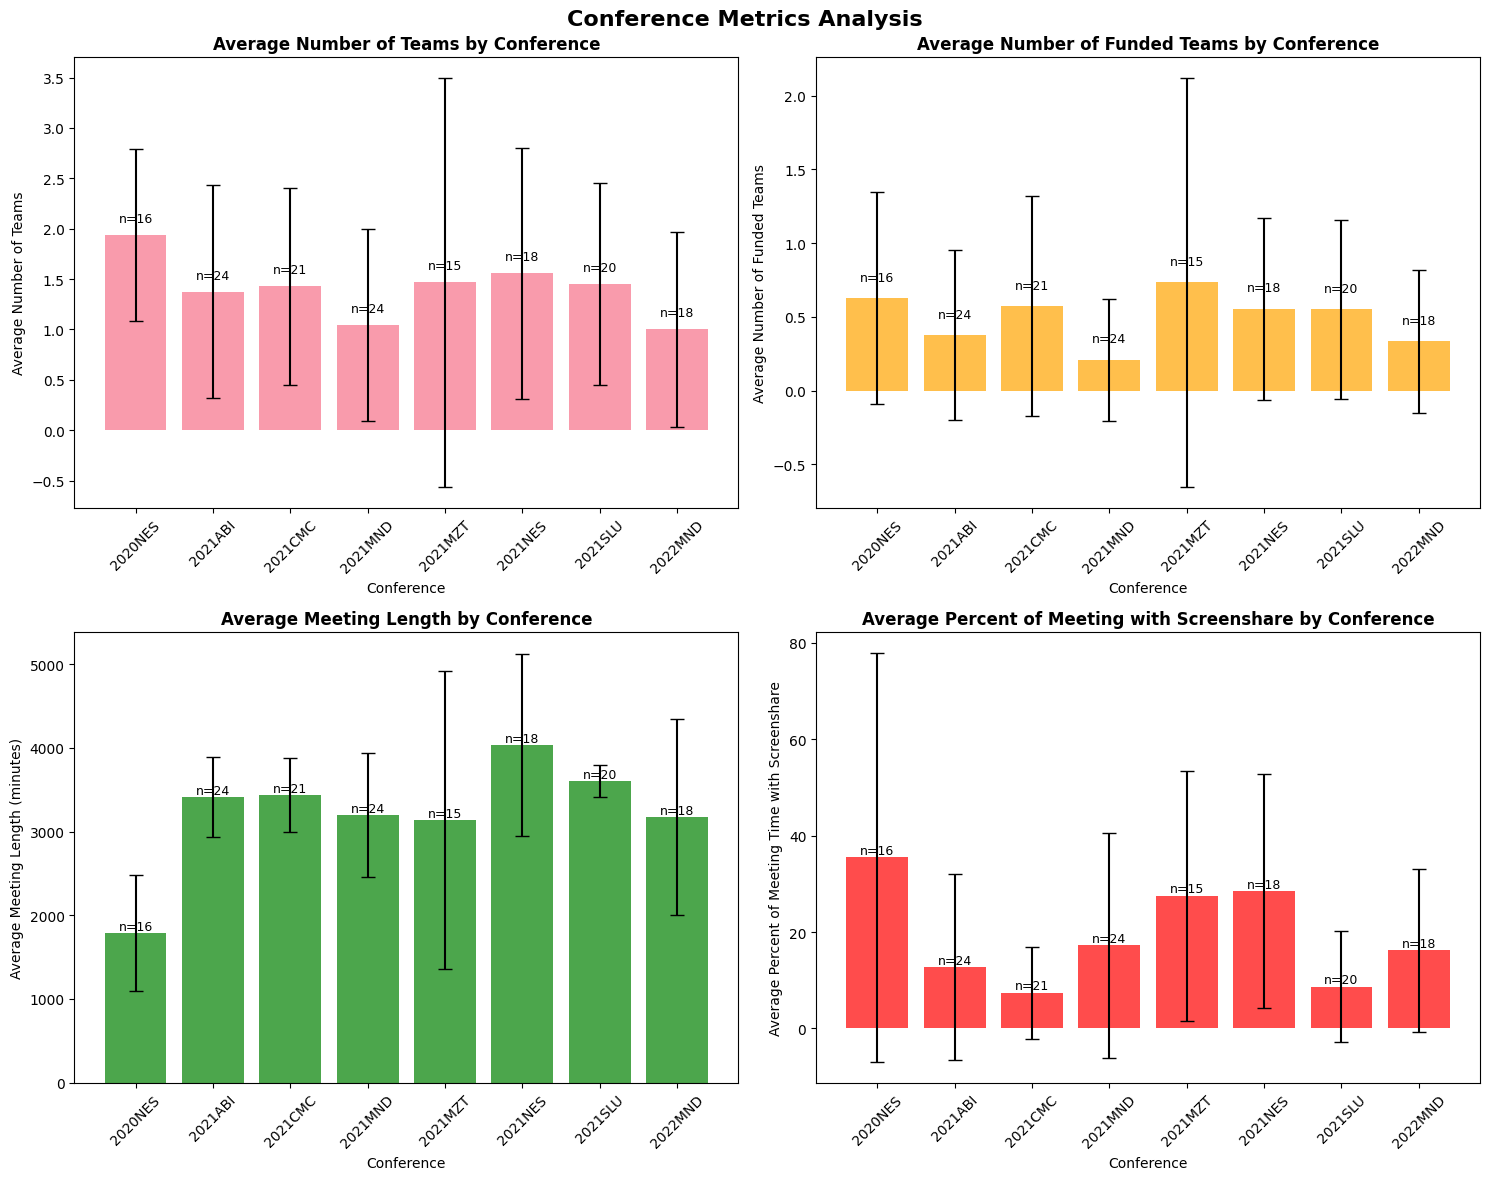

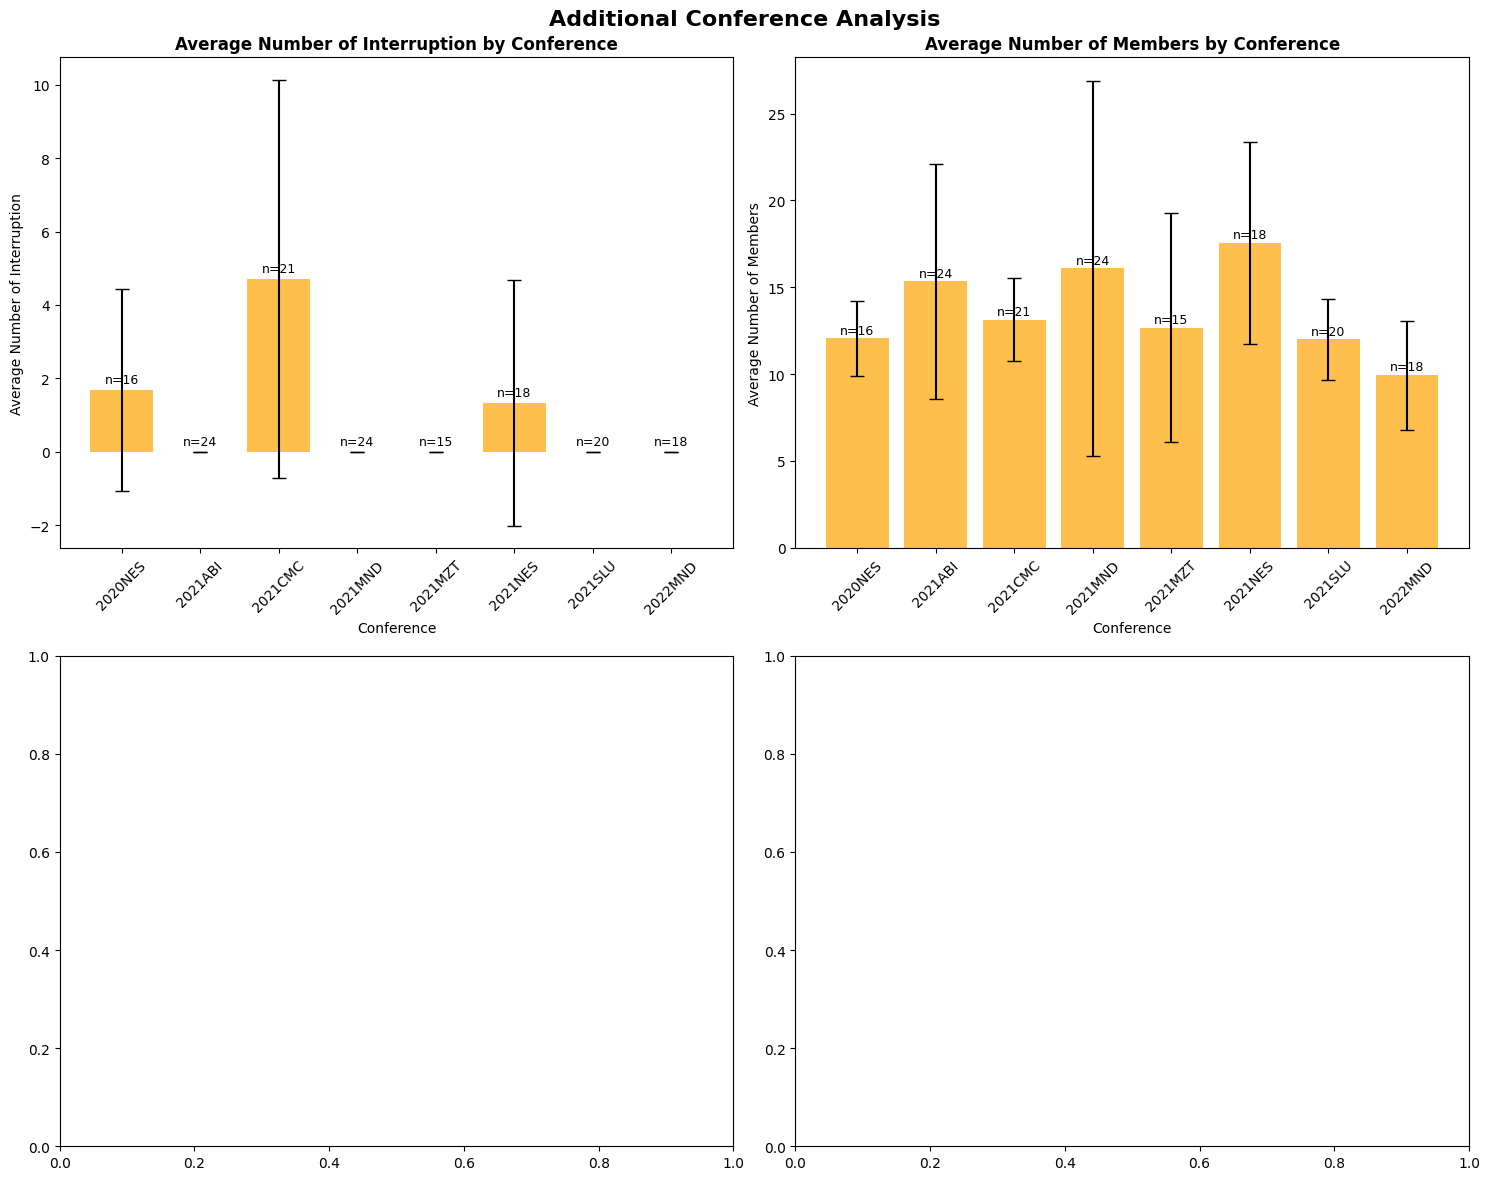

In [134]:
import seaborn as sns
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


def create_conference_visualizations(df):
    """Create visualizations for conference metrics"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Conference Metrics Analysis', fontsize=16, fontweight='bold')
    
    # 1. Number of Teams by Conference
    ax1 = axes[0, 0]
    if 'num_teams' in df.columns and 'conference' in df.columns:
        team_counts = df.groupby('conference')['num_teams'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax1.bar(team_counts['conference'], team_counts['mean'], 
                      yerr=team_counts['std'], capsize=5, alpha=0.7)
        ax1.set_title('Average Number of Teams by Conference', fontweight='bold')
        ax1.set_xlabel('Conference')
        ax1.set_ylabel('Average Number of Teams')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, team_counts['count'])):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax1.text(0.5, 0.5, 'num_teams or conference column not found', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Number of Teams by Conference')
    
    # 2. Number of Funded Teams by Conference
    ax2 = axes[0, 1]
    if 'num_funded_teams' in df.columns and 'conference' in df.columns:
        funded_counts = df.groupby('conference')['num_funded_teams'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax2.bar(funded_counts['conference'], funded_counts['mean'], 
                      yerr=funded_counts['std'], capsize=5, alpha=0.7, color='orange')
        ax2.set_title('Average Number of Funded Teams by Conference', fontweight='bold')
        ax2.set_xlabel('Conference')
        ax2.set_ylabel('Average Number of Funded Teams')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, funded_counts['count'])):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'num_funded_teams or conference column not found', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Number of Funded Teams by Conference')
    
    # 3. Meeting Length by Conference
    ax3 = axes[1, 0]
    if 'meeting_length' in df.columns and 'conference' in df.columns:
        # Convert meeting_length to numeric if it's not already
        df['meeting_length_numeric'] = pd.to_numeric(df['meeting_length'], errors='coerce')
        
        meeting_stats = df.groupby('conference')['meeting_length_numeric'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax3.bar(meeting_stats['conference'], meeting_stats['mean'], 
                      yerr=meeting_stats['std'], capsize=5, alpha=0.7, color='green')
        ax3.set_title('Average Meeting Length by Conference', fontweight='bold')
        ax3.set_xlabel('Conference')
        ax3.set_ylabel('Average Meeting Length (minutes)')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, meeting_stats['count'])):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'meeting_length or conference column not found', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Meeting Length by Conference')
    
    # 4. Time Screenshare by Conference
    ax4 = axes[1, 1]
    if 'percent_time_screenshare' in df.columns and 'conference' in df.columns:
        # Convert time_screenshare to numeric if it's not already
        df['percent_time_screenshare_numeric'] = pd.to_numeric(df['percent_time_screenshare'], errors='coerce')
        
        screenshare_stats = df.groupby('conference')['percent_time_screenshare_numeric'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax4.bar(screenshare_stats['conference'], screenshare_stats['mean'], 
                      yerr=screenshare_stats['std'], capsize=5, alpha=0.7, color='red')
        ax4.set_title('Average Percent of Meeting with Screenshare by Conference', fontweight='bold')
        ax4.set_xlabel('Conference')
        ax4.set_ylabel('Average Percent of Meeting Time with Screenshare')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, screenshare_stats['count'])):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'time_screenshare or conference column not found', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Screenshare Time by Conference')
    
    plt.tight_layout()
    return fig

def create_additional_visualizations(df):
    """Create additional visualizations for deeper analysis"""
    
    if 'conference' not in df.columns:
        print("No conference column found for additional visualizations")
        return
    
    # Create a figure with subplots for additional analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Additional Conference Analysis', fontsize=16, fontweight='bold')
    
    # 1. Box plots for all metrics
    ax1 = axes[0, 0]
    if 'num_interruption' in df.columns and 'conference' in df.columns:
        interuption_counts = df.groupby('conference')['num_interruption'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax1.bar(interuption_counts['conference'], interuption_counts['mean'], 
                    yerr=interuption_counts['std'], capsize=5, alpha=0.7, color='orange')
        ax1.set_title('Average Number of Interruption by Conference', fontweight='bold')
        ax1.set_xlabel('Conference')
        ax1.set_ylabel('Average Number of Interruption')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, interuption_counts['count'])):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax1.text(0.5, 0.5, 'num_interruption or conference column not found', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Number of Interuption by Conference')
        
    plt.tight_layout()
    
    
    # 2. Average Number of Members by Conference
    ax2 = axes[0, 1]
    if 'num_members' in df.columns and 'conference' in df.columns:
        member_counts = df.groupby('conference')['num_members'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax2.bar(member_counts['conference'], member_counts['mean'], 
                    yerr=member_counts['std'], capsize=5, alpha=0.7, color='orange')
        ax2.set_title('Average Number of Members by Conference', fontweight='bold')
        ax2.set_xlabel('Conference')
        ax2.set_ylabel('Average Number of Members')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, member_counts['count'])):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'num_members or conference column not found', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Number of Members by Conference')
        
    plt.tight_layout()
    return fig

def print_summary_statistics(df):
    """Print summary statistics for each conference"""
    if 'conference' not in df.columns:
        print("No conference column found")
        return
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS BY CONFERENCE")
    print("="*60)
    
    metrics = ['num_teams', 'num_funded_teams', 'meeting_length', 'percent_time_screenshare', 'num_members']
    available_metrics = [m for m in metrics if m in df.columns]
    
    for metric in available_metrics:
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print("-" * 40)
        
        # Convert to numeric
        df[metric + '_numeric'] = pd.to_numeric(df[metric], errors='coerce')
        
        summary = df.groupby('conference')[metric + '_numeric'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(2)
        
        print(summary)
    
    print("\n" + "="*60)



df = all_data_df

    
# Print summary statistics
print_summary_statistics(df)

# Create visualizations
print("\nCreating visualizations...")

# Main metrics visualization
fig1 = create_conference_visualizations(df)
# fig1.savefig('conference_metrics_main.png', dpi=300, bbox_inches='tight')
# print("Saved: conference_metrics_main.png")

# Additional analysis visualization
fig2 = create_additional_visualizations(df)
# fig2.savefig('conference_metrics_additional.png', dpi=300, bbox_inches='tight')
# print("Saved: conference_metrics_additional.png")

# Show plots
plt.show()
    

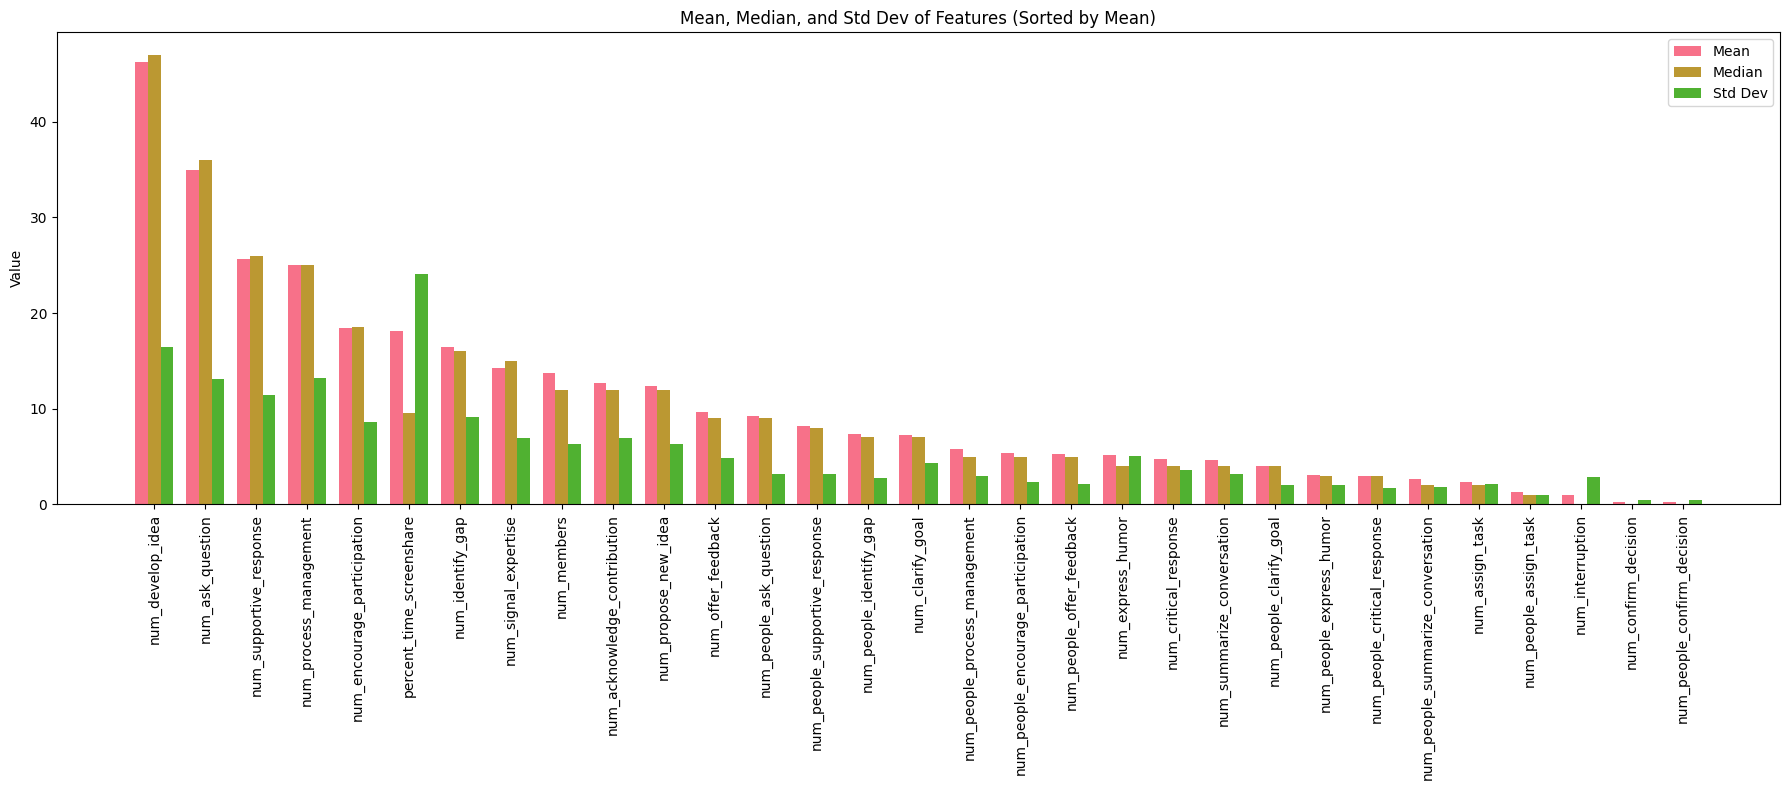

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Columns to exclude
exclude = ['conference', 'session', 'num_teams', 'num_funded_teams', 'meeting_length', 'time_screenshare']

# Select feature columns
feature_cols = [col for col in all_data_df.columns if col not in exclude and not col.endswith('_numeric')]

# Calculate statistics
means = all_data_df[feature_cols].mean()
medians = all_data_df[feature_cols].median()
stds = all_data_df[feature_cols].std()

# Sort features by mean (descending)
sorted_idx = means.sort_values(ascending=False).index
means_sorted = means[sorted_idx]
medians_sorted = medians[sorted_idx]
stds_sorted = stds[sorted_idx]

x = np.arange(len(feature_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, means_sorted, width, label='Mean')
ax.bar(x, medians_sorted, width, label='Median')
ax.bar(x + width, stds_sorted, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(sorted_idx, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (Sorted by Mean)')
ax.legend()
plt.tight_layout()
plt.show()

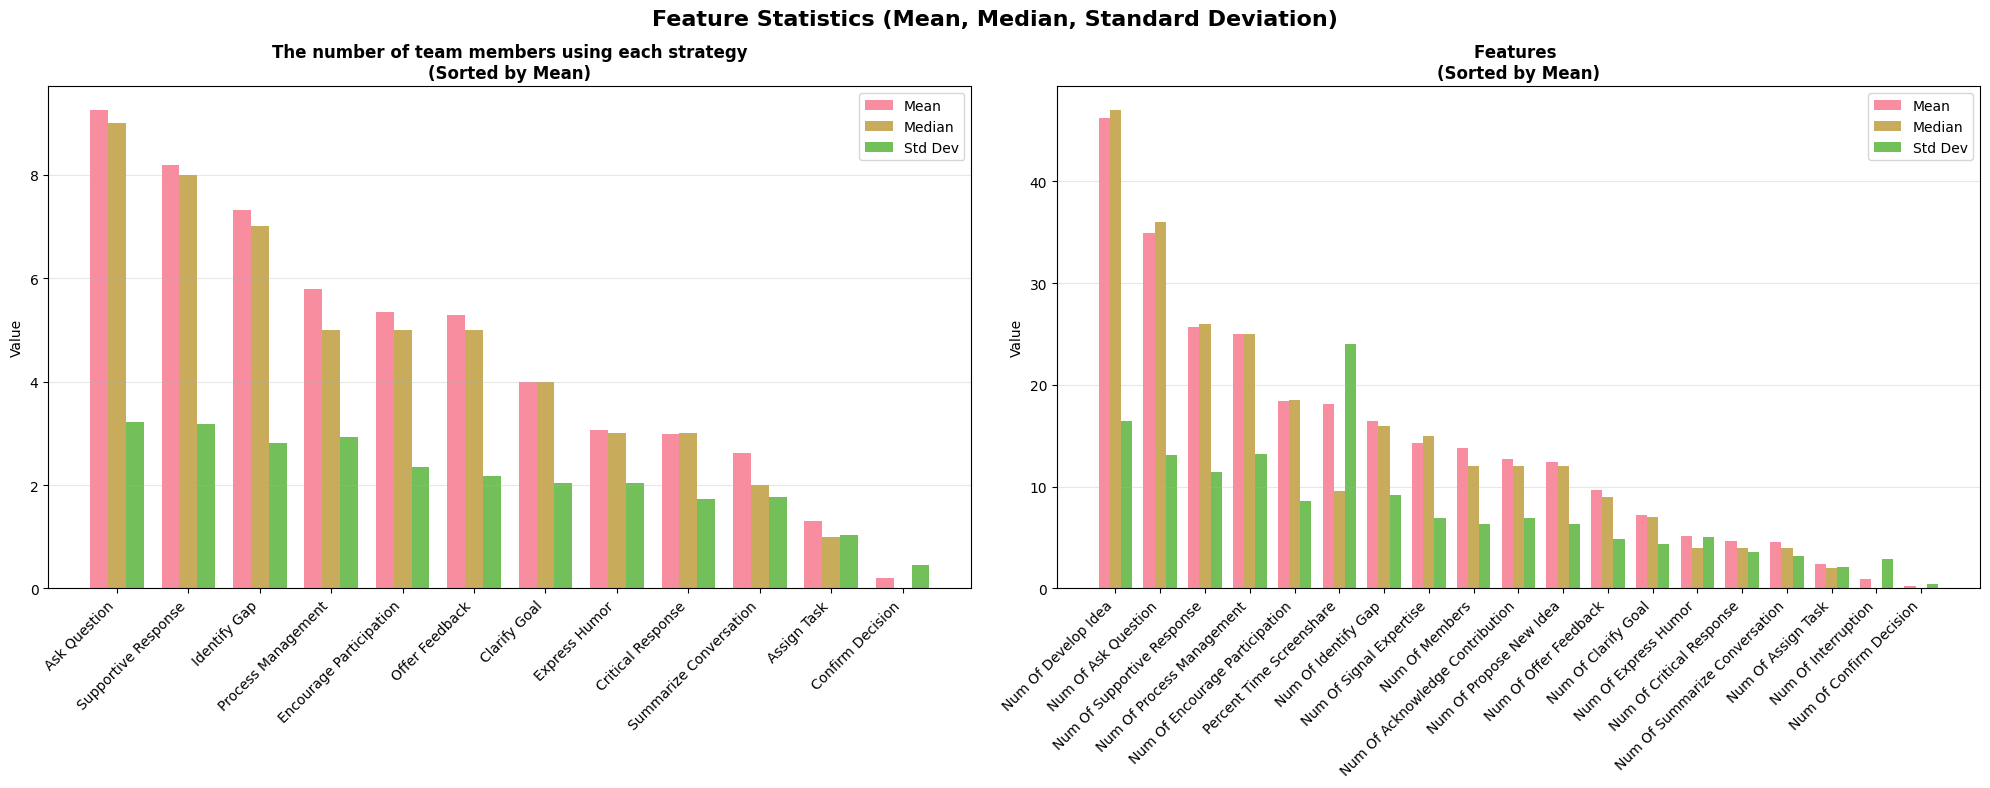

Features with 'people' in name (12):
  - num_people_ask_question
  - num_people_identify_gap
  - num_people_supportive_response
  - num_people_critical_response
  - num_people_offer_feedback
  - num_people_summarize_conversation
  - num_people_express_humor
  - num_people_encourage_participation
  - num_people_process_management
  - num_people_assign_task
  - num_people_clarify_goal
  - num_people_confirm_decision

Features without 'people' in name (19):
  - num_members
  - num_interruption
  - percent_time_screenshare
  - num_propose_new_idea
  - num_develop_idea
  - num_ask_question
  - num_signal_expertise
  - num_identify_gap
  - num_acknowledge_contribution
  - num_supportive_response
  - num_critical_response
  - num_offer_feedback
  - num_summarize_conversation
  - num_express_humor
  - num_encourage_participation
  - num_process_management
  - num_assign_task
  - num_clarify_goal
  - num_confirm_decision

SUMMARY STATISTICS

Features counting the number of people using a strate

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to exclude

exclude = ['conference', 'session', 'num_teams', 'num_funded_teams', 'meeting_length']
# Also exclude any columns that end with '_numeric'
exclude.extend([col for col in all_data_df.columns if col.endswith('_numeric')])
# Select feature columns
feature_cols = [col for col in all_data_df.columns if col not in exclude]

# Separate features with 'people' in name and those without
people_features = [col for col in feature_cols if 'people' in col.lower()]
other_features = [col for col in feature_cols if 'people' not in col.lower()]

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Feature Statistics (Mean, Median, Standard Deviation)', fontsize=16, fontweight='bold')

# Plot 1: Features with 'people' in name
if people_features:
    # Calculate statistics
    means = all_data_df[people_features].mean()
    medians = all_data_df[people_features].median()
    stds = all_data_df[people_features].std()
    
    # Sort features by mean (descending)
    sorted_idx = means.sort_values(ascending=False).index
    means_sorted = means[sorted_idx]
    medians_sorted = medians[sorted_idx]
    stds_sorted = stds[sorted_idx]
    
    # Clean feature names for display
    feature_names = [col.replace('num_people_', '').replace('_', ' ').title() for col in sorted_idx]
    
    x = np.arange(len(people_features))
    width = 0.25
    
    ax1.bar(x - width, means_sorted, width, label='Mean', alpha=0.8)
    ax1.bar(x, medians_sorted, width, label='Median', alpha=0.8)
    ax1.bar(x + width, stds_sorted, width, label='Std Dev', alpha=0.8)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(feature_names, rotation=45, ha='right')
    ax1.set_ylabel('Value')
    ax1.set_title('The number of team members using each strategy\n(Sorted by Mean)', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No features with "people" found', 
            ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('The number of team members using each strategy\n(Sorted by Mean)')

# Plot 2: Features without 'people' in name
if other_features:
    # Calculate statistics
    means = all_data_df[other_features].mean()
    medians = all_data_df[other_features].median()
    stds = all_data_df[other_features].std()
    
    # Sort features by mean (descending)
    sorted_idx = means.sort_values(ascending=False).index
    means_sorted = means[sorted_idx]
    medians_sorted = medians[sorted_idx]
    stds_sorted = stds[sorted_idx]
    
    # Clean feature names for display
    feature_names = [col.replace('num_', 'num of ').replace('_', ' ').title() for col in sorted_idx]
    
    x = np.arange(len(other_features))
    width = 0.25
    
    ax2.bar(x - width, means_sorted, width, label='Mean', alpha=0.8)
    ax2.bar(x, medians_sorted, width, label='Median', alpha=0.8)
    ax2.bar(x + width, stds_sorted, width, label='Std Dev', alpha=0.8)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(feature_names, rotation=45, ha='right')
    ax2.set_ylabel('Value')
    ax2.set_title('Features \n(Sorted by Mean)', fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No features without "people" found', 
            ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Features')

plt.tight_layout()
plt.show()

# Print summary of what features are in each category
print(f"Features with 'people' in name ({len(people_features)}):")
for feature in people_features:
    print(f"  - {feature}")

print(f"\nFeatures without 'people' in name ({len(other_features)}):")
for feature in other_features:
    print(f"  - {feature}")

# Print summary statistics
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")

if people_features:
    print(f"\nFeatures counting the number of people using a strategy:")
    print("-" * 40)
    people_stats = all_data_df[people_features].agg(['mean', 'median', 'std']).round(3)
    people_stats.columns = [col.replace('num_people_', '').replace('_', ' ').title() 
                           for col in people_stats.columns]
    print(people_stats.T)

if other_features:
    print(f"\nOther Features")
    print("-" * 40)
    other_stats = all_data_df[other_features].agg(['mean', 'median', 'std']).round(3)
    other_stats.columns = [col.replace('num_', '').replace('_', ' ').title() 
                          for col in other_stats.columns]
    print(other_stats.T)

In [53]:
print(all_data_df.columns)

Index(['conference', 'session', 'num_members', 'meeting_length',
       'num_interruption', 'percent_time_screenshare', 'num_propose_new_idea',
       'num_develop_idea', 'num_ask_question', 'num_signal_expertise',
       'num_identify_gap', 'num_acknowledge_contribution',
       'num_supportive_response', 'num_critical_response',
       'num_offer_feedback', 'num_summarize_conversation', 'num_express_humor',
       'num_encourage_participation', 'num_process_management',
       'num_assign_task', 'num_clarify_goal', 'num_confirm_decision',
       'num_people_ask_question', 'num_people_identify_gap',
       'num_people_supportive_response', 'num_people_critical_response',
       'num_people_offer_feedback', 'num_people_summarize_conversation',
       'num_people_express_humor', 'num_people_encourage_participation',
       'num_people_process_management', 'num_people_assign_task',
       'num_people_clarify_goal', 'num_people_confirm_decision', 'num_teams',
       'num_funded_teams', 'n

### Visualize individual sessions OR session differences

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np
import os
import re
import urllib.parse

def safe_file_path(path):
    # Split the path into directory and filename
    directory = os.path.dirname(path)
    filename = os.path.basename(path)
    # URL encode the filename to handle special characters
    safe_filename = urllib.parse.quote(filename, safe='')
    # Rejoin the path
    return os.path.join(directory, safe_filename)

def analyze_meeting(file_path):
# Safely handle the file path

    conf_name = file_path.split('/')[-1].split('.')[0]
    print(conf_name)
    # Use the safe file path
    safe_path = safe_file_path(file_path)
    feature_path = safe_file_path(file_path.replace('session_data/', 'featurized_data/features_'))

    with open(safe_path, 'r') as f:
        data = json.load(f)
    
    with open(feature_path, 'r') as f:
        feature_data = json.load(f)

    # Extract just the base filename without path and extension
    file_name = os.path.basename(file_path)
    file_name = os.path.splitext(file_name)[0]  # Remove extension

    # Extract annotations
    all_annotations = []
    data = data['all_data']
    for entry in data:
        if 'annotations' in entry:
            if isinstance(entry['annotations'], dict):
                all_annotations.extend(entry['annotations'].keys())
            elif isinstance(entry['annotations'], list):
                all_annotations.extend(entry['annotations'])

    # remove 'None' from all_annotations
    all_annotations = [annotation for annotation in all_annotations if annotation != 'None']

    def normalize_annotation(annotation):
        # Replace underscores with spaces and convert to lowercase
        normalized = re.sub(r'_', ' ', annotation.lower()).strip()
        
        return normalized

    # Create a mapping of normalized forms to all their original forms
    normalized_to_originals = defaultdict(list)
    for annotation in all_annotations:
        normalized = normalize_annotation(annotation)
        normalized_to_originals[normalized].append(annotation)

    # Choose the most common original form for each normalized form
    normalized_to_preferred = {}
    for normalized, originals in normalized_to_originals.items():
        # Count occurrences of each original form
        original_counts = Counter(originals)
        # Choose the most common one (or the first if tied)
        preferred = max(original_counts.items(), key=lambda x: (x[1], len(x[0])))[0]
        normalized_to_preferred[normalized] = preferred

    # Count normalized annotations
    normalized_counts = Counter(normalize_annotation(a) for a in all_annotations)

    # Create a DataFrame with normalized counts and preferred original names
    annotation_df = pd.DataFrame({
        'normalized_name': list(normalized_counts.keys()),
        'count': list(normalized_counts.values()),
        'original_name': [normalized_to_preferred[n] for n in normalized_counts.keys()]
    })

    # Sort by count
    annotation_df = annotation_df.sort_values('count', ascending=True)

    # Calculate speaking time per speaker
    speaker_times = defaultdict(int)
    for entry in data:
        speaker_times[entry['speaker']] += int(entry['speaking_duration'])

    # Create turn taking sequence
    turn_sequence = [entry['speaker'] for entry in data]

    # Set the style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    # 1. Annotation counts - Separate full-size plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=annotation_df, x='count', y='original_name')
    plt.title(f'Annotation Types and Their Frequencies for {conf_name}', fontsize=14, pad=20)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Annotation Type', fontsize=12)
    plt.tight_layout()
    plt.show()  
    # plt.savefig(f'annotation_counts_{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Speaking time per speaker - Separate full-size plot
    plt.figure(figsize=(12, 8))
    speaker_df = pd.DataFrame.from_dict(speaker_times, orient='index', columns=['duration'])
    speaker_df = speaker_df.sort_values('duration', ascending=True)
    sns.barplot(data=speaker_df.reset_index(), x='duration', y='index')
    plt.title(f'Total Speaking Duration by Speaker for {conf_name}', fontsize=14, pad=20)
    plt.xlabel('Duration (seconds)', fontsize=12)
    plt.ylabel('Speaker', fontsize=12)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'speaking_duration_{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Turn taking pattern - Separate full-size plot
    plt.figure(figsize=(14, 8))
    unique_speakers = list(set(turn_sequence))
    y_positions = range(len(unique_speakers))
    speaker_to_y = dict(zip(unique_speakers, y_positions))
    x_positions = range(len(turn_sequence))
    y_values = [speaker_to_y[speaker] for speaker in turn_sequence]

    plt.plot(x_positions, y_values, 'o-', linewidth=1.5, markersize=8)
    plt.yticks(y_positions, unique_speakers)
    plt.title(f'Turn Taking Pattern Over Time for {conf_name}', fontsize=14, pad=20)
    plt.xlabel('Turn Sequence', fontsize=12)
    plt.ylabel('Speaker', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'turn_taking_{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Timeline visualization of annotations - New visualization
    plt.figure(figsize=(16, 10))

    # Prepare data for timeline visualization
    timeline_data = []
    colors = plt.cm.Set3(np.linspace(0, 1, len(normalized_counts)))

    # Convert time strings to seconds for x-axis
    def time_to_seconds(time_str):
        """Convert time string like '00:01' to seconds"""
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds

    # Collect all annotation occurrences with their timing
    for entry in data:
        if 'annotations' in entry and entry['annotations']:
            start_time = time_to_seconds(entry['start_time'])
            end_time = time_to_seconds(entry['end_time'])
            duration = end_time - start_time
            
            for annotation in entry['annotations'].keys():
                if annotation != 'None':
                    normalized_annotation = normalize_annotation(annotation)
                    timeline_data.append({
                        'annotation': normalized_annotation,
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration
                    })

    # Create DataFrame for timeline
    timeline_df = pd.DataFrame(timeline_data)

    if not timeline_df.empty:
        # Get unique annotations and assign colors
        unique_annotations = timeline_df['annotation'].unique()
        annotation_to_color = dict(zip(unique_annotations, colors[:len(unique_annotations)]))
        
        # Create the timeline plot
        y_positions = range(len(unique_annotations))
        annotation_to_y = dict(zip(unique_annotations, y_positions))
        
        # Plot horizontal bars for each annotation occurrence
        for _, row in timeline_df.iterrows():
            annotation = row['annotation']
            start_time = row['start_time']
            duration = row['duration']
            y_pos = annotation_to_y[annotation]
            color = annotation_to_color[annotation]
            
            plt.barh(y_pos, duration, left=start_time, height=0.6, 
                    color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize the plot
        plt.yticks(y_positions, unique_annotations)
        plt.xlabel('Time (seconds)', fontsize=12)
        plt.ylabel('Annotation Types', fontsize=12)
        plt.title(f'Timeline of Annotation Occurrences During Meeting for {conf_name}', fontsize=14, pad=20)
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=annotation_to_color[ann], 
                                    edgecolor='black', linewidth=0.5, label=ann) 
                        for ann in unique_annotations]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        # plt.savefig(f'annotation_timeline_{file_name}.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        print("No annotation data found for timeline visualization")
        plt.close()



2021_09_30_MZT_S5


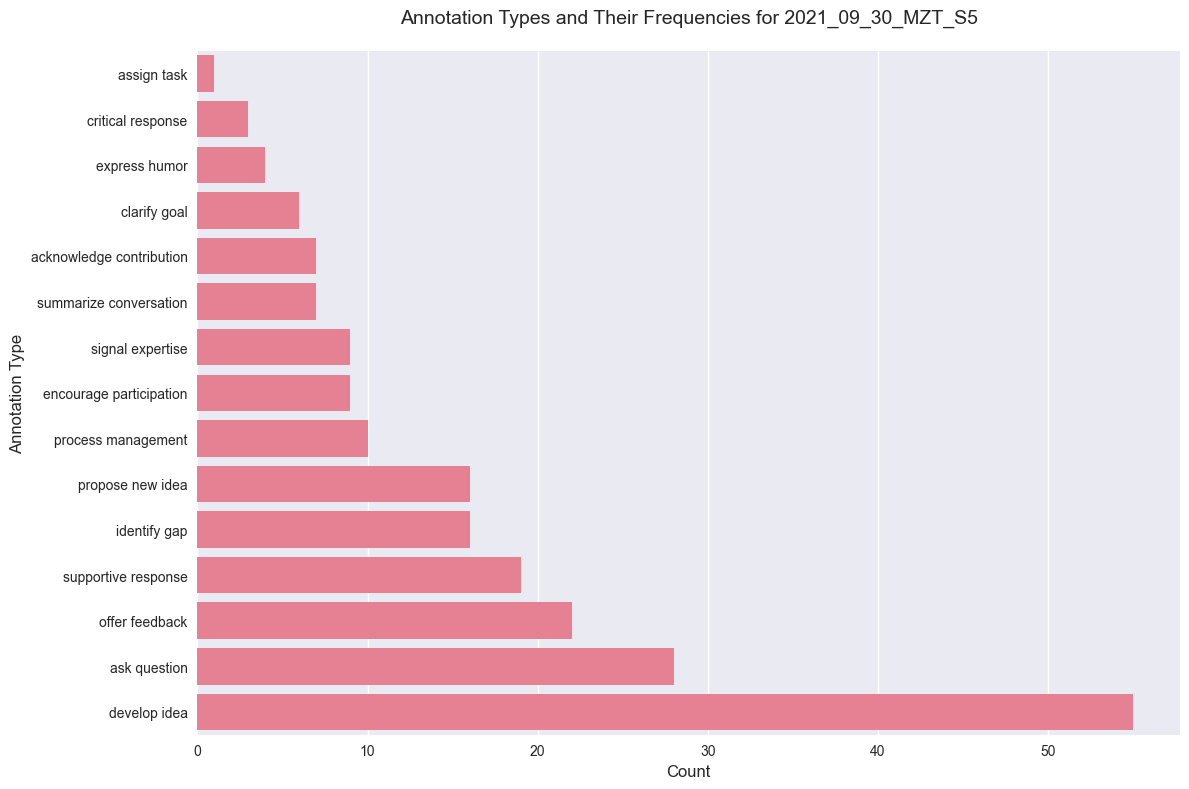

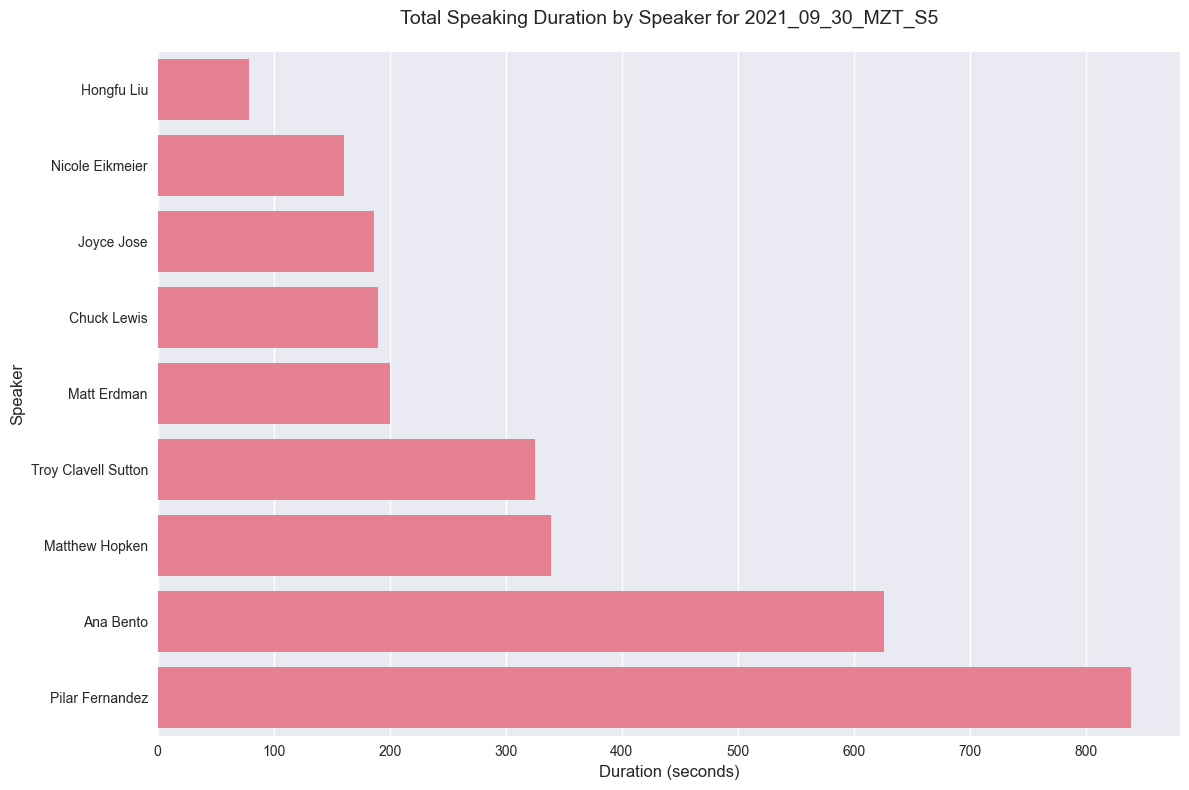

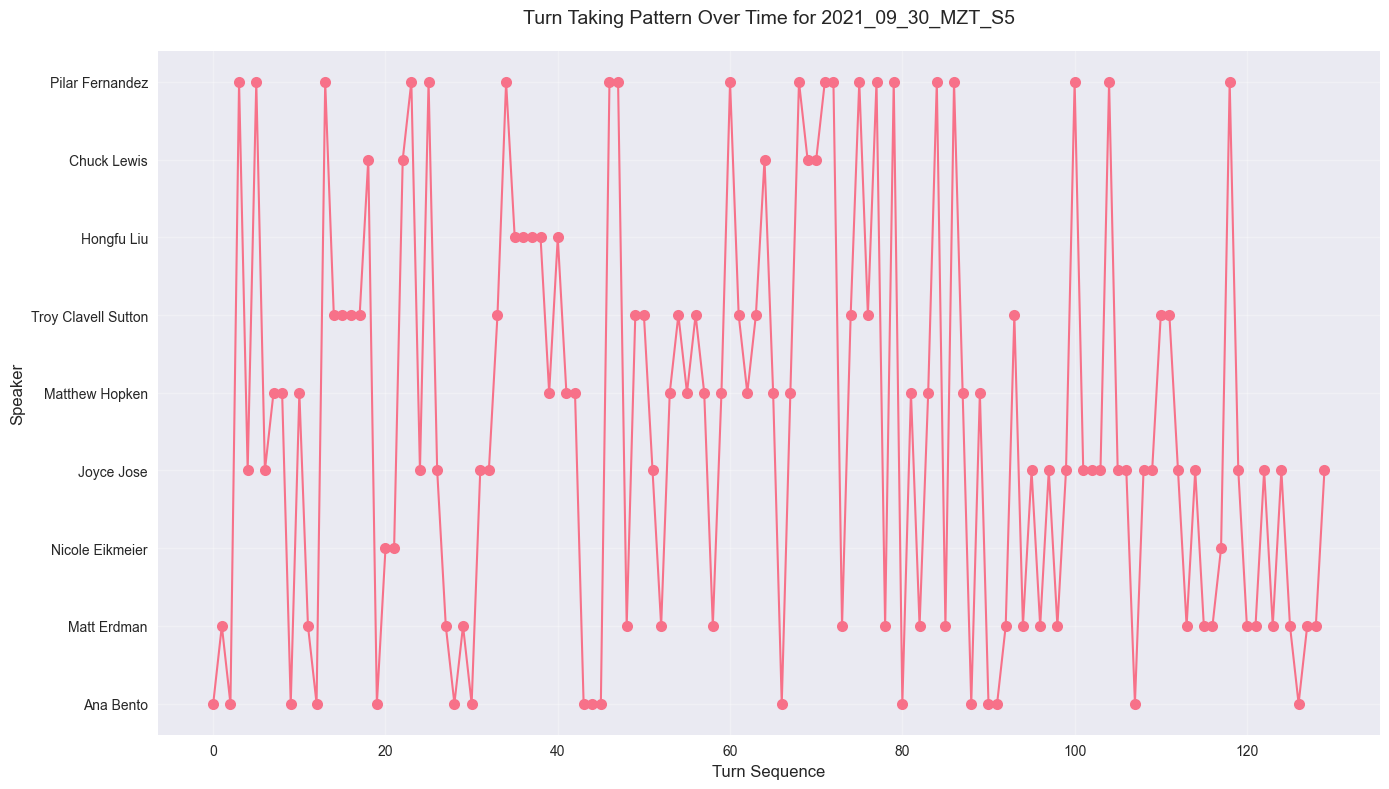

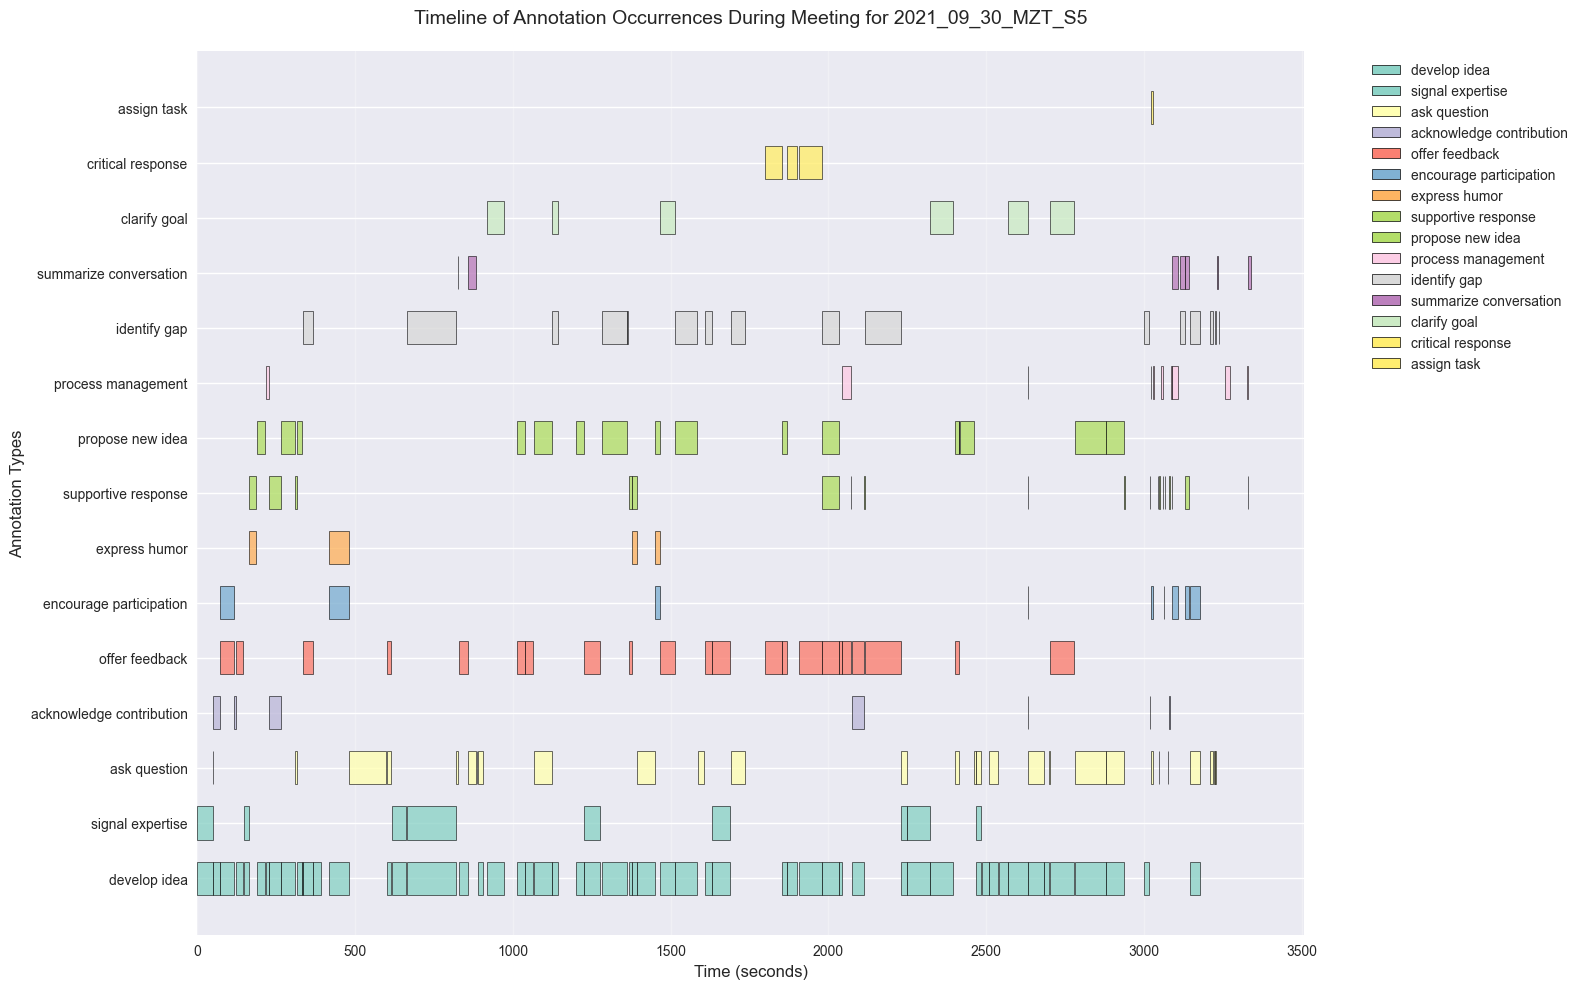

In [25]:
session_name = '2021_09_30_MZT_S5'
conf_name = '2021MZT'
session_data_path = f"data/{conf_name}/session_data/{session_name}.json"
feature_data_path = f"data/{conf_name}/featurized data/features_{session_name}.json"
    # Read the JSON data
analyze_meeting(session_data_path)

2021_09_30_MZT_S7


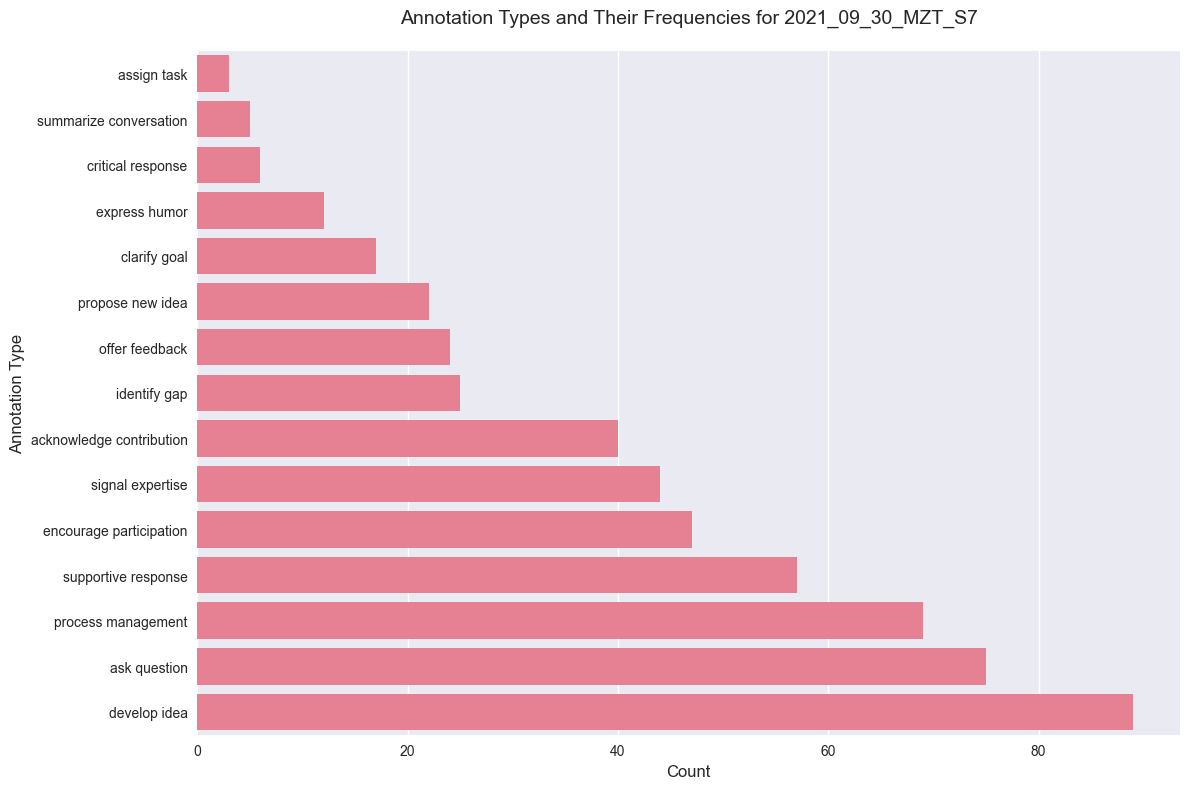

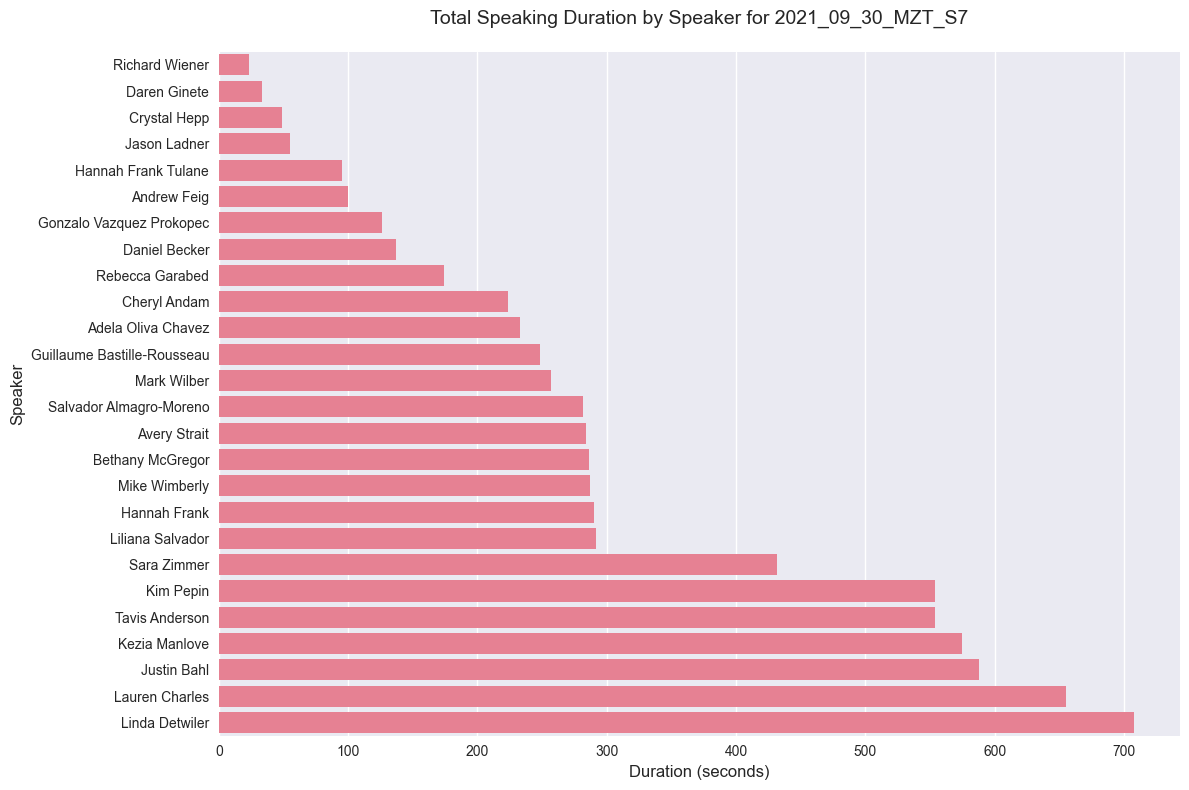

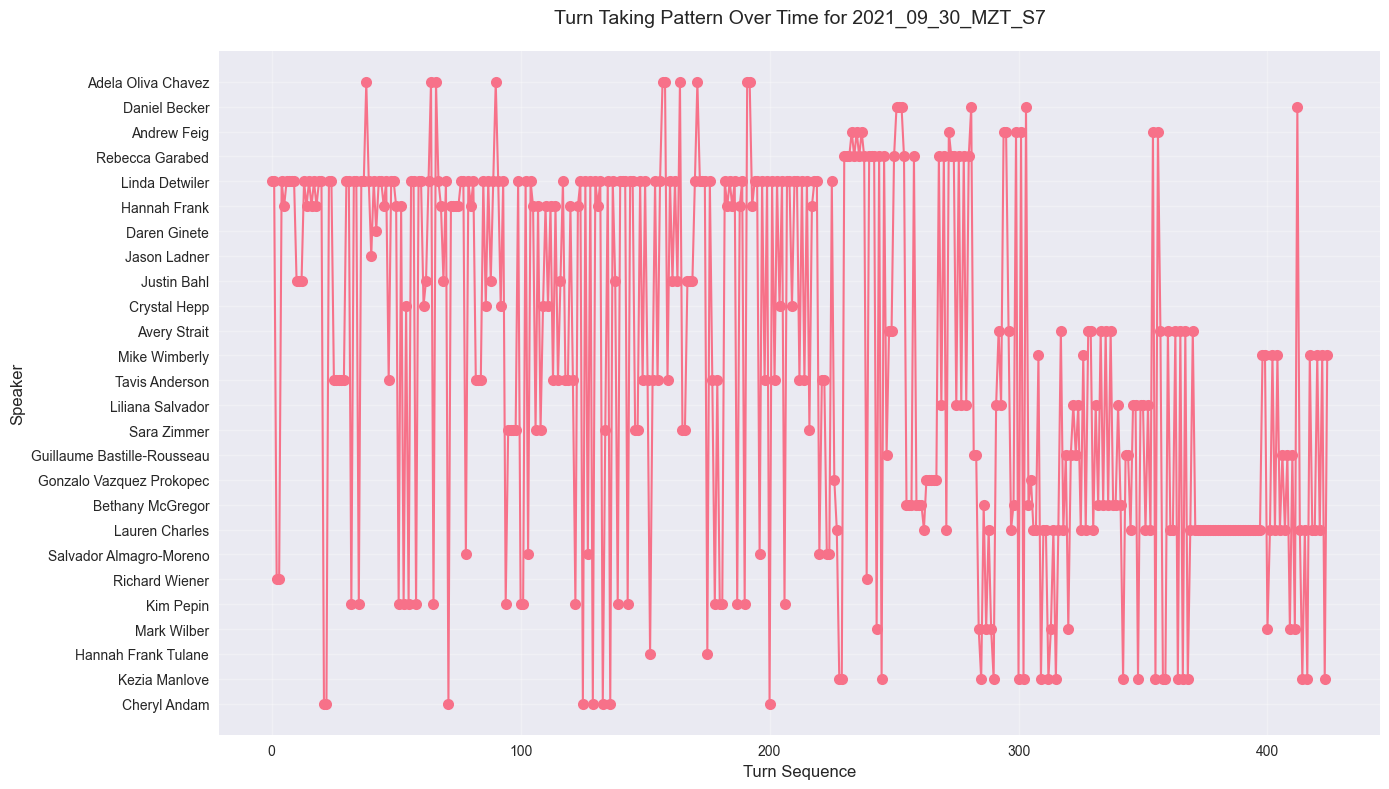

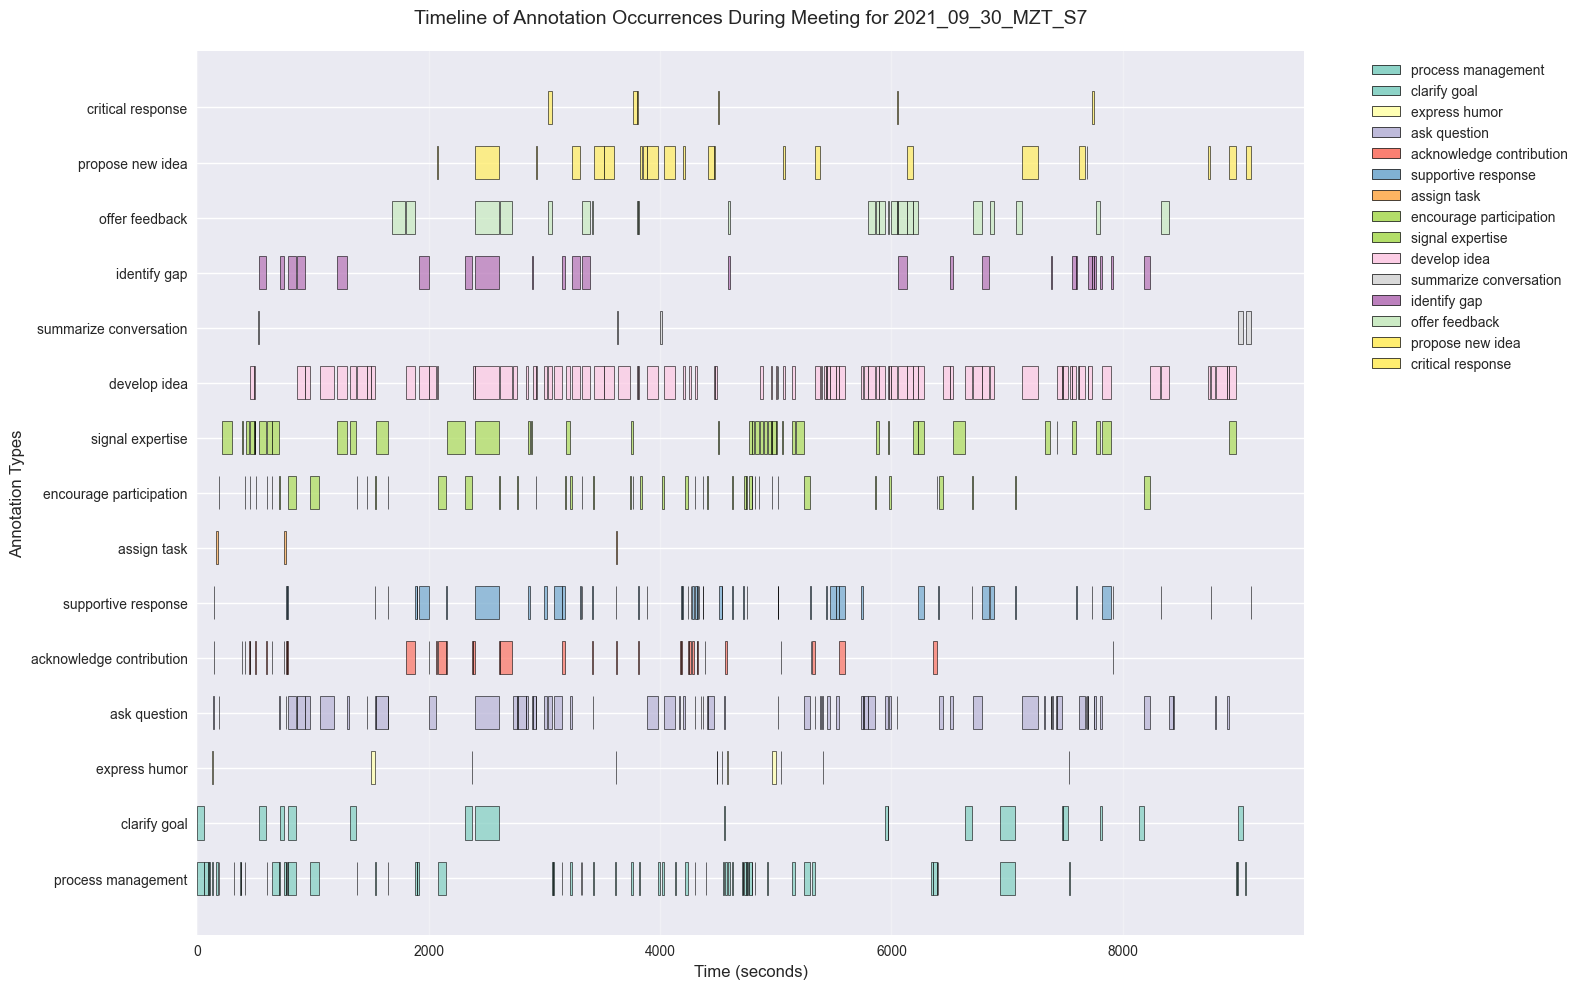

In [16]:
file_path='/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S7.json'
analyze_meeting(file_path)

#### Compare two sessions side by side

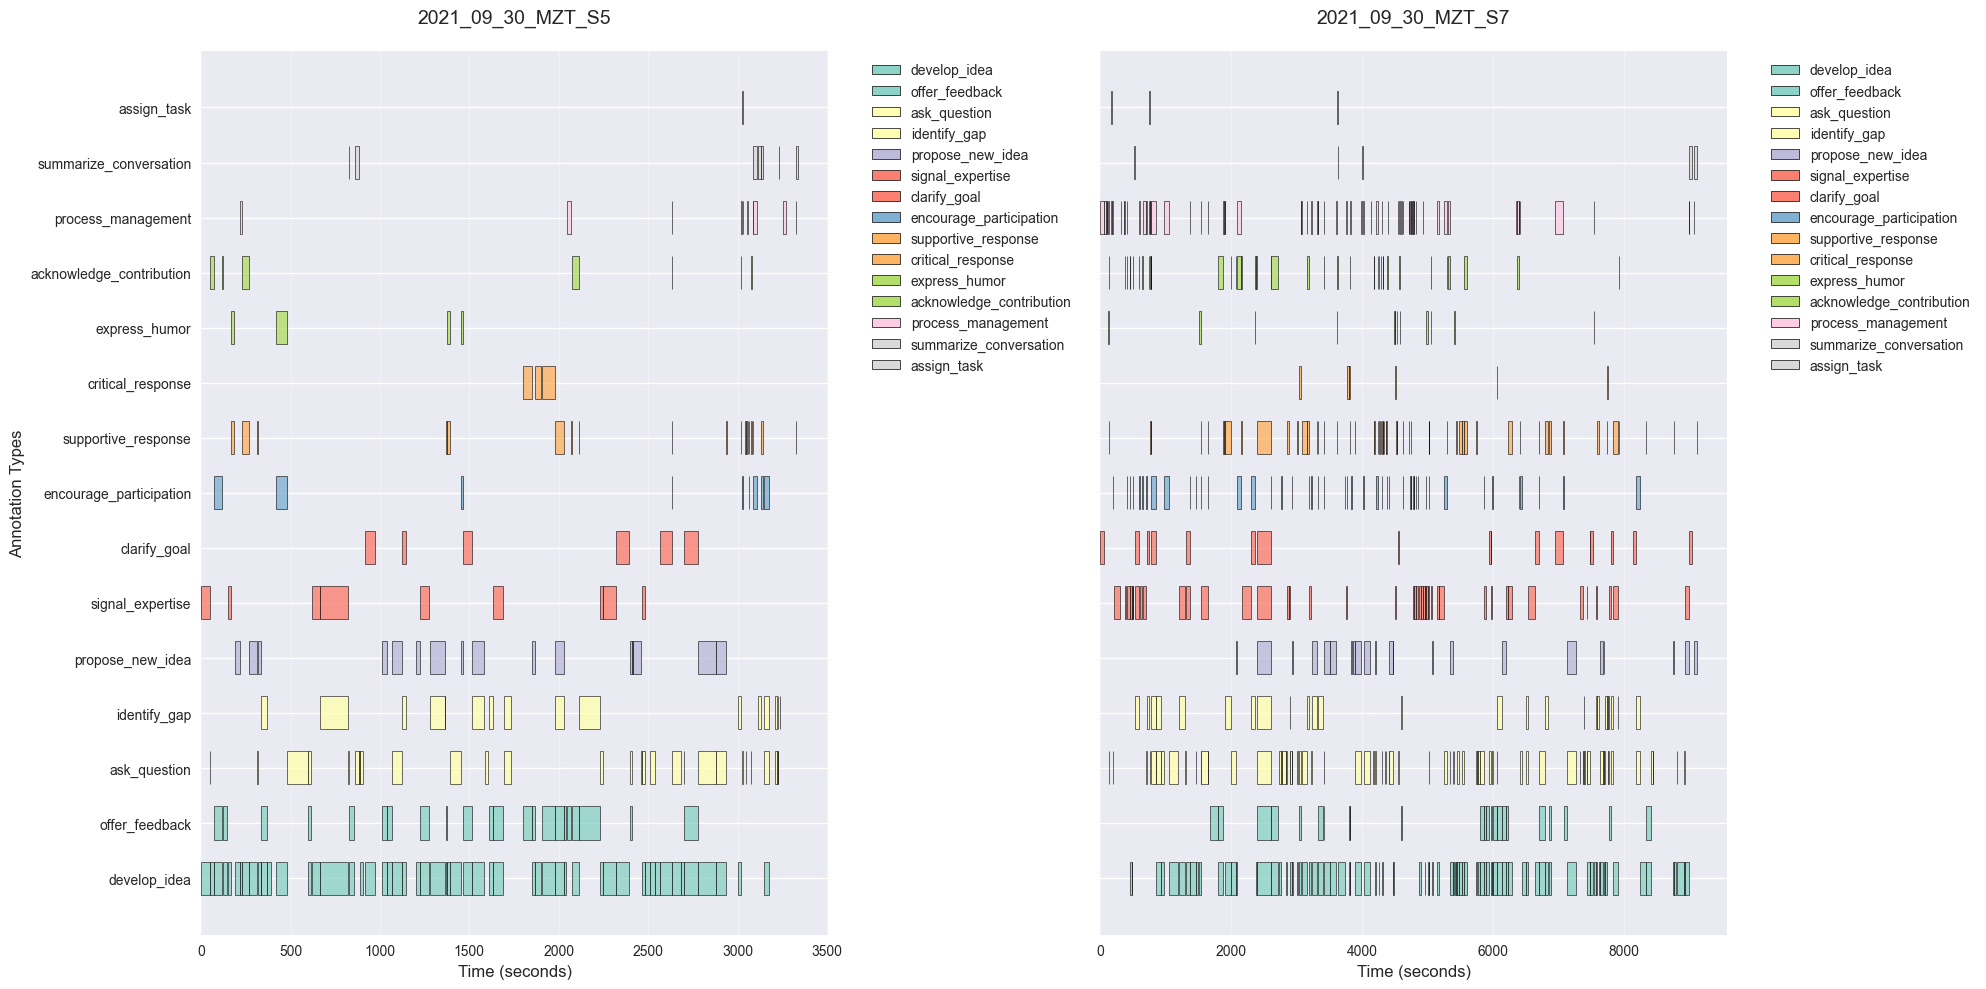

True

In [21]:

## create visusalization with side by side comparison
def normalize_annotation(annotation):
    """Normalize annotation names for consistency"""
    # Add your normalization logic here if needed
    return annotation.lower().replace(' ', '_')

def time_to_seconds(time_str):
    """Convert time string like '00:01' to seconds"""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

def create_timeline_visualization(data, conf_name, file_name, all_annotation_types=None, ax=None, show_y_labels=True):
    """
    Create timeline visualization for a single session
    all_annotation_types: list of all possible annotation types for consistent ordering
    ax: matplotlib axis to plot on (if None, creates new figure)
    show_y_labels: whether to show y-axis labels (set to False for side-by-side comparison)
    """
    if ax is None:
        plt.figure(figsize=(16, 10))
        ax = plt.gca()
    
    # Prepare data for timeline visualization
    timeline_data = []
    colors = plt.cm.Set3(np.linspace(0, 1, 20))  # Use more colors for consistency

    # Collect all annotation occurrences with their timing
    for entry in data:
        if 'annotations' in entry and entry['annotations']:
            start_time = time_to_seconds(entry['start_time'])
            end_time = time_to_seconds(entry['end_time'])
            duration = end_time - start_time
            
            for annotation in entry['annotations'].keys():
                if annotation != 'None':
                    normalized_annotation = normalize_annotation(annotation)
                    timeline_data.append({
                        'annotation': normalized_annotation,
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration
                    })

    # Create DataFrame for timeline
    timeline_df = pd.DataFrame(timeline_data)

    if not timeline_df.empty:
        # Get unique annotations for this session
        session_annotations = timeline_df['annotation'].unique()
        
        # If all_annotation_types is provided, use it for consistent ordering
        if all_annotation_types is not None:
            # Filter to only include annotations that exist in this session
            available_annotations = [ann for ann in all_annotation_types if ann in session_annotations]
            unique_annotations = available_annotations
        else:
            unique_annotations = sorted(session_annotations)
        
        # Assign colors and positions
        annotation_to_color = dict(zip(unique_annotations, colors[:len(unique_annotations)]))
        y_positions = range(len(unique_annotations))
        annotation_to_y = dict(zip(unique_annotations, y_positions))
        
        # Plot horizontal bars for each annotation occurrence
        for _, row in timeline_df.iterrows():
            annotation = row['annotation']
            if annotation in annotation_to_y:  # Only plot if annotation is in our ordered list
                start_time = row['start_time']
                duration = row['duration']
                y_pos = annotation_to_y[annotation]
                color = annotation_to_color[annotation]
                
                ax.barh(y_pos, duration, left=start_time, height=0.6, 
                        color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize the plot
        ax.set_yticks(y_positions)
        if show_y_labels:
            ax.set_yticklabels(unique_annotations)
            ax.set_ylabel('Annotation Types', fontsize=12)
        ax.set_xlabel('Time (seconds)', fontsize=12)
        ax.set_title(f'{conf_name}', fontsize=14, pad=20)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=annotation_to_color[ann], 
                                    edgecolor='black', linewidth=0.5, label=ann) 
                        for ann in unique_annotations]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        return True
    else:
        print(f"No annotation data found for timeline visualization in {conf_name}")
        return False

def compare_sessions_side_by_side(session1_data, session1_name, session2_data, session2_name, save_path=None):
    """
    Create side-by-side timeline comparison of two sessions with shared y-axis labels
    """
    # First, get all unique annotation types from both sessions
    all_annotations = set()
    
    # Collect annotations from session 1
    for entry in session1_data:
        if 'annotations' in entry and entry['annotations']:
            for annotation in entry['annotations'].keys():
                if annotation != 'None':
                    all_annotations.add(normalize_annotation(annotation))
    
    # Collect annotations from session 2
    for entry in session2_data:
        if 'annotations' in entry and entry['annotations']:
            for annotation in entry['annotations'].keys():
                if annotation != 'None':
                    all_annotations.add(normalize_annotation(annotation))
    
    # Calculate total duration for each annotation type in session 1
    session1_durations = {}
    for entry in session1_data:
        if 'annotations' in entry and entry['annotations']:
            start_time = time_to_seconds(entry['start_time'])
            end_time = time_to_seconds(entry['end_time'])
            duration = end_time - start_time
            
            for annotation in entry['annotations'].keys():
                if annotation != 'None':
                    normalized_annotation = normalize_annotation(annotation)
                    if normalized_annotation in session1_durations:
                        session1_durations[normalized_annotation] += duration
                    else:
                        session1_durations[normalized_annotation] = duration
    
    # Sort annotation types by total duration in session 1 (descending order)
    # For annotations not in session 1, assign duration 0
    all_annotation_types = sorted(
        list(all_annotations), 
        key=lambda x: session1_durations.get(x, 0), 
        reverse=True
    )
    
    # Create the comparison figure with shared y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
    
    # Create timeline for session 1 (with y-axis labels)
    success1 = create_timeline_visualization(session1_data, session1_name, "session1", all_annotation_types, ax1, show_y_labels=True)
    
    # Create timeline for session 2 (without y-axis labels)
    success2 = create_timeline_visualization(session2_data, session2_name, "session2", all_annotation_types, ax2, show_y_labels=False)
    
    if success1 and success2:
        # No overall title needed since each plot has its own title
        
        plt.tight_layout()
        plt.show()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.close()
        return True
    else:
        plt.close()
        return False

def load_session_data(file_path):
    """Load session data from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract the data array
    if 'all_data' in data:
        return data['all_data']
    else:
        return data


def load_session_data(file_path):
    """Load session data from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract the data array
    if 'all_data' in data:
        return data['all_data']
    else:
        return data


#  Compare two sessions
session1_path = "/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S5.json"
session2_path = "/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S7.json"

session1_name = session1_path.split('/')[-1].split('.')[0]
session2_name = session2_path.split('/')[-1].split('.')[0]
session1_data = load_session_data(session1_path)
session2_data = load_session_data(session2_path)

compare_sessions_side_by_side(
    session1_data, session1_name, 
    session2_data, session2_name,
    save_path=f"comparison_timeline_{session1_name}_{session2_name}.png"
)




Comparing feature data between 2021_09_30_MZT_S5 and 2021_09_30_MZT_S7...
Excluded 'meeting_length' from comparison due to scale differences.
Found 31 common numerical features: ['num_propose_new_idea', 'num_people_ask_question', 'num_people_identify_gap', 'num_supportive_response', 'num_people_offer_feedback', 'percent_time_screenshare', 'num_develop_idea', 'num_clarify_goal', 'num_encourage_participation', 'num_people_clarify_goal', 'num_interruption', 'num_people_summarize_conversation', 'num_confirm_decision', 'num_people_supportive_response', 'num_offer_feedback', 'num_people_assign_task', 'num_ask_question', 'num_assign_task', 'num_people_express_humor', 'num_summarize_conversation', 'num_signal_expertise', 'num_identify_gap', 'num_people_process_management', 'num_acknowledge_contribution', 'num_process_management', 'num_people_confirm_decision', 'num_people_critical_response', 'num_critical_response', 'num_people_encourage_participation', 'num_express_humor', 'num_members']


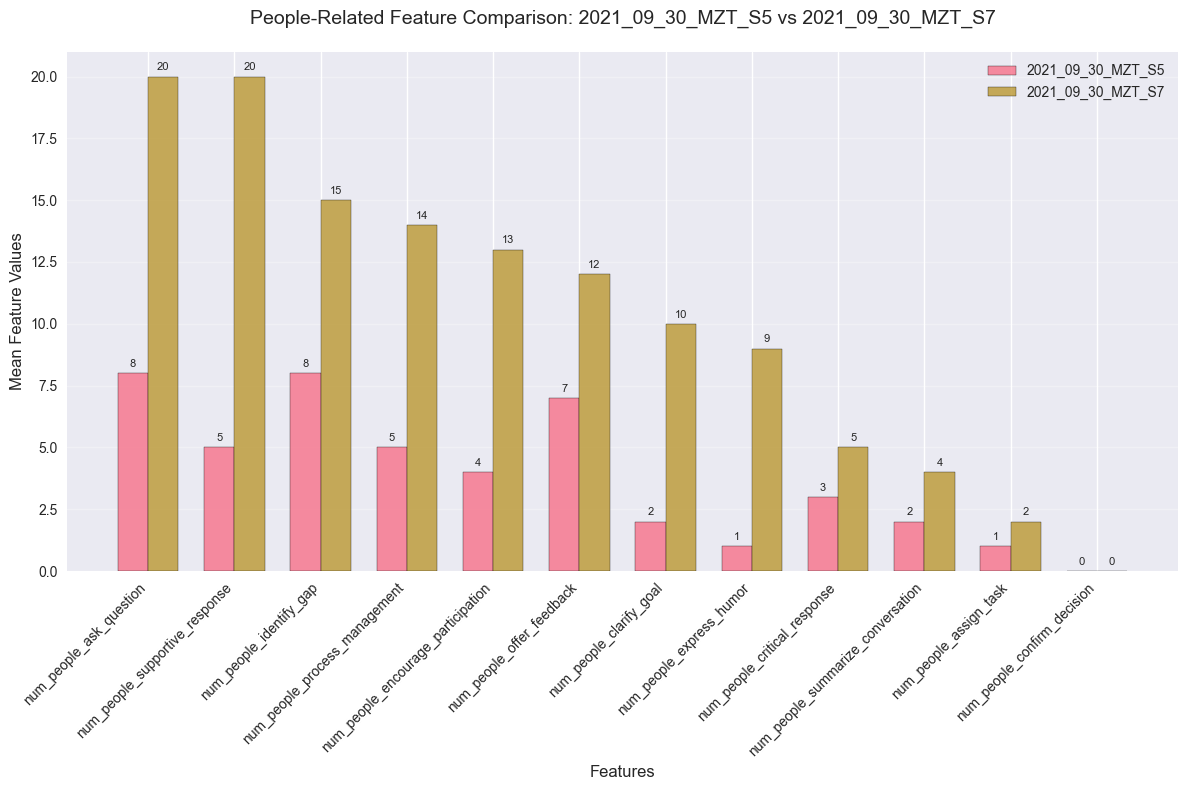

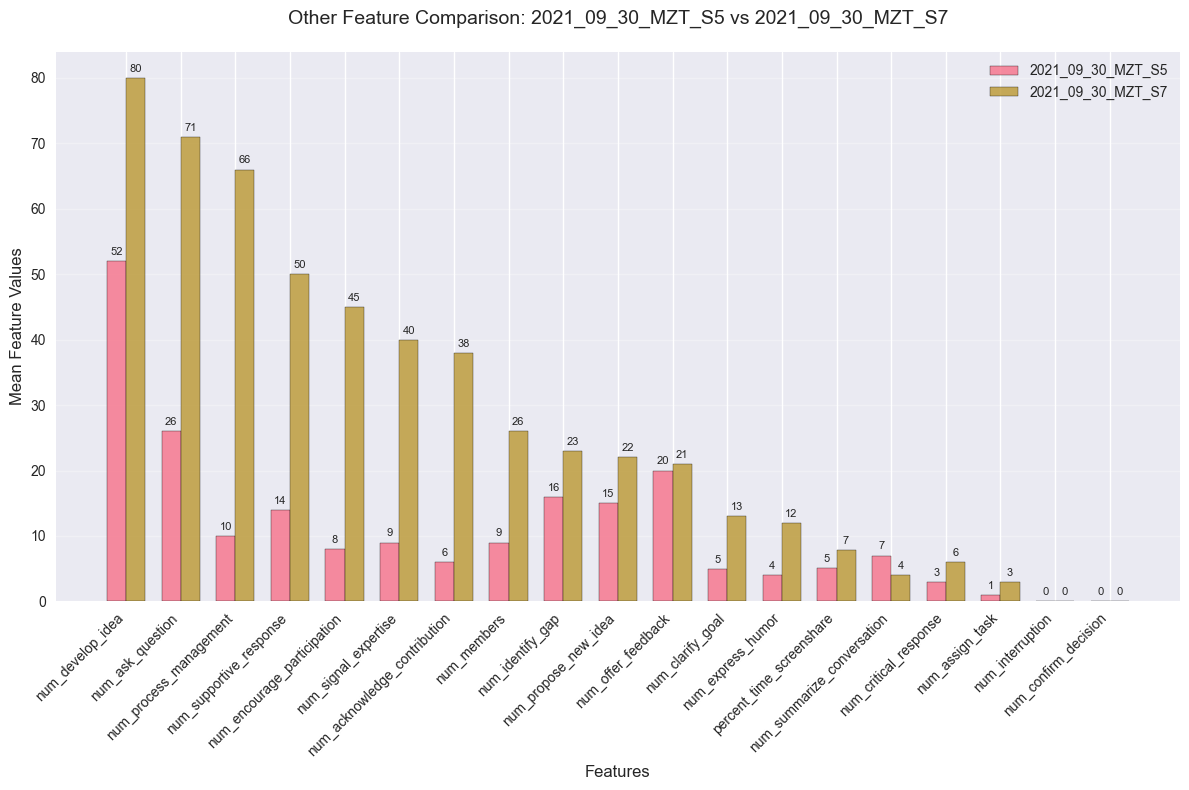


Feature Comparison Statistics:
                               Feature  2021_09_30_MZT_S5  2021_09_30_MZT_S7
0                 num_propose_new_idea            15.0000            22.0000
1              num_people_ask_question             8.0000            20.0000
2              num_people_identify_gap             8.0000            15.0000
3              num_supportive_response            14.0000            50.0000
4            num_people_offer_feedback             7.0000            12.0000
5             percent_time_screenshare             5.0934             7.8372
6                     num_develop_idea            52.0000            80.0000
7                     num_clarify_goal             5.0000            13.0000
8          num_encourage_participation             8.0000            45.0000
9              num_people_clarify_goal             2.0000            10.0000
10                    num_interruption             0.0000             0.0000
11   num_people_summarize_conversation      

True

In [34]:
def load_feature_data(file_path):
    """Load feature data from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Convert feature data to DataFrame for easier analysis
    if isinstance(data, dict):
        # If it's a dictionary, try to extract the main data
        if 'features' in data:
            data = data['features']
        elif 'data' in data:
            data = data['data']
    
    # Convert to DataFrame if it's a list
    if isinstance(data, list):
        feature_df = pd.DataFrame(data)
    else:
        feature_df = pd.DataFrame([data])
    
    return feature_df


def compare_feature_data(feature_df1, feature_df2, session1_name, session2_name, save_path=None):
    """
    Compare feature data between two sessions and create visualizations
    """
    print(f"Comparing feature data between {session1_name} and {session2_name}...")
    
    # Get numerical features from both dataframes
    numerical_features1 = feature_df1.select_dtypes(include=[np.number]).columns
    numerical_features2 = feature_df2.select_dtypes(include=[np.number]).columns
    
    # Find common numerical features
    common_features = list(set(numerical_features1) & set(numerical_features2))
    
    # Exclude meeting_length as it has much larger values
    if 'meeting_length' in common_features:
        common_features.remove('meeting_length')
        print("Excluded 'meeting_length' from comparison due to scale differences.")
    
    if len(common_features) == 0:
        print("No common numerical features found between the two sessions.")
        return False
    
    print(f"Found {len(common_features)} common numerical features: {common_features}")
    
    # Set the style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Calculate mean values for each feature in both sessions
    feature_means = []
    for feature in common_features:
        values1 = feature_df1[feature].dropna()
        values2 = feature_df2[feature].dropna()
        
        feature_means.append({
            'Feature': feature,
            session1_name: values1.mean(),
            session2_name: values2.mean()
        })
    
    # Create DataFrame for plotting
    comparison_df = pd.DataFrame(feature_means)
    
    # Split features into two groups: with "people" and without "people"
    people_features = []
    other_features = []
    
    for _, row in comparison_df.iterrows():
        feature_name = row['Feature']
        if 'people' in feature_name.lower():
            people_features.append(row)
        else:
            other_features.append(row)
    
    # Sort each group by the highest value (max of both sessions)
    def sort_by_highest_value(feature_list):
        return sorted(feature_list, 
                     key=lambda x: max(x[session1_name], x[session2_name]), 
                     reverse=True)
    
    people_features = sort_by_highest_value(people_features)
    other_features = sort_by_highest_value(other_features)
    
    # Create two separate plots
    def create_feature_plot(feature_list, plot_title, save_suffix):
        if not feature_list:
            print(f"No {plot_title.lower()} features found.")
            return
        
        # Create DataFrame for this group
        plot_df = pd.DataFrame(feature_list)
        features = plot_df['Feature'].tolist()
        
        # Create bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Set up the bar positions
        x = np.arange(len(features))
        width = 0.35
        
        # Create bars for each session
        bars1 = ax.bar(x - width/2, plot_df[session1_name], width, 
                       label=session1_name, alpha=0.8, edgecolor='black')
        bars2 = ax.bar(x + width/2, plot_df[session2_name], width, 
                       label=session2_name, alpha=0.8, edgecolor='black')
        
        # Customize the plot
        ax.set_xlabel('Features', fontsize=12)
        ax.set_ylabel('Mean Feature Values', fontsize=12)
        ax.set_title(f'{plot_title} Feature Comparison: {session1_name} vs {session2_name}', fontsize=14, pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(features, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        def autolabel(bars):
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{int(height)}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
        
        autolabel(bars1)
        autolabel(bars2)
        
        plt.tight_layout()
        
        if save_path:
            feature_save_path = save_path.replace('.png', f'_feature_comparison_{save_suffix}.png')
            plt.savefig(feature_save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        plt.close()
    
    # Create plots for each group
    create_feature_plot(people_features, "People-Related", "people")
    create_feature_plot(other_features, "Other", "other")
    
    # Print comparison statistics
    print(f"\nFeature Comparison Statistics:")
    print(comparison_df.round(4))
    
    if save_path:
        stats_save_path = save_path.replace('.png', '_feature_stats.csv')
        comparison_df.to_csv(stats_save_path, index=False)
        print(f"Feature comparison statistics saved to: {stats_save_path}")
    
    return True

feature_df1 = load_feature_data('data/2021MZT/featurized data/features_2021_09_30_MZT_S5.json')
feature_df2 = load_feature_data('data/2021MZT/featurized data/features_2021_09_30_MZT_S7.json')
compare_feature_data(feature_df1, feature_df2, '2021_09_30_MZT_S5', '2021_09_30_MZT_S7')

2021_09_30_MZT_S7


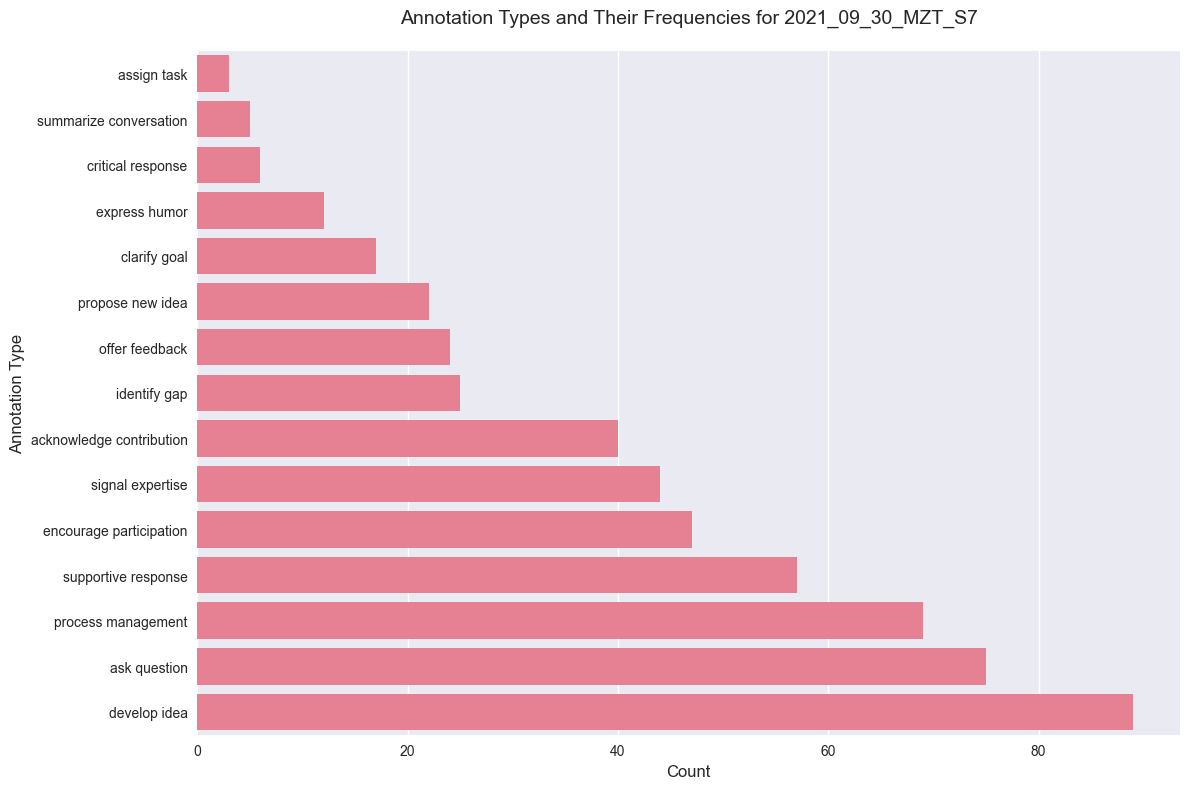

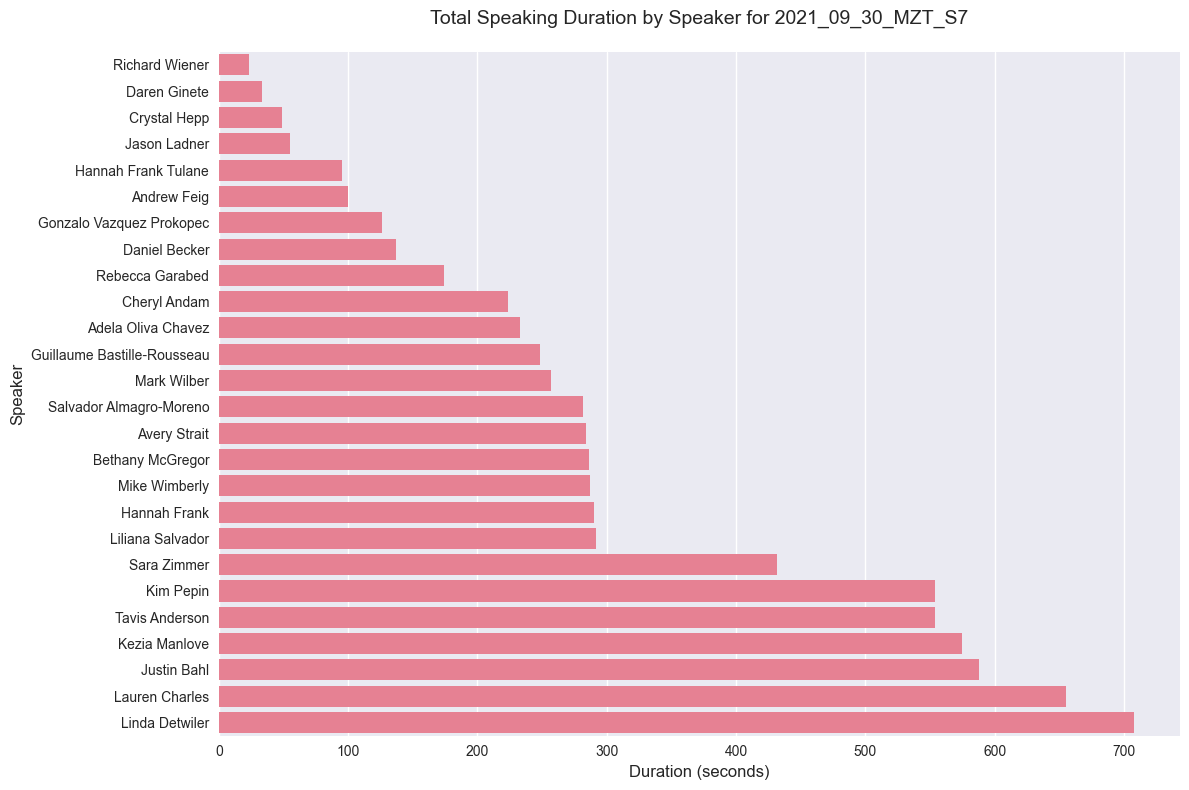

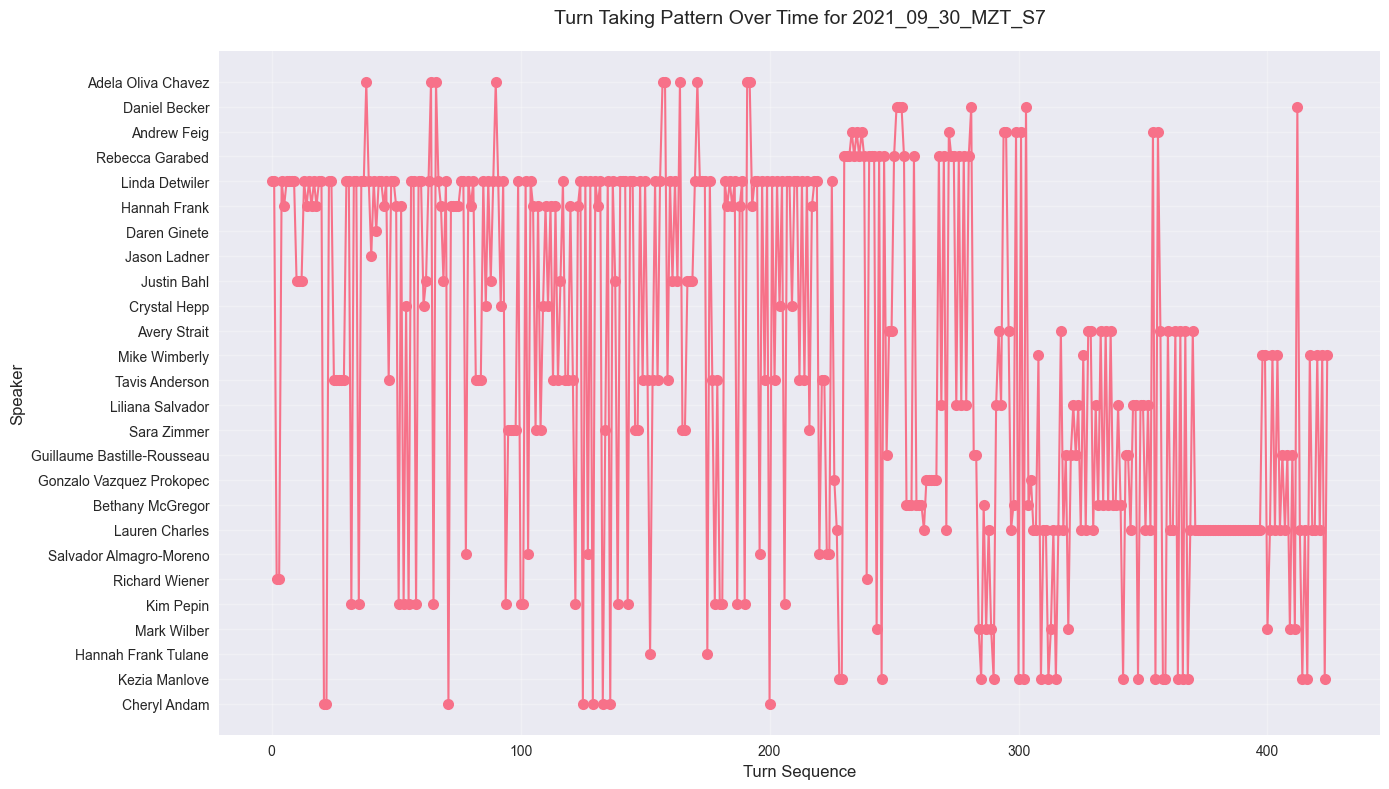

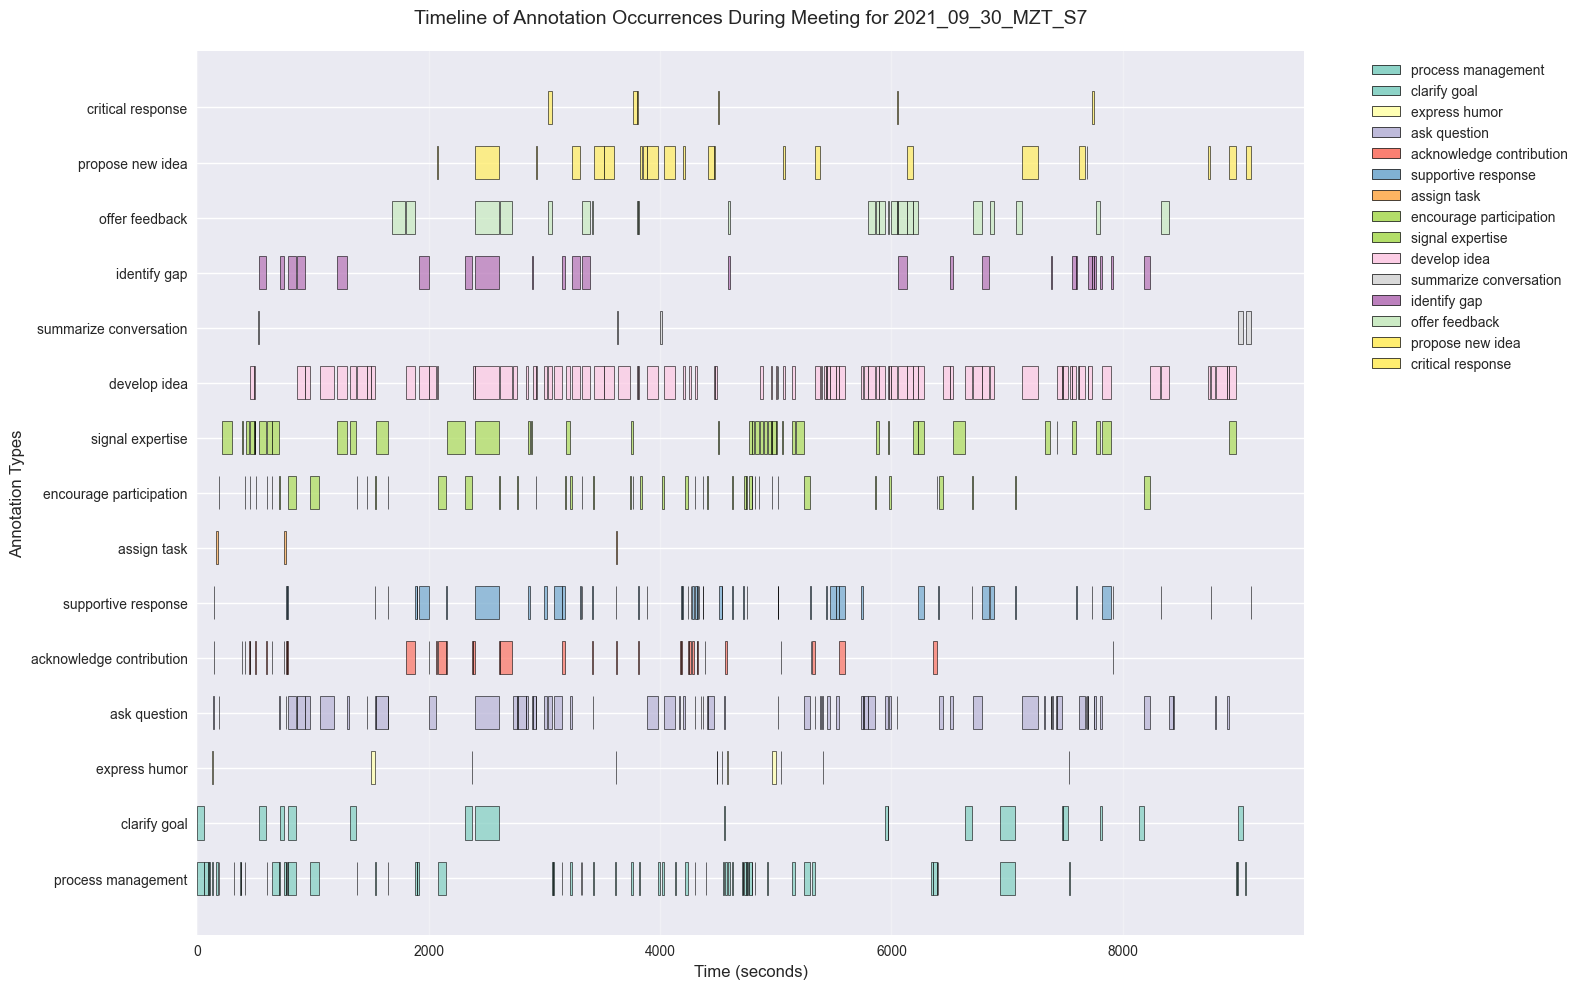

In [ ]:
file_path='/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S7.json'
analyze_meeting(file_path)

### Normalize features

In [43]:
## NORMALIZE features

from sklearn.preprocessing import StandardScaler

# Columns to exclude from normalization
exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Columns to normalize
normalize_columns = [col for col in all_data_df.columns if col not in exclude_columns]

# Fill missing values for normalization
all_data_df_filled = all_data_df.copy()
all_data_df_filled[normalize_columns] = all_data_df_filled[normalize_columns].fillna(0)

# Normalize selected columns
scaler = StandardScaler()
normalized_values = scaler.fit_transform(all_data_df_filled[normalize_columns])

# Create normalized DataFrame
normalized_df = pd.DataFrame(normalized_values, columns=normalize_columns, index=all_data_df.index)

# Combine with excluded columns (keep original values)
for col in exclude_columns:
    normalized_df[col] = all_data_df[col]

# Reorder columns to match original DataFrame
normalized_df = normalized_df[exclude_columns + normalize_columns]

print(normalized_df.head())

  conference             session  num_teams  num_funded_teams  num_members  \
0    2020NES   2020_11_05_NES_S6          2                 0    -0.755433   
1    2020NES   2020_11_06_NES_S1          2                 1    -0.438639   
2    2020NES  2020_11_06_NES_S10          0                 0    -0.438639   
3    2020NES   2020_11_06_NES_S7          2                 0    -0.280241   
4    2020NES   2020_11_05_NES_S1          1                 0    -0.121844   

   meeting_length  num_interruption  percent_time_screenshare  \
0       -2.402382         -0.334146                  3.413476   
1       -1.389008         -0.334146                 -0.757259   
2       -0.986170          0.360878                  3.413476   
3       -1.412193         -0.334146                 -0.757259   
4       -1.054759          0.360878                 -0.757259   

   num_propose_new_idea  num_develop_idea  ...  \
0             -1.342730         -2.214361  ...   
1              0.250166         -0.74700

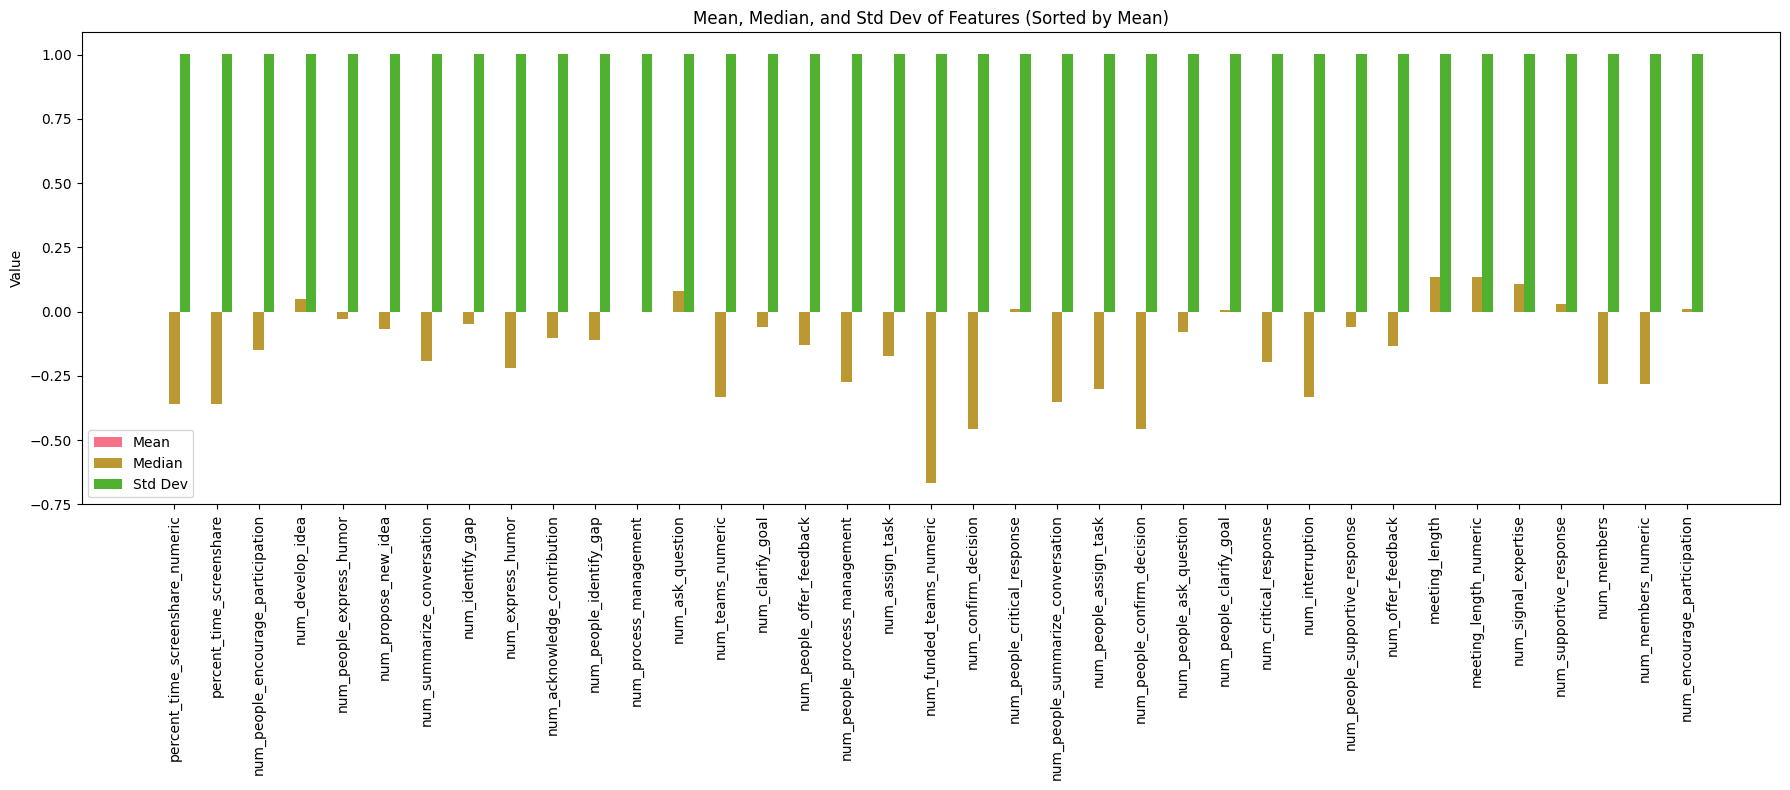

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Columns to exclude
exclude = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Select feature columns
feature_cols = [col for col in normalized_df.columns if col not in exclude]

# Calculate statistics
means = normalized_df[feature_cols].mean()
medians = normalized_df[feature_cols].median()
stds = normalized_df[feature_cols].std()

# Sort features by mean (descending)
sorted_idx = means.sort_values(ascending=False).index
means_sorted = means[sorted_idx]
medians_sorted = medians[sorted_idx]
stds_sorted = stds[sorted_idx]

x = np.arange(len(feature_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, means_sorted, width, label='Mean')
ax.bar(x, medians_sorted, width, label='Median')
ax.bar(x + width, stds_sorted, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(sorted_idx, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (Sorted by Mean)')
ax.legend()
plt.tight_layout()
plt.show()

In [45]:
normalized_df.to_excel('normalized_all_data_df.xlsx', index=False)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


def normalize_features(df):
    """
    Normalize features using StandardScaler and return both original and normalized data.
    """
    # Identify feature columns (exclude metadata columns)
    exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 
                      'has_teams', 'has_funded_teams']
    
    feature_columns = [col for col in df.columns if col not in exclude_columns]
    
    # Select only numeric features
    numeric_features = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Found {len(numeric_features)} numeric features for normalization")
    
    # Handle missing values
    df_clean = df[numeric_features].fillna(0)
    
    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df_clean)
    
    # Create DataFrame with normalized features
    df_normalized = pd.DataFrame(normalized_features, 
                                columns=numeric_features, 
                                index=df.index)
    
    return df_normalized, numeric_features, scaler

### logstic regression (use normalized_df)

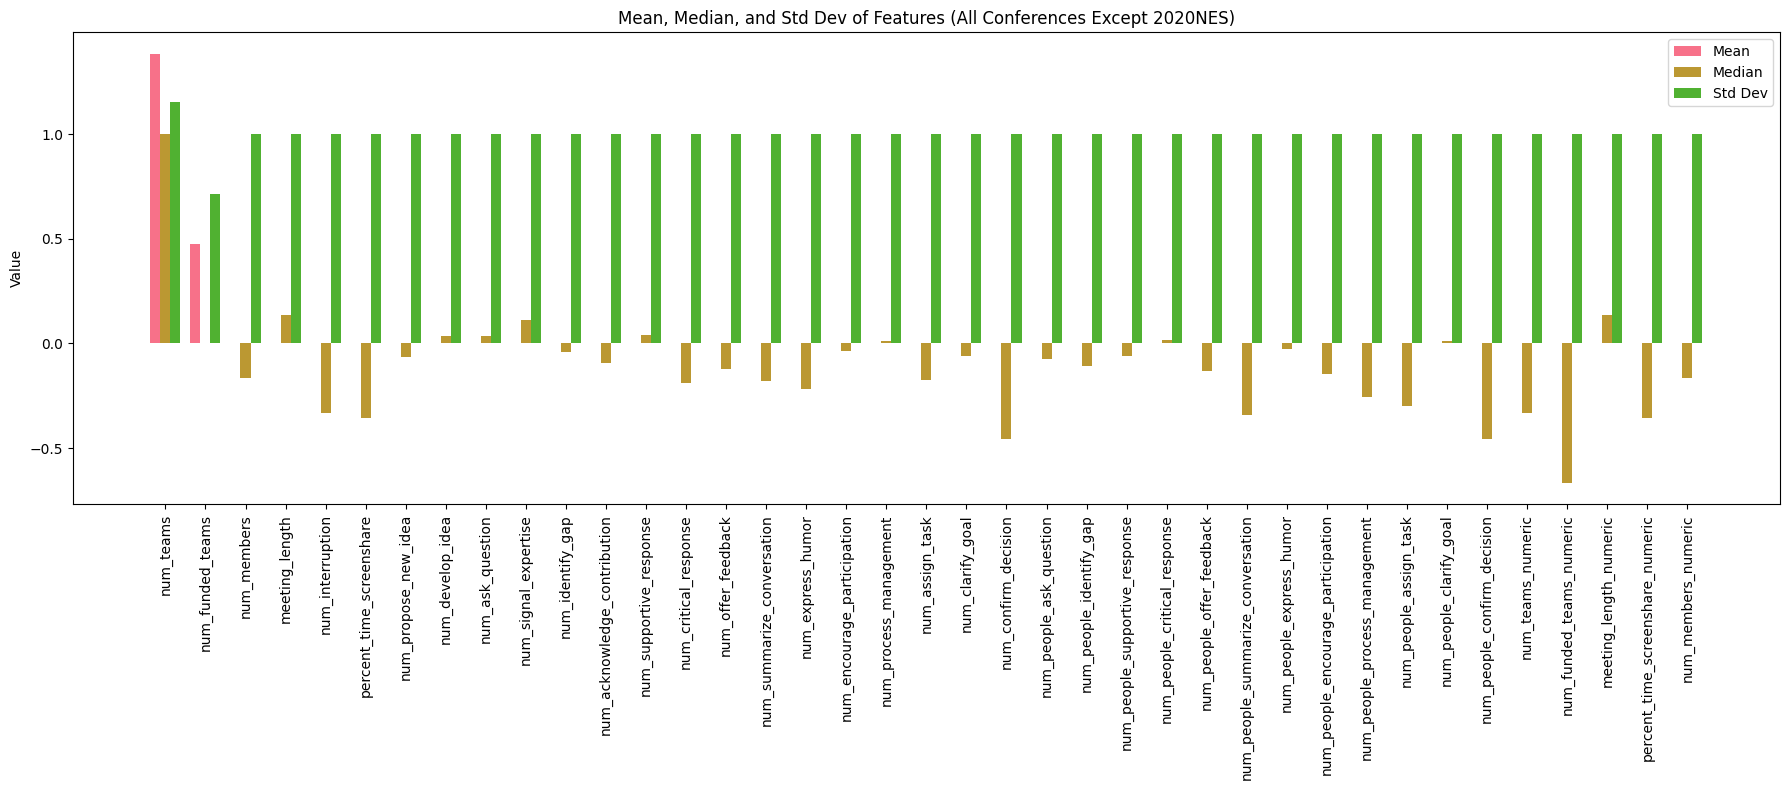

In [39]:
import numpy as np
import matplotlib.pyplot as plt



# Exclude non-numeric columns except 'conference'
numeric_cols = normalized_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate mean, median, std for each column (across all data)
mean_vals = normalized_df[numeric_cols].mean()
median_vals = normalized_df[numeric_cols].median()
std_vals = normalized_df[numeric_cols].std()

# Plotting
x = np.arange(len(numeric_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, mean_vals, width, label='Mean')
ax.bar(x, median_vals, width, label='Median')
ax.bar(x + width, std_vals, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (All Conferences Except 2020NES)')
ax.legend()
plt.tight_layout()
plt.show()


In [46]:
# Check your data distribution
print("Distribution of num_teams:")
print(normalized_df['num_teams'].value_counts().sort_index())

print("\nDistribution of num_funded_teams:")
print(normalized_df['num_funded_teams'].value_counts().sort_index())

Distribution of num_teams:
num_teams
0    39
1    48
2    45
3    22
4     1
8     1
Name: count, dtype: int64

Distribution of num_funded_teams:
num_funded_teams
0    96
1    49
2    10
5     1
Name: count, dtype: int64


In [47]:
# Create binary versions

normalized_df['has_teams'] = (normalized_df['num_teams'] > 0).astype(int)
normalized_df['has_funded_teams'] = (normalized_df['num_funded_teams'] > 0).astype(int)

print("Binary target distributions:")
print("has_teams:")
print(normalized_df['has_teams'].value_counts().sort_index())
print("\nhas_funded_teams:")
print(normalized_df['has_funded_teams'].value_counts().sort_index())

Binary target distributions:
has_teams:
has_teams
0     39
1    117
Name: count, dtype: int64

has_funded_teams:
has_funded_teams
0    96
1    60
Name: count, dtype: int64


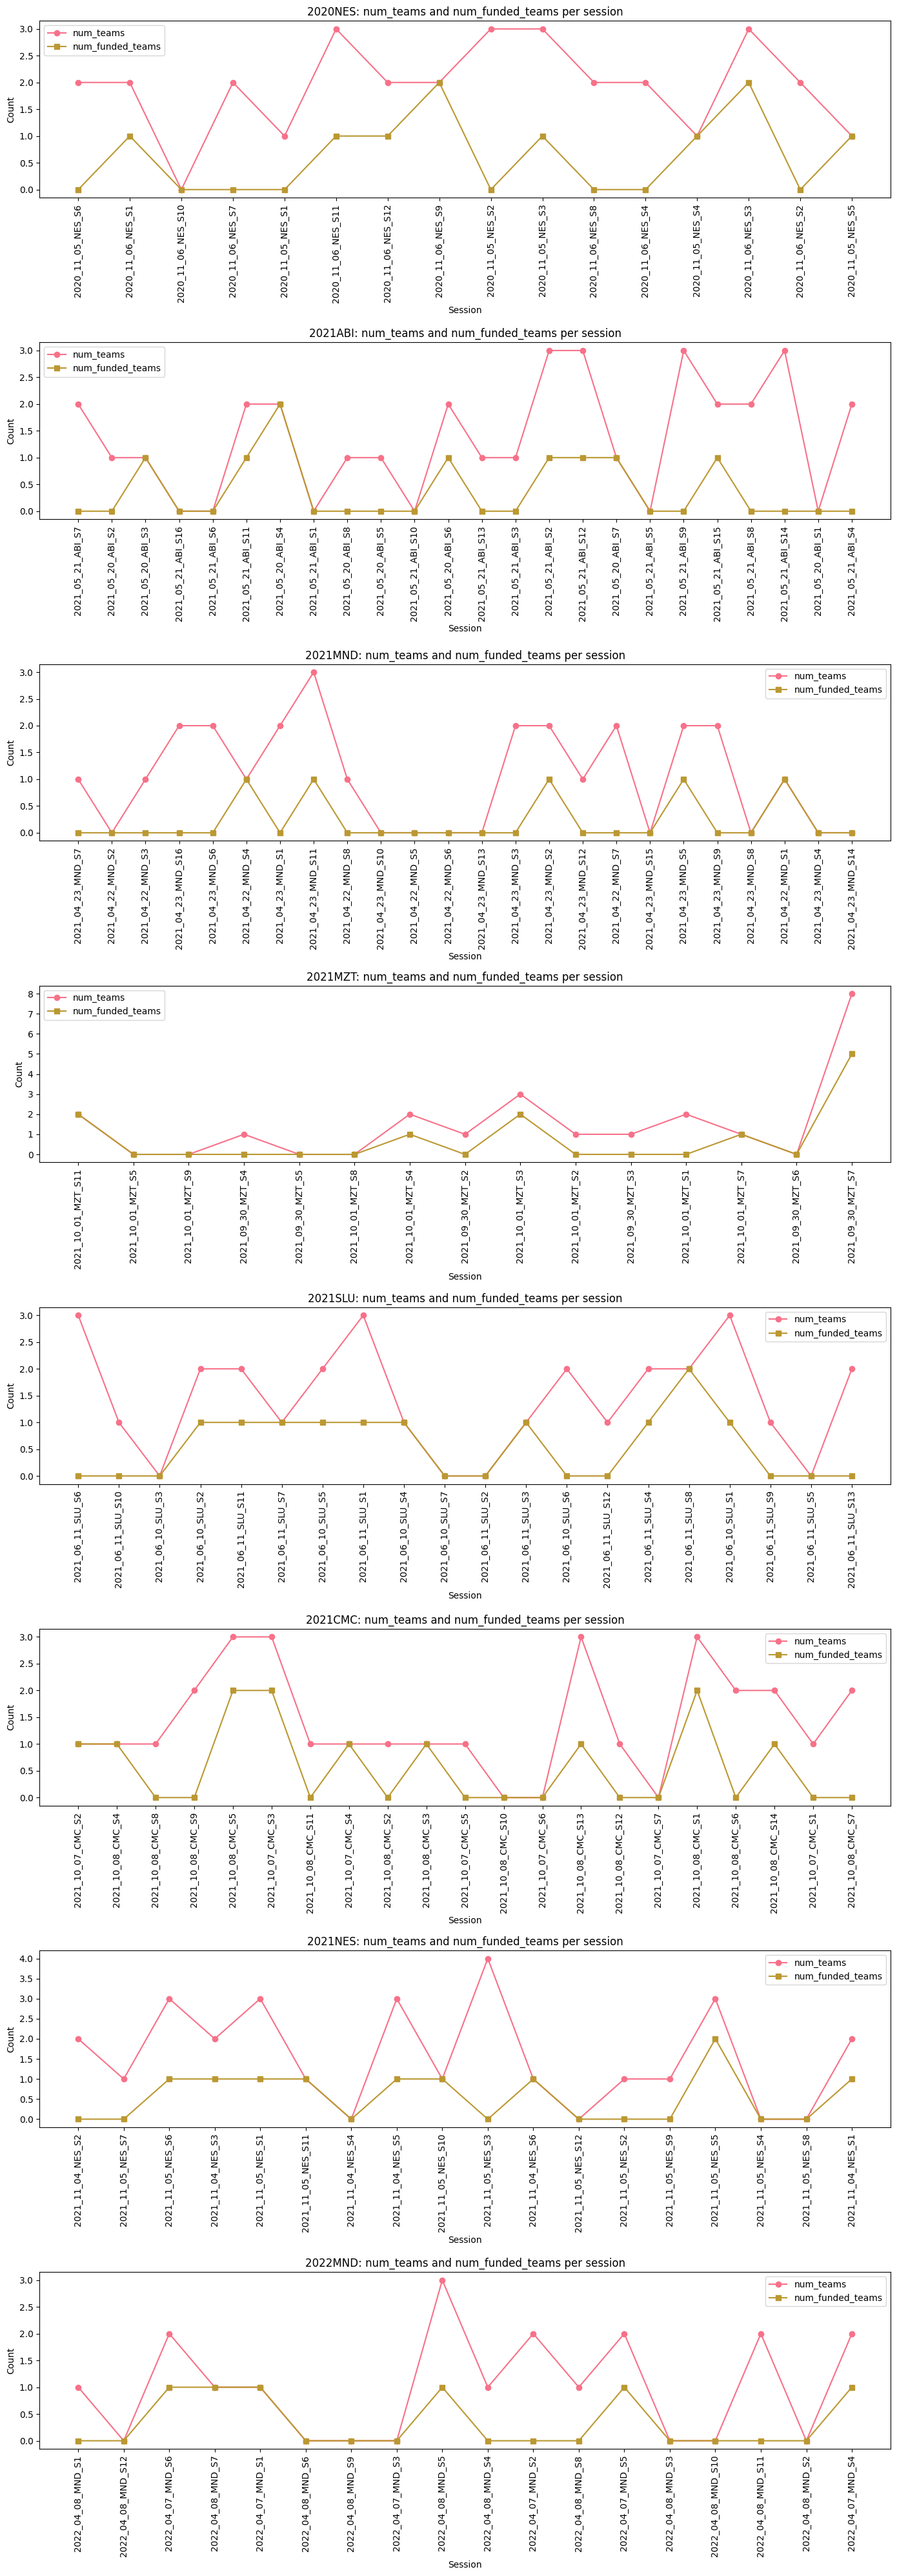

In [42]:
import matplotlib.pyplot as plt

# Get unique conferences
unique_conferences = normalized_df['conference'].unique()

fig, axes = plt.subplots(len(unique_conferences), 1, figsize=(14, 5 * len(unique_conferences)), sharex=False)

if len(unique_conferences) == 1:
    axes = [axes]  # Ensure axes is always iterable

for idx, conf in enumerate(unique_conferences):
    conf_df = normalized_df[normalized_df['conference'] == conf]
    sessions = conf_df['session']
    num_teams = conf_df['num_teams']
    num_funded_teams = conf_df['num_funded_teams']

    ax = axes[idx]
    ax.plot(sessions, num_teams, marker='o', label='num_teams')
    ax.plot(sessions, num_funded_teams, marker='s', label='num_funded_teams')
    ax.set_title(f"{conf}: num_teams and num_funded_teams per session")
    ax.set_xlabel("Session")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels(sessions, rotation=90)

plt.tight_layout()
plt.show()

In [48]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Columns to exclude from multicollinearity analysis
exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
exclude_columns.extend([col for col in all_data_df.columns if col.endswith('_numeric')])
# Select only feature columns
feature_columns = [col for col in normalized_df.columns if col not in exclude_columns]

# Compute correlation matrix
corr_matrix = normalized_df[feature_columns].corr()

# Find pairs with high absolute correlation (> 0.8)
high_corr_pairs = []
threshold = 0.8
for i in range(len(feature_columns)):
    for j in range(i+1, len(feature_columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((feature_columns[i], feature_columns[j], corr_val))

print("Highly correlated feature pairs (|correlation| > 0.8):")
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} <-> {f2}: correlation = {corr_val:.3f}")

# Calculate Variance Inflation Factor (VIF)

X = normalized_df[feature_columns].values
vif_data = pd.DataFrame({
    'feature': feature_columns,
    'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

print("\nVariance Inflation Factor (VIF) for each feature:")
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

# Report features with VIF > 5 (commonly considered problematic)
problematic_vif = vif_data[vif_data['VIF'] > 5]
if not problematic_vif.empty:
    print("\nFeatures with VIF > 5 (potential multicollinearity):")
    print(problematic_vif.sort_values('VIF', ascending=False).to_string(index=False))
else:
    print("\nNo features with VIF > 5 detected.")

Highly correlated feature pairs (|correlation| > 0.8):
num_critical_response <-> num_people_critical_response: correlation = 0.867
num_offer_feedback <-> num_people_offer_feedback: correlation = 0.807
num_confirm_decision <-> num_people_confirm_decision: correlation = 1.000

Variance Inflation Factor (VIF) for each feature:
                           feature      VIF
       num_people_confirm_decision      inf
              num_confirm_decision      inf
    num_people_supportive_response 6.650093
            num_process_management 6.643576
                    meeting_length 6.572578
           num_people_ask_question 5.904497
             num_critical_response 5.811262
                  num_develop_idea 5.796625
                       num_members 5.732015
      num_people_critical_response 5.442650
                  num_clarify_goal 4.953537
           num_people_identify_gap 4.655235
         num_people_offer_feedback 4.573007
     num_people_process_management 4.527241
              

/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def normalize_and_run_logistic_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Normalize features and run logistic regression.
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    # Handle missing values
    X = X.fillna(0)
    
    # Split the data WITHOUT stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state  # Removed stratify=y
    )
    
    # Rest of the function remains the same...
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"Logistic Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance, X_train_scaled_df, X_test_scaled_df
# Usage example:
# model, scaler, importance, X_train_scaled, X_test_scaled = normalize_and_run_logistic_regression(all_data, 'num_funded_teams')

In [ ]:
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

def run_logistic_regression_with_stats_robust(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run logistic regression with robust handling of multicollinearity and perfect separation.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams', 'meeting_length', 'num_members'] and not col.endswith('_numeric')]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Remove low variance features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var_selected = variance_selector.fit_transform(X_train)
    X_test_var_selected = variance_selector.transform(X_test)
    
    # Get selected feature names
    selected_features = [feature_columns[i] for i in range(len(feature_columns)) 
                        if variance_selector.get_support()[i]]
    
    print(f"Original features: {len(feature_columns)}")
    print(f"Features after variance threshold: {len(selected_features)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_var_selected)
    X_test_scaled = scaler.transform(X_test_var_selected)
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train_scaled)
    X_test_with_const = sm.add_constant(X_test_scaled)
    
    # Try different fitting methods
    methods_to_try = ['newton', 'bfgs', 'lbfgs', 'powell', 'cg']
    results = None
    
    for method in methods_to_try:
        try:
            print(f"Trying method: {method}")
            model = sm.Logit(y_train, X_train_with_const)
            results = model.fit(method=method, maxiter=1000, disp=0)
            print(f"Success with method: {method}")
            break
        except Exception as e:
            print(f"Method {method} failed: {str(e)[:100]}...")
            continue
    
    if results is None:
        print("All methods failed. Trying with regularization...")
        # Use sklearn with regularization as fallback
        from sklearn.linear_model import LogisticRegression 
        sklearn_model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=random_state)
        sklearn_model.fit(X_train_scaled, y_train)
        
        # Create a mock results object for reporting
        class MockResults:
            def __init__(self, model, feature_names):
                self.params = np.concatenate([[0], model.coef_[0]])  # Add intercept
                self.pvalues = np.ones(len(self.params))  # Placeholder p-values
                self.bse = np.ones(len(self.params)) * 0.1  # Placeholder std errors
                self.tvalues = self.params / self.bse
                self.summary = lambda: print("Using sklearn with L2 regularization (no p-values available)")
        
        results = MockResults(sklearn_model, selected_features)
        y_pred_proba = sklearn_model.predict_proba(X_test_scaled)[:, 1]
        y_pred = sklearn_model.predict(X_test_scaled)
    else:
        # Get predictions for sklearn metrics
        y_pred_proba = results.predict(X_test_with_const)
        y_pred = (y_pred_proba > 0.5).astype(int)
    
    print(f"\nLogistic Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"Accuracy: {(y_pred == y_test).mean():.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    try:
        print(results.summary())
    except:
        print("Summary not available (using sklearn fallback)")
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + selected_features
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    z_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        'z_score': z_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    if len(significant_features) > 0:
        print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features significant at p < 0.05")
    
    return results, results_df, scaler, selected_features

In [47]:
def visualize_logistic_features(df, target_column, top_n=10, save_plots=False):
    """
    Create comprehensive visualizations of logistic regression feature importance.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    top_n : int
        Number of top features to show in plots
    save_plots : bool
        Whether to save plots to files
    """
    
    print(f"Running logistic regression for target: {target_column}")
    print("=" * 60)
    
    # Run logistic regression
    results, coef_df, scaler, selected_features = run_logistic_regression_with_stats_robust(df, target_column)
    
    # Remove intercept for visualization
    feature_df = coef_df[coef_df['feature'] != 'intercept'].copy()
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Coefficient Magnitude Plot (Top N features)
    plt.subplot(2, 3, 1)
    top_features = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Most Predictive Features\n(Red=Negative, Blue=Positive)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add coefficient values on bars
    for i, (bar, coef) in enumerate(zip(bars, top_features['coefficient'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{coef:.3f}', va='center', fontsize=9)
    
    # 2. Coefficient Direction Plot
    plt.subplot(2, 3, 2)
    top_features_signed = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features_signed['coefficient']]
    bars = plt.barh(range(len(top_features_signed)), top_features_signed['coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features_signed)), top_features_signed['feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Feature Effects on {target_column}\n(Red=Decreases, Blue=Increases)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    
    # 3. Statistical Significance Plot (if available)
    plt.subplot(2, 3, 3)
    if not feature_df['p_value'].isna().all():
        significant_features = feature_df[feature_df['p_value'] < 0.05].nlargest(top_n, 'abs_coefficient')
        if len(significant_features) > 0:
            colors = ['red' if x < 0 else 'blue' for x in significant_features['coefficient']]
            bars = plt.barh(range(len(significant_features)), significant_features['abs_coefficient'], color=colors, alpha=0.7)
            
            plt.yticks(range(len(significant_features)), significant_features['feature'], fontsize=10)
            plt.xlabel('Absolute Coefficient Value', fontsize=12)
            plt.title(f'Statistically Significant Features\n(p < 0.05)', fontsize=14, fontweight='bold')
            plt.grid(axis='x', alpha=0.3)
            
            # Add p-values on bars
            for i, (bar, p_val) in enumerate(zip(bars, significant_features['p_value'])):
                plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'p={p_val:.3f}', va='center', fontsize=9)
        else:
            plt.text(0.5, 0.5, 'No significant features\n(p < 0.05)', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=14)
            plt.title('Statistically Significant Features', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Statistical Significance', fontsize=14, fontweight='bold')
    
    # 4. Coefficient vs P-value Scatter Plot (if available)
    plt.subplot(2, 3, 4)
    if not feature_df['p_value'].isna().all():
        plt.scatter(feature_df['coefficient'], -np.log10(feature_df['p_value']), alpha=0.6, s=50)
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('-log10(p-value)', fontsize=12)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
        plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Label top features
        top_features_scatter = feature_df.nlargest(5, 'abs_coefficient')
        for _, row in top_features_scatter.iterrows():
            plt.annotate(row['feature'], (row['coefficient'], -np.log10(row['p_value'])), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
    

    
    # 5. Coefficient Distribution
    plt.subplot(2, 3, 5)
    plt.hist(feature_df['coefficient'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Feature Coefficients', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero effect')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'logistic_regression_features_{target_column}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: logistic_regression_features_{target_column}.png")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS:")
    print("=" * 60)
    print(f"Total features analyzed: {len(feature_df)}")
    print(f"Positive coefficients: {len(feature_df[feature_df['coefficient'] > 0])}")
    print(f"Negative coefficients: {len(feature_df[feature_df['coefficient'] < 0])}")
    
    if not feature_df['p_value'].isna().all():
        significant_count = len(feature_df[feature_df['p_value'] < 0.05])
        print(f"Statistically significant (p < 0.05): {significant_count}")
        print(f"Highly significant (p < 0.01): {len(feature_df[feature_df['p_value'] < 0.01])}")
    
    print(f"Mean absolute coefficient: {feature_df['abs_coefficient'].mean():.4f}")
    print(f"Max absolute coefficient: {feature_df['abs_coefficient'].max():.4f}")
    
    return results, coef_df, scaler, selected_features

Running logistic regression for target: has_teams
Original features: 32
Features after variance threshold: 32
Trying method: newton
Success with method: newton

Logistic Regression Results for has_teams
Training samples: 124
Test samples: 32
ROC AUC: 0.589
Accuracy: 0.688

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:              has_teams   No. Observations:                  124
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                           31
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.5912
Time:                        17:17:03   Log-Likelihood:                -28.509
converged:                       True   LL-Null:                       -69.730
Covariance Type:            nonrobust   LLR p-value:                 1.488e-06
                 coef    std err          z      P>|z|      [0.025      0

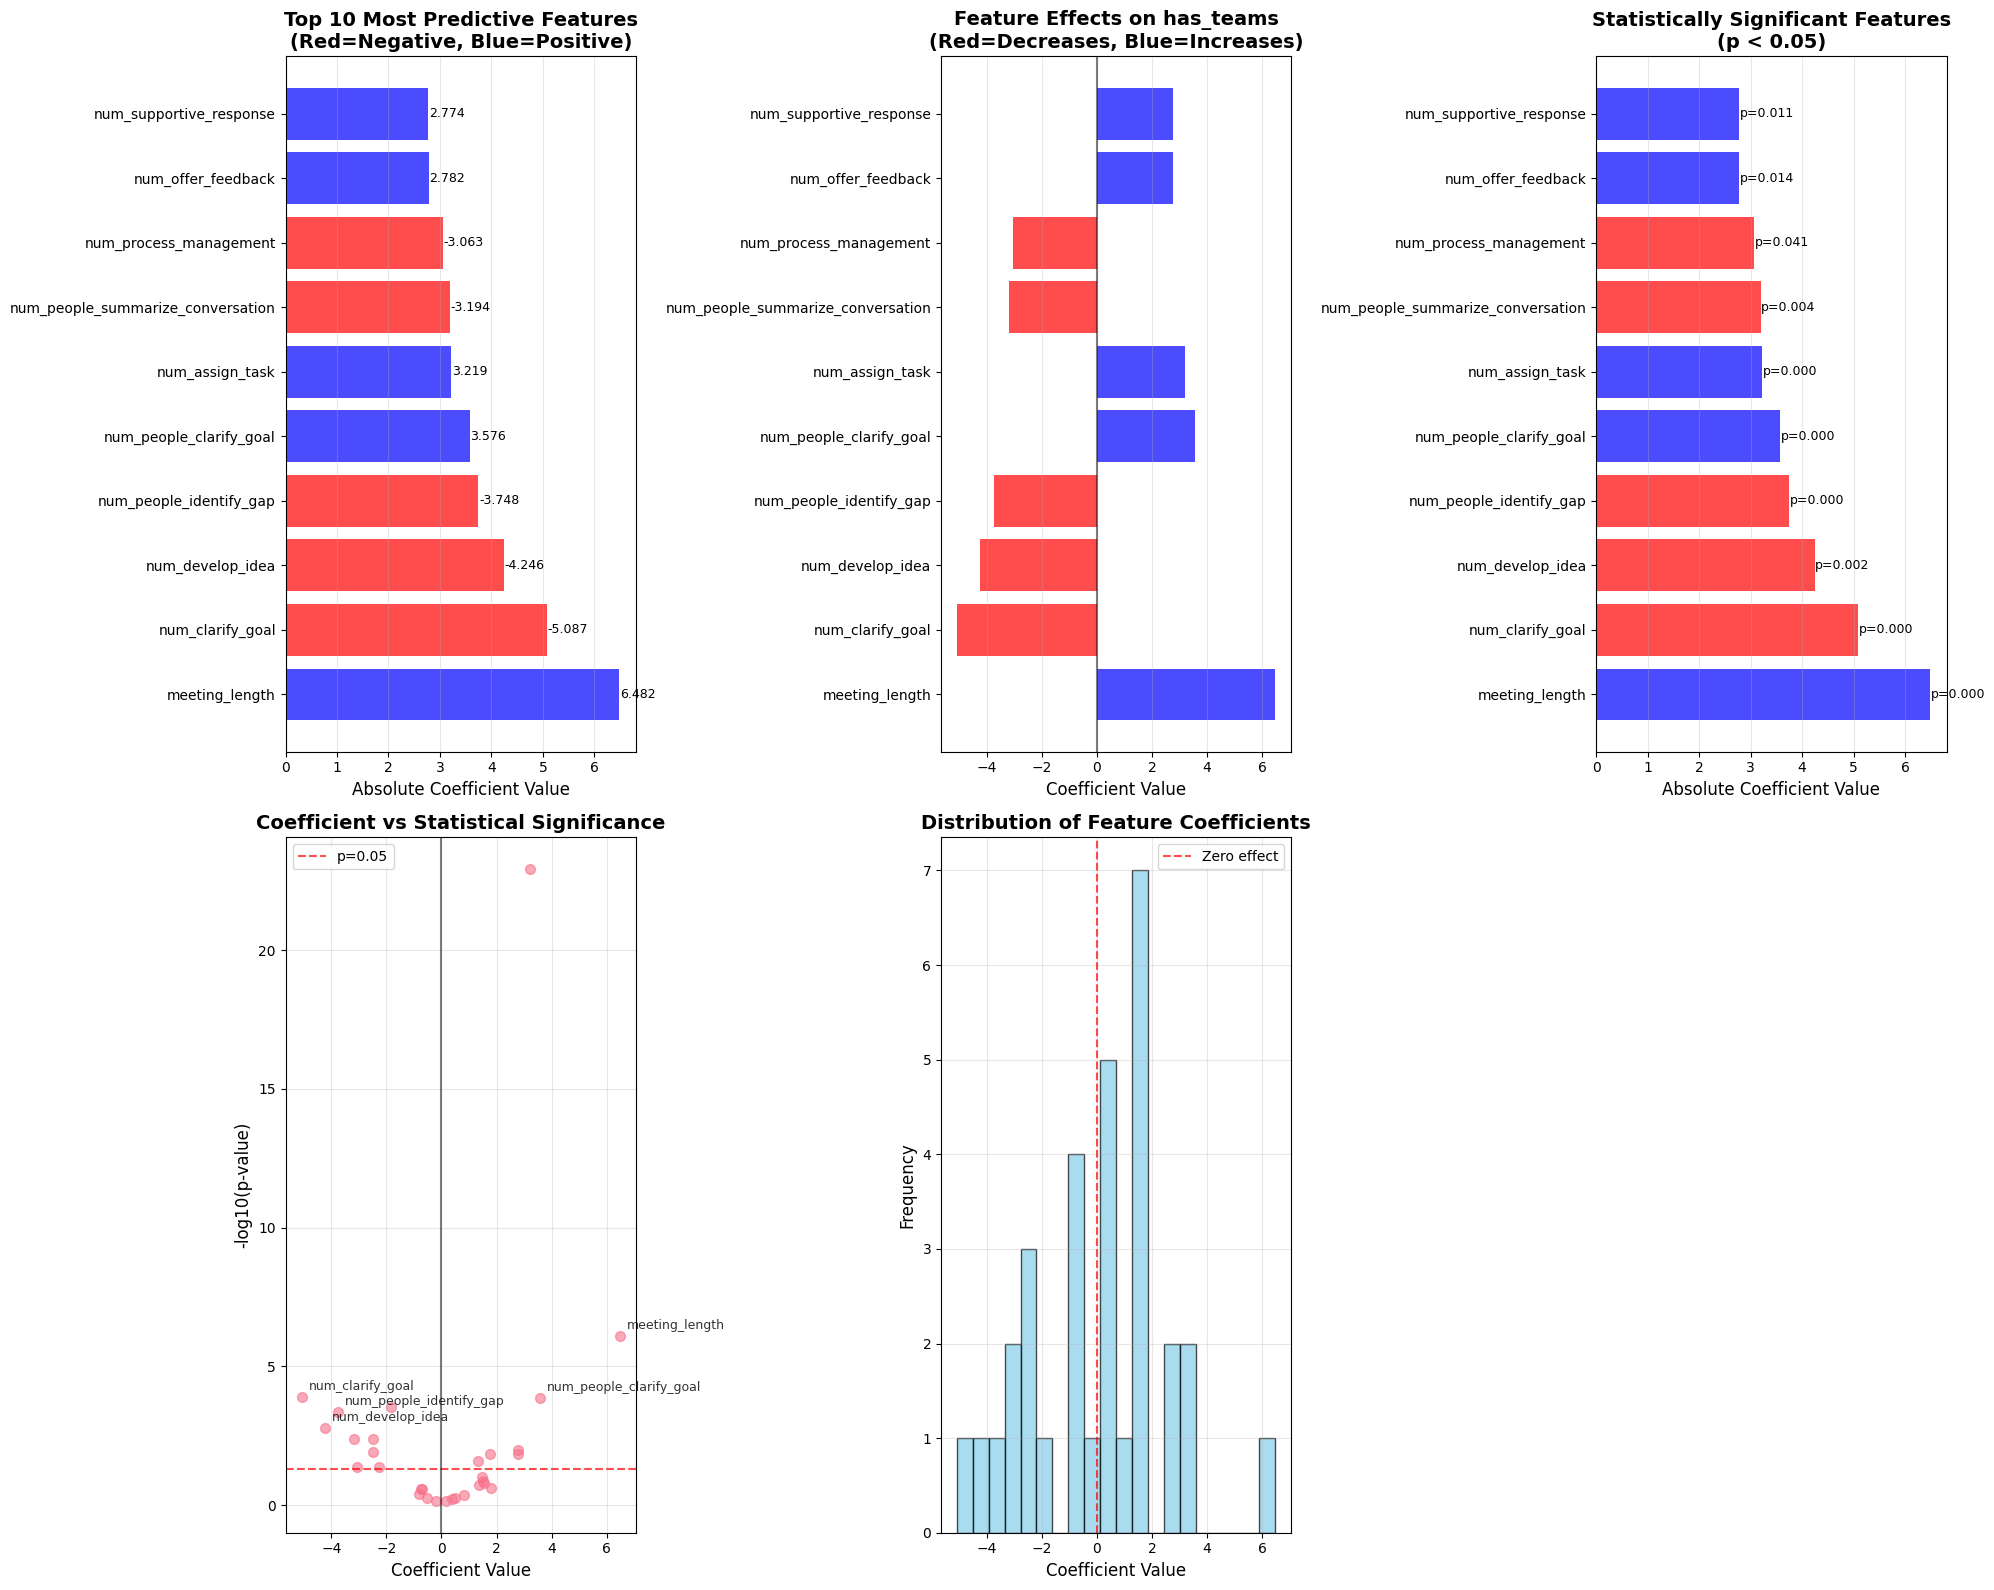


SUMMARY STATISTICS:
Total features analyzed: 32
Positive coefficients: 18
Negative coefficients: 14
Statistically significant (p < 0.05): 16
Highly significant (p < 0.01): 9
Mean absolute coefficient: 1.9836
Max absolute coefficient: 6.4824


In [52]:
df = normalized_df

target = 'has_teams'  
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

Running logistic regression for target: has_funded_teams
Original features: 32
Features after variance threshold: 32
Trying method: newton
Success with method: newton

Logistic Regression Results for has_funded_teams
Training samples: 124
Test samples: 32
ROC AUC: 0.596
Accuracy: 0.562

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:       has_funded_teams   No. Observations:                  124
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                           31
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.2990
Time:                        17:18:38   Log-Likelihood:                -56.941
converged:                       True   LL-Null:                       -81.229
Covariance Type:            nonrobust   LLR p-value:                   0.02315
                 coef    std err          z      P>|z|     

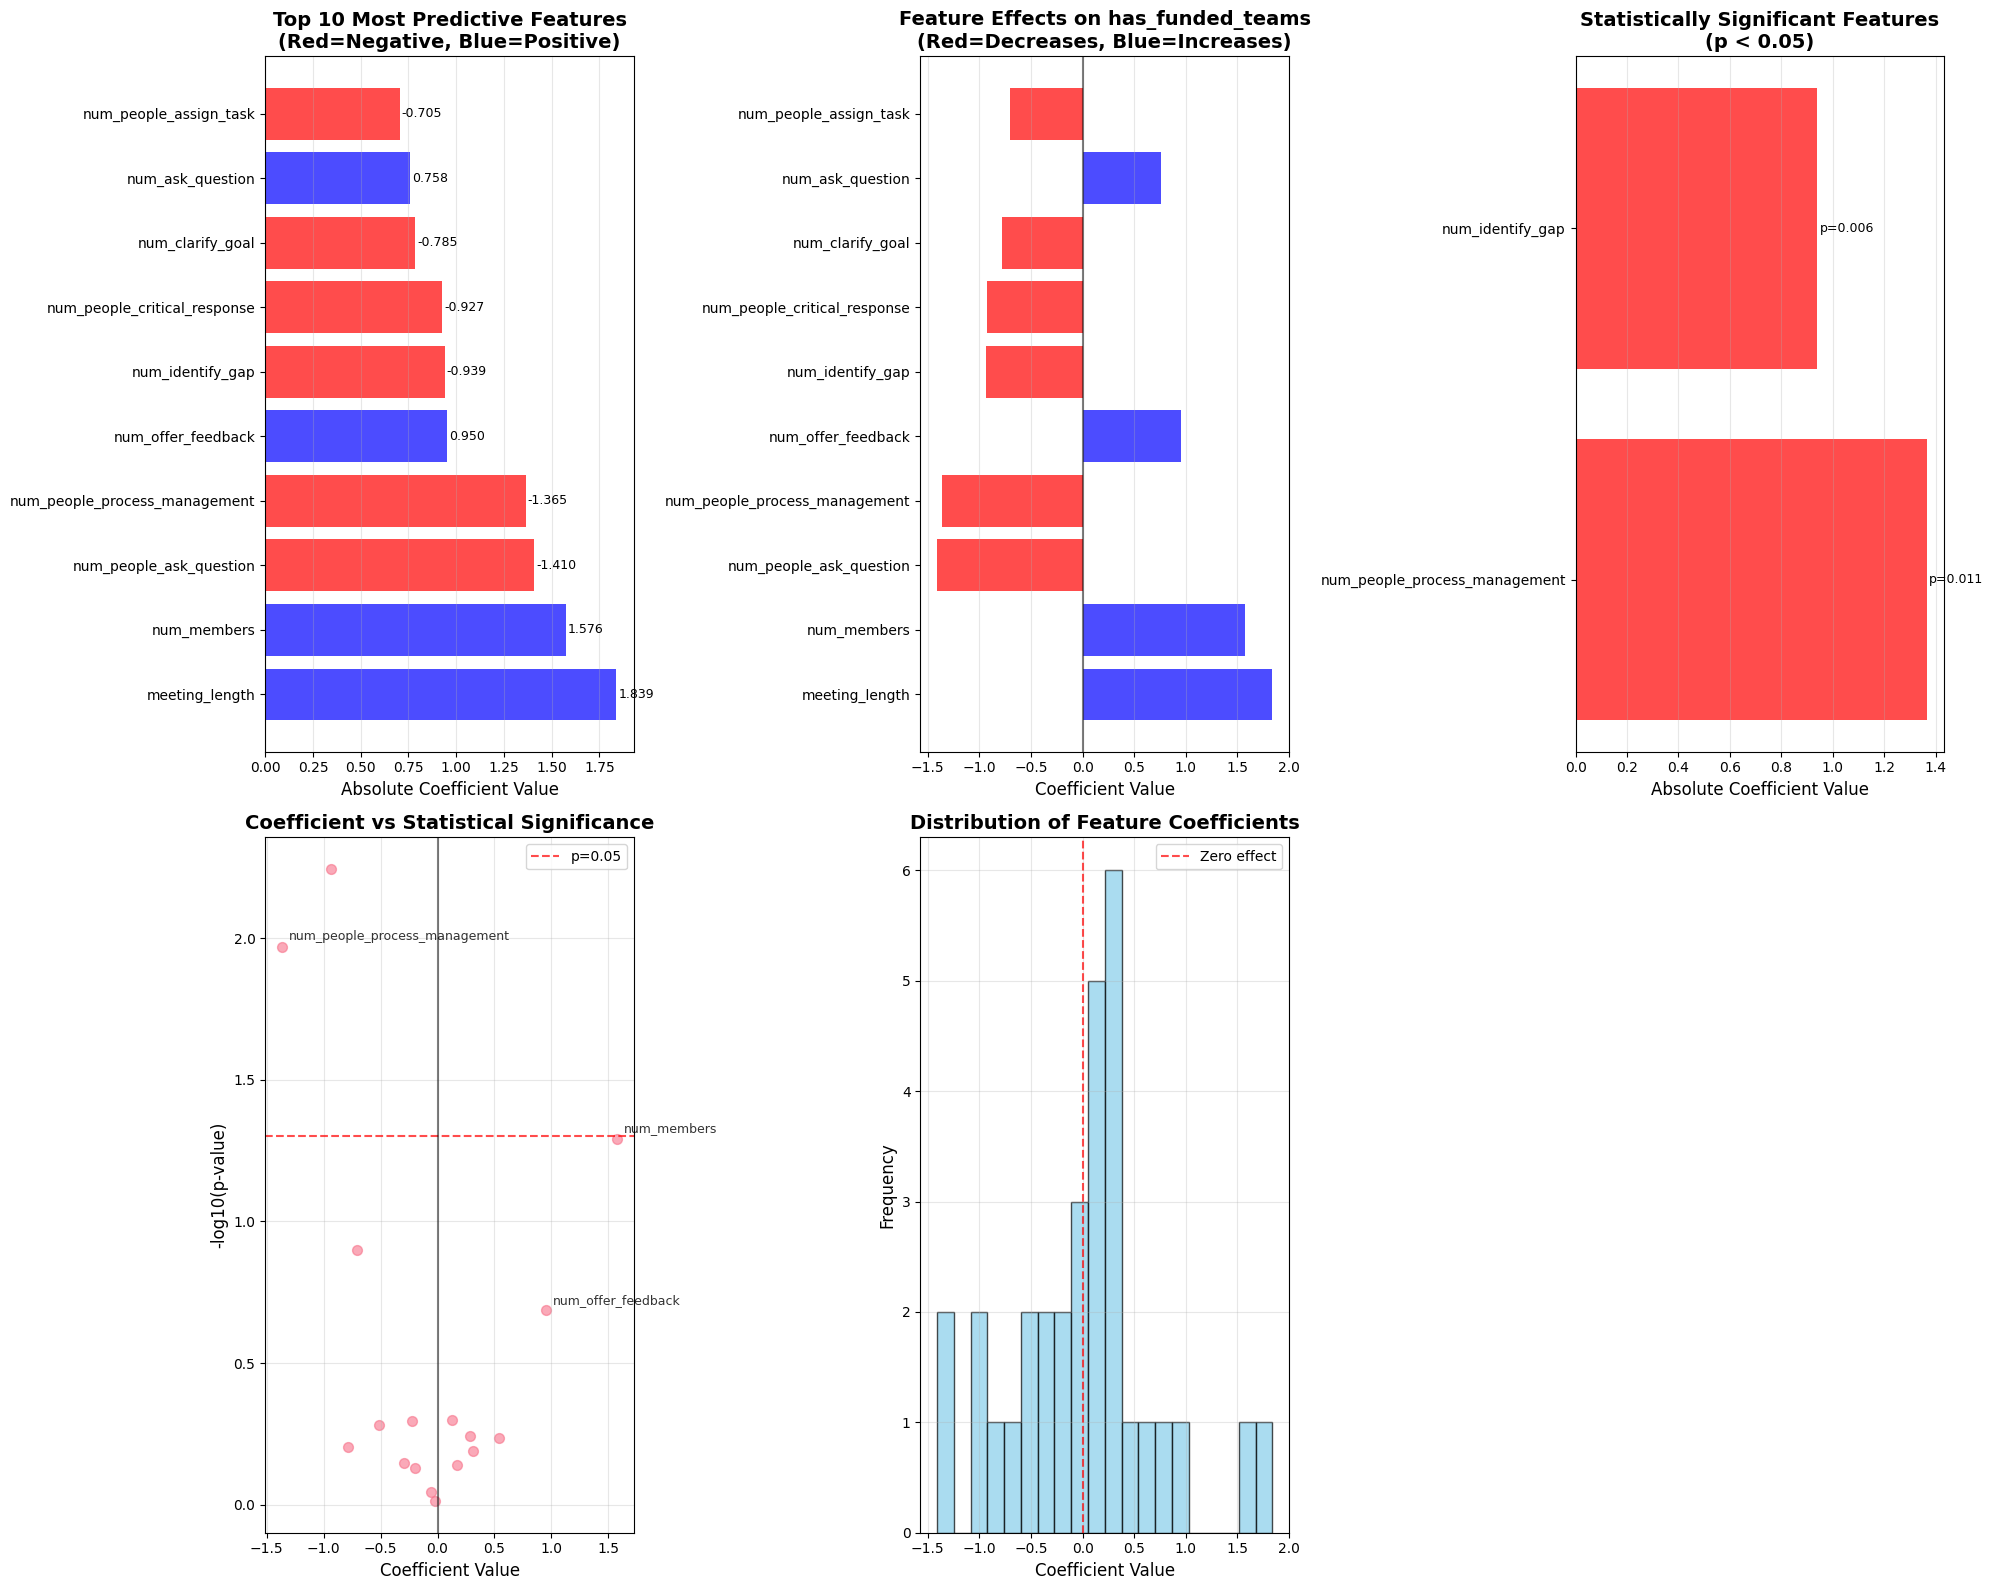


SUMMARY STATISTICS:
Total features analyzed: 32
Positive coefficients: 17
Negative coefficients: 15
Statistically significant (p < 0.05): 2
Highly significant (p < 0.01): 1
Mean absolute coefficient: 0.5322
Max absolute coefficient: 1.8387


In [53]:
df = normalized_df
target = 'has_funded_teams'  # Change this to your target variable
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

### Linear regression (use all_data_df)

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import statsmodels.api as sm
from scipy import stats
import numpy as np

import statsmodels.api as sm
from scipy import stats
import numpy as np


def run_linear_regression_with_stats(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run linear regression with statistical significance testing using statsmodels.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams'] and not col.endswith('_numeric')]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)
    
    # Fit linear regression with statsmodels
    model = sm.OLS(y_train, X_train_with_const)
    results = model.fit()
    
    # Get predictions
    y_pred = results.predict(X_test_with_const)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"F-statistic p-value: {results.f_pvalue:.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    print(results.summary())
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + feature_columns
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    t_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        't_score': t_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    
    return results, results_df, scaler

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def run_linear_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """Run linear regression for continuous targets."""
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    
    X_train_scaled_df = pd.DataFrame(X_train, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test, columns=feature_columns, index=X_test.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_,
        'abs_coefficient': np.abs(model.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance



In [58]:
# Run linear regression
print("Predicting num_teams (regression):")
model1, scaler1, importance1 = run_linear_regression_with_stats(all_data_df, 'num_teams')



Predicting num_teams (regression):
Linear Regression Results for num_teams
Training samples: 124
Test samples: 32
R² Score: 0.221
Adjusted R²: 0.083
F-statistic: 1.360
F-statistic p-value: 0.132

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:              num_teams   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.360
Date:                Wed, 27 Aug 2025   Prob (F-statistic):              0.132
Time:                        17:26:24   Log-Likelihood:                -157.10
No. Observations:                 124   AIC:                             378.2
Df Residuals:                      92   BIC:                             468.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                   

In [59]:
print("\nPredicting num_funded_teams (regression):")
model2, scaler2, importance2 = run_linear_regression_with_stats(all_data_df, 'num_funded_teams')


Predicting num_funded_teams (regression):
Linear Regression Results for num_funded_teams
Training samples: 124
Test samples: 32
R² Score: 0.174
Adjusted R²: 0.088
F-statistic: 1.385
F-statistic p-value: 0.119

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     1.385
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.119
Time:                        15:26:17   Log-Likelihood:                -91.186
No. Observations:                 124   AIC:                             246.4
Df Residuals:                      92   BIC:                             336.6
Df Model:                          31                                         
Covariance Type:            nonrobust                    

### Regularization and control variables for logistic regression


In [51]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# L1 Regularization (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

# L2 Regularization (Ridge) 
ridge_model = LogisticRegression(penalty='l2', C=1.0, random_state=42)

# For linear regression
lasso_linear = Lasso(alpha=1.0, random_state=42)
ridge_linear = Ridge(alpha=1.0, random_state=42)




In [130]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def find_optimal_regularization(all_data_df, target_column, control_variables=None, 
                              regularization='l2', C_range=None, cv=5):
    """
    Find optimal regularization strength using cross-validation.
    
    Parameters:
    - all_data_df: DataFrame with features and target
    - target_column: Name of the target variable
    - control_variables: List of control variable names
    - regularization: 'l1' or 'l2'
    - C_range: Range of C values to test (if None, uses default range)
    - cv: Number of cross-validation folds
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    if control_variables:
        feature_columns = [col for col in feature_columns if col not in control_variables]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    X = X.fillna(0)
    
    # Handle control variables by residualization
    if control_variables:
        print("Residualizing features against control variables...")
        controls = all_data_df[control_variables].fillna(0)
        
        X_residualized = X.copy()
        for feature in feature_columns:
            lr = LinearRegression()
            lr.fit(controls, X[feature])
            X_residualized[feature] = X[feature] - lr.predict(controls)
        X = X_residualized
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Set up C range if not provided
    if C_range is None:
        if regularization == 'l1':
            C_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        else:  # l2
            C_range = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    
    # Set up parameter grid
    param_grid = {'C': C_range}
    
    # Choose solver based on regularization
    solver = 'liblinear' if regularization == 'l1' else 'lbfgs'
    
    # Grid search with cross-validation
    print(f"Finding optimal {regularization.upper()} regularization strength...")
    print(f"Testing C values: {C_range}")
    
    grid_search = GridSearchCV(
        LogisticRegression(penalty=regularization, solver=solver, random_state=42, max_iter=1000),
        param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_scaled, y)
    
    print(f"\nBest C value: {grid_search.best_params_['C']}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Cross-validation scores
    plt.subplot(1, 2, 1)
    cv_scores = grid_search.cv_results_['mean_test_score']
    cv_stds = grid_search.cv_results_['std_test_score']
    
    plt.semilogx(C_range, cv_scores, 'o-', linewidth=2, markersize=8)
    plt.fill_between(C_range, cv_scores - cv_stds, cv_scores + cv_stds, alpha=0.3)
    plt.axvline(grid_search.best_params_['C'], color='red', linestyle='--', 
                label=f'Best C = {grid_search.best_params_["C"]}')
    plt.xlabel('C (Regularization Strength)', fontsize=12)
    plt.ylabel('Cross-validation ROC AUC', fontsize=12)
    plt.title(f'{regularization.upper()} Regularization Tuning', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Number of non-zero coefficients vs C
    plt.subplot(1, 2, 2)
    non_zero_counts = []
    
    for C in C_range:
        model = LogisticRegression(penalty=regularization, C=C, solver=solver, 
                                 random_state=42, max_iter=1000)
        model.fit(X_scaled, y)
        non_zero_count = np.sum(np.abs(model.coef_[0]) > 1e-6)  # Count non-zero coefficients
        non_zero_counts.append(non_zero_count)
    
    plt.semilogx(C_range, non_zero_counts, 'o-', linewidth=2, markersize=8, color='green')
    plt.axvline(grid_search.best_params_['C'], color='red', linestyle='--', 
                label=f'Best C = {grid_search.best_params_["C"]}')
    plt.xlabel('C (Regularization Strength)', fontsize=12)
    plt.ylabel('Number of Non-zero Coefficients', fontsize=12)
    plt.title('Model Sparsity vs Regularization', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return grid_search.best_params_['C'], grid_search

def diagnose_regularization_issues(feature_importance, target_column):
    """
    Diagnose potential issues with regularization that might cause too few features to have predictive power.
    """
    
    print(f"\n{'='*60}")
    print("REGULARIZATION DIAGNOSIS")
    print(f"{'='*60}")
    
    # Count non-zero coefficients
    non_zero_coefs = feature_importance[feature_importance['abs_coefficient'] > 1e-6]
    zero_coefs = feature_importance[feature_importance['abs_coefficient'] <= 1e-6]
    
    print(f"Total features: {len(feature_importance)}")
    print(f"Non-zero coefficients: {len(non_zero_coefs)}")
    print(f"Zero coefficients: {len(zero_coefs)}")
    print(f"Sparsity: {len(zero_coefs)/len(feature_importance)*100:.1f}%")
    
    if len(non_zero_coefs) < 5:
        print("\n⚠️  WARNING: Very few features have predictive power!")
        print("This might indicate:")
        print("1. Regularization is too strong (C too small)")
        print("2. Features are highly correlated")
        print("3. Target variable has low variance")
        print("4. Sample size is too small")
        
        print("\nRecommendations:")
        print("1. Try weaker regularization (larger C values)")
        print("2. Check feature correlations")
        print("3. Verify target variable distribution")
        print("4. Use cross-validation to find optimal C")
    
    # Show coefficient statistics
    print(f"\nCoefficient Statistics:")
    print(f"Mean absolute coefficient: {feature_importance['abs_coefficient'].mean():.6f}")
    print(f"Max absolute coefficient: {feature_importance['abs_coefficient'].max():.6f}")
    print(f"Min absolute coefficient: {feature_importance['abs_coefficient'].min():.6f}")
    
    # Show top features
    print(f"\nTop 5 features by absolute coefficient:")
    top_features = feature_importance.nlargest(5, 'abs_coefficient')
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['coefficient']:.6f}")
    
    return len(non_zero_coefs), len(zero_coefs)

def normalize_and_run_logistic_regression(all_data_df, target_column, control_variables=None, 
                                        regularization='l2', C=1.0, test_size=0.2, random_state=42,
                                        diagnose=True):
    """
    Normalize features and run logistic regression with optional control variables and regularization.
    
    Parameters:
    - all_data_df: DataFrame with features and target
    - target_column: Name of the target variable
    - control_variables: List of control variable names (e.g., ['num_members', 'meeting_length'])
    - regularization: 'l1' (Lasso) or 'l2' (Ridge) regularization
    - C: Inverse of regularization strength (smaller C = stronger regularization)
    - test_size: Proportion of data for testing
    - random_state: Random seed for reproducibility
    - diagnose: Whether to run regularization diagnosis
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    # If control variables are specified, remove them from features (they'll be handled separately)
    if control_variables:
        feature_columns = [col for col in feature_columns if col not in control_variables]
        print(f"Control variables: {control_variables}")
        print(f"Features (excluding controls): {len(feature_columns)}")
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    # Handle missing values
    X = X.fillna(0)
    
    # Split the data WITHOUT stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Handle control variables
    if control_variables:
        # Method 1: Residualize features against control variables
        print("\nResidualizing features against control variables...")
        
        # Get control variables data
        controls_train = all_data_df.loc[X_train.index, control_variables].fillna(0)
        controls_test = all_data_df.loc[X_test.index, control_variables].fillna(0)
        
        # Residualize each feature against control variables
        X_train_residualized = X_train.copy()
        X_test_residualized = X_test.copy()
        
        for feature in feature_columns:
            # Fit linear regression: feature ~ controls
            lr = LinearRegression()
            lr.fit(controls_train, X_train[feature])
            
            # Get residuals
            X_train_residualized[feature] = X_train[feature] - lr.predict(controls_train)
            X_test_residualized[feature] = X_test[feature] - lr.predict(controls_test)
        
        X_train = X_train_residualized
        X_test = X_test_residualized
        
        print("Features have been residualized against control variables.")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    # Fit logistic regression with regularization
    penalty = 'l1' if regularization == 'l1' else 'l2'
    solver = 'liblinear' if regularization == 'l1' else 'lbfgs'  # liblinear works better with L1
    
    print(f"\nUsing {regularization.upper()} regularization with C={C}")
    
    model = LogisticRegression(penalty=penalty, C=C, solver=solver, random_state=random_state, max_iter=1000)
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"\nLogistic Regression Results for {target_column}")
    print("=" * 50)
    if control_variables:
        print(f"Control variables: {control_variables}")
    print(f"Regularization: {regularization.upper()}, C={C}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    # Run diagnosis if requested
    if diagnose:
        diagnose_regularization_issues(feature_importance, target_column)
    
    return model, scaler, feature_importance, X_train_scaled_df, X_test_scaled_df, y_train, y_test

def run_logistic_regression_with_controls(all_data_df, target_column, control_variables=None, 
                                        regularization='l2', C=1.0, test_size=0.2, random_state=42):
    """
    Alternative method: Include control variables directly in the logistic regression model.
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    # Handle missing values
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    # Fit logistic regression with regularization
    penalty = 'l1' if regularization == 'l1' else 'l2'
    solver = 'liblinear' if regularization == 'l1' else 'lbfgs'
    
    print(f"\nUsing {regularization.upper()} regularization with C={C}")
    
    model = LogisticRegression(penalty=penalty, C=C, solver=solver, random_state=random_state, max_iter=1000)
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"\nLogistic Regression Results for {target_column}")
    print("=" * 50)
    if control_variables:
        print(f"Control variables included in model: {control_variables}")
    print(f"Regularization: {regularization.upper()}, C={C}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    # Show control variable coefficients if they exist
    if control_variables:
        control_importance = feature_importance[feature_importance['feature'].isin(control_variables)]
        if not control_importance.empty:
            print("\nControl Variable Coefficients:")
            print(control_importance)
    
    return model, scaler, feature_importance, X_train_scaled_df, X_test_scaled_df, y_train, y_test

def visualize_logistic_features(feature_importance, target_column, top_n=10, save_plots=False, 
                              regularization='l2', C=1.0, control_variables=None, 
                              X_train_scaled_df=None, y_train=None):
    """
    Create comprehensive visualizations of logistic regression feature importance with statistical significance.
    
    Parameters:
    -----------
    feature_importance : pandas DataFrame
        Feature importance DataFrame with columns: feature, coefficient, abs_coefficient
    target_column : str
        Name of the target variable
    top_n : int
        Number of top features to show in plots
    save_plots : bool
        Whether to save plots to files
    regularization : str
        Type of regularization used ('l1' or 'l2')
    C : float
        Regularization strength parameter
    control_variables : list
        List of control variables used
    X_train_scaled_df : pandas DataFrame
        Scaled training features (needed for statistical testing)
    y_train : pandas Series
        Training target variable (needed for statistical testing)
    """
    
    print(f"Visualizing logistic regression results for target: {target_column}")
    print("=" * 60)
    
    # Remove any potential intercept rows
    feature_df = feature_importance[feature_importance['feature'] != 'intercept'].copy()
    
    # Calculate statistical significance if training data is provided
    if X_train_scaled_df is not None and y_train is not None:
        print("Calculating statistical significance for features...")
        
        # Add constant for statsmodels
        X_with_const = sm.add_constant(X_train_scaled_df)
        
        # Fit logistic regression with statsmodels for significance testing
        model_stats = sm.Logit(y_train, X_with_const)
        results = model_stats.fit(disp=0)  # Suppress output
        
        # Create significance mapping
        p_values = results.pvalues
        feature_names = ['intercept'] + list(X_train_scaled_df.columns)
        
        # Create significance DataFrame
        significance_df = pd.DataFrame({
            'feature': feature_names,
            'p_value': p_values
        })
        
        # Add significance indicators
        significance_df['significant'] = significance_df['p_value'] < 0.05
        significance_df['highly_significant'] = significance_df['p_value'] < 0.01
        significance_df['very_highly_significant'] = significance_df['p_value'] < 0.001
        
        # Add significance stars
        significance_df['significance'] = ''
        significance_df.loc[significance_df['p_value'] < 0.001, 'significance'] = '***'
        significance_df.loc[(significance_df['p_value'] >= 0.001) & (significance_df['p_value'] < 0.01), 'significance'] = '**'
        significance_df.loc[(significance_df['p_value'] >= 0.01) & (significance_df['p_value'] < 0.05), 'significance'] = '*'
        
        # Merge with feature importance
        feature_df = feature_df.merge(significance_df[['feature', 'p_value', 'significant', 'significance']], 
                                    on='feature', how='left')
        
        print(f"Found {feature_df['significant'].sum()} statistically significant features (p < 0.05)")
    else:
        # Add dummy significance columns if no training data provided
        feature_df['p_value'] = np.nan
        feature_df['significant'] = False
        feature_df['significance'] = ''
        print("No training data provided - statistical significance not calculated")
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Coefficient Magnitude Plot (Top N features)
    plt.subplot(2, 3, 1)
    top_features = feature_df.nlargest(top_n, 'abs_coefficient')
    
    # Create colors based on significance and coefficient sign
    colors = []
    for _, row in top_features.iterrows():
        if row['significant']:
            # Significant features: darker colors
            colors.append('darkred' if row['coefficient'] < 0 else 'darkblue')
        else:
            # Non-significant features: lighter colors
            colors.append('lightcoral' if row['coefficient'] < 0 else 'lightblue')
    
    bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Most Predictive Features\n(Dark=Significant, Light=Non-significant)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add coefficient values and significance stars on bars
    for i, (bar, row) in enumerate(zip(bars, top_features.iterrows())):
        _, feature_row = row
        coef_text = f'{feature_row["coefficient"]:.3f}'
        if feature_row['significant']:
            coef_text += f' {feature_row["significance"]}'
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                coef_text, va='center', fontsize=9, 
                fontweight='bold' if feature_row['significant'] else 'normal')
    
    # 2. Coefficient Direction Plot
    plt.subplot(2, 3, 2)
    top_features_signed = feature_df.nlargest(top_n, 'abs_coefficient')
    
    # Create colors based on significance and coefficient sign
    colors = []
    for _, row in top_features_signed.iterrows():
        if row['significant']:
            # Significant features: darker colors
            colors.append('darkred' if row['coefficient'] < 0 else 'darkblue')
        else:
            # Non-significant features: lighter colors
            colors.append('lightcoral' if row['coefficient'] < 0 else 'lightblue')
    
    bars = plt.barh(range(len(top_features_signed)), top_features_signed['coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features_signed)), top_features_signed['feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Feature Effects on {target_column}\n(Dark=Significant, Light=Non-significant)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    
    # Add significance stars
    for i, (bar, row) in enumerate(zip(bars, top_features_signed.iterrows())):
        _, feature_row = row
        if feature_row['significant']:
            plt.text(bar.get_width() + (0.01 if bar.get_width() > 0 else -0.01), 
                    bar.get_y() + bar.get_height()/2, 
                    feature_row['significance'], va='center', fontsize=12, fontweight='bold')
    
    # 3. Regularization Effect Plot
    plt.subplot(2, 3, 3)
    # Show which features were "shrunk" by regularization
    if regularization == 'l1':
        # For L1, show features with zero coefficients (sparse features)
        zero_coef_features = feature_df[feature_df['coefficient'] == 0]
        non_zero_coef_features = feature_df[feature_df['coefficient'] != 0]
        
        plt.bar(range(len(non_zero_coef_features)), non_zero_coef_features['abs_coefficient'], 
               color='blue', alpha=0.7, label=f'Non-zero coefficients ({len(non_zero_coef_features)})')
        
        if len(zero_coef_features) > 0:
            plt.bar(range(len(non_zero_coef_features), len(non_zero_coef_features) + len(zero_coef_features)), 
                   [0] * len(zero_coef_features), color='red', alpha=0.7, 
                   label=f'Zero coefficients ({len(zero_coef_features)})')
        
        plt.title(f'L1 Regularization Effect (C={C})\nSparse Feature Selection', fontsize=14, fontweight='bold')
        plt.xlabel('Feature Index', fontsize=12)
        plt.ylabel('Absolute Coefficient Value', fontsize=12)
        plt.legend()
    else:
        # For L2, show coefficient shrinkage
        plt.hist(feature_df['abs_coefficient'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'L2 Regularization Effect (C={C})\nCoefficient Shrinkage', fontsize=14, fontweight='bold')
        plt.xlabel('Absolute Coefficient Value', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
    
    plt.grid(alpha=0.3)
    
    # 4. Feature Importance by Category
    plt.subplot(2, 3, 4)
    # Group features by their magnitude
    feature_df['importance_level'] = pd.cut(feature_df['abs_coefficient'], 
                                          bins=[0, 0.1, 0.5, 1.0, float('inf')], 
                                          labels=['Very Low', 'Low', 'Medium', 'High'])
    
    importance_counts = feature_df['importance_level'].value_counts()
    colors = ['lightcoral', 'lightblue', 'gold', 'lightgreen']
    plt.pie(importance_counts.values, labels=importance_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Feature Importance Distribution', fontsize=14, fontweight='bold')
    
    # 5. Coefficient Distribution
    plt.subplot(2, 3, 5)
    plt.hist(feature_df['coefficient'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Feature Coefficients', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero effect')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 6. Top Features Summary
    plt.subplot(2, 3, 6)
    top_features_summary = feature_df.head(top_n)
    
    # Create a horizontal bar plot showing positive vs negative effects with significance
    positive_features = top_features_summary[top_features_summary['coefficient'] > 0]
    negative_features = top_features_summary[top_features_summary['coefficient'] < 0]
    
    # Color based on significance
    pos_colors = ['darkblue' if row['significant'] else 'lightblue' for _, row in positive_features.iterrows()]
    neg_colors = ['darkred' if row['significant'] else 'lightcoral' for _, row in negative_features.iterrows()]
    
    if len(positive_features) > 0:
        bars_pos = plt.barh(range(len(positive_features)), positive_features['coefficient'], 
                           color=pos_colors, alpha=0.7, label='Positive Effect')
        # Add significance stars for positive features
        for i, (bar, row) in enumerate(zip(bars_pos, positive_features.iterrows())):
            _, feature_row = row
            if feature_row['significant']:
                plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                        feature_row['significance'], va='center', fontsize=10, fontweight='bold')
    
    if len(negative_features) > 0:
        bars_neg = plt.barh(range(len(negative_features)), negative_features['coefficient'], 
                           color=neg_colors, alpha=0.7, label='Negative Effect')
        # Add significance stars for negative features
        for i, (bar, row) in enumerate(zip(bars_neg, negative_features.iterrows())):
            _, feature_row = row
            if feature_row['significant']:
                plt.text(bar.get_width() - 0.01, bar.get_y() + bar.get_height()/2, 
                        feature_row['significance'], va='center', fontsize=10, fontweight='bold')
    
    plt.yticks(range(len(top_features_summary)), top_features_summary['feature'], fontsize=9)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Features: Effect Direction\n(Dark=Significant)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    
    # Add overall title
    title_text = f'Logistic Regression Analysis: {target_column}\n'
    title_text += f'Regularization: {regularization.upper()}, C={C}'
    if control_variables:
        title_text += f'\nControl Variables: {", ".join(control_variables)}'
    
    plt.suptitle(title_text, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    if save_plots:
        filename = f'logistic_regression_{target_column}_{regularization}_C{C}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {filename}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS:")
    print("=" * 60)
    print(f"Total features analyzed: {len(feature_df)}")
    print(f"Positive coefficients: {len(feature_df[feature_df['coefficient'] > 0])}")
    print(f"Negative coefficients: {len(feature_df[feature_df['coefficient'] < 0])}")
    print(f"Zero coefficients: {len(feature_df[feature_df['coefficient'] == 0])}")
    print(f"Mean absolute coefficient: {feature_df['abs_coefficient'].mean():.4f}")
    print(f"Max absolute coefficient: {feature_df['abs_coefficient'].max():.4f}")
    
    if regularization == 'l1':
        sparsity = len(feature_df[feature_df['coefficient'] == 0]) / len(feature_df) * 100
        print(f"Model sparsity (L1): {sparsity:.1f}%")
    
    # Print significance statistics
    if 'significant' in feature_df.columns:
        significant_features = feature_df[feature_df['significant']]
        print(f"\nSTATISTICAL SIGNIFICANCE:")
        print(f"Significant features (p < 0.05): {len(significant_features)}")
        print(f"Highly significant features (p < 0.01): {len(feature_df[feature_df['p_value'] < 0.01])}")
        print(f"Very highly significant features (p < 0.001): {len(feature_df[feature_df['p_value'] < 0.001])}")
        
        if len(significant_features) > 0:
            print(f"\nTop significant features:")
            top_sig = significant_features.nlargest(5, 'abs_coefficient')
            for _, row in top_sig.iterrows():
                print(f"  {row['feature']}: {row['coefficient']:.3f} {row['significance']} (p={row['p_value']:.3f})")
    
    return feature_df

def compare_models_with_and_without_controls(all_data_df, target_column, control_variables=['num_members', 'meeting_length'],
                                           regularization='l2', C=1.0):
    """
    Compare logistic regression models with and without control variables.
    """
    
    print("=" * 80)
    print("COMPARING MODELS WITH AND WITHOUT CONTROL VARIABLES")
    print("=" * 80)
    
    # Model 1: Without controls
    print("\n" + "=" * 40)
    print("MODEL 1: WITHOUT CONTROL VARIABLES")
    print("=" * 40)
    model1, scaler1, importance1, X_train1, X_test1 = normalize_and_run_logistic_regression(
        all_data_df, target_column, control_variables=None, regularization=regularization, C=C
    )
    
    # Model 2: With residualization (recommended)
    print("\n" + "=" * 40)
    print("MODEL 2: WITH CONTROL VARIABLES (RESIDUALIZATION)")
    print("=" * 40)
    model2, scaler2, importance2, X_train2, X_test2 = normalize_and_run_logistic_regression(
        all_data_df, target_column, control_variables=control_variables, regularization=regularization, C=C
    )
    
    # Model 3: With controls included directly
    print("\n" + "=" * 40)
    print("MODEL 3: WITH CONTROL VARIABLES (INCLUDED DIRECTLY)")
    print("=" * 40)
    model3, scaler3, importance3, X_train3, X_test3 = run_logistic_regression_with_controls(
        all_data_df, target_column, control_variables=control_variables, regularization=regularization, C=C
    )
    
    # Compare feature importance
    print("\n" + "=" * 40)
    print("FEATURE IMPORTANCE COMPARISON")
    print("=" * 40)
    
    # Get top 10 features from each model
    top_features_1 = set(importance1.head(10)['feature'])
    top_features_2 = set(importance2.head(10)['feature'])
    top_features_3 = set(importance3.head(10)['feature'])
    
    print(f"\nTop 10 features in Model 1 (no controls): {len(top_features_1)}")
    print(f"Top 10 features in Model 2 (residualized): {len(top_features_2)}")
    print(f"Top 10 features in Model 3 (controls included): {len(top_features_3)}")
    
    # Find common features
    common_features = top_features_1 & top_features_2 & top_features_3
    print(f"\nFeatures in top 10 across all models: {len(common_features)}")
    if common_features:
        print("Common features:", list(common_features))
    
    return {
        'model1': (model1, scaler1, importance1),
        'model2': (model2, scaler2, importance2),
        'model3': (model3, scaler3, importance3)
    }

def visualize_decision_boundaries(all_data_df, target_column, control_variables=None, 
                                top_features=2, regularization_comparison=True, save_plots=False):
    """
    Visualize decision boundaries with and without regularization.
    
    Parameters:
    -----------
    all_data_df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    control_variables : list
        List of control variable names
    top_features : int
        Number of top features to use for 2D visualization
    regularization_comparison : bool
        Whether to compare with and without regularization
    save_plots : bool
        Whether to save plots to files
    """
    
    print(f"Visualizing decision boundaries for {target_column}")
    print("=" * 60)
    
    # Prepare data
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    if control_variables:
        feature_columns = [col for col in feature_columns if col not in control_variables]
    
    X = all_data_df[feature_columns].fillna(0)
    y = all_data_df[target_column]
    
    # Handle control variables by residualization
    if control_variables:
        print("Residualizing features against control variables...")
        controls = all_data_df[control_variables].fillna(0)
        
        X_residualized = X.copy()
        for feature in feature_columns:
            lr = LinearRegression()
            lr.fit(controls, X[feature])
            X_residualized[feature] = X[feature] - lr.predict(controls)
        X = X_residualized
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)
    
    # Get top features for 2D visualization
    if regularization_comparison:
        # Train model with regularization to get feature importance
        model_reg = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
        model_reg.fit(X_scaled, y)
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'coefficient': model_reg.coef_[0],
            'abs_coefficient': np.abs(model_reg.coef_[0])
        }).sort_values('abs_coefficient', ascending=False)
        
        top_feature_names = feature_importance.head(top_features)['feature'].tolist()
    else:
        # Use first two features if no regularization comparison
        top_feature_names = feature_columns[:top_features]
    
    print(f"Using top {top_features} features for 2D visualization: {top_feature_names}")
    
    # Create visualization
    fig = plt.figure(figsize=(20, 12))
    
    if regularization_comparison:
        # Compare with and without regularization
        models = {
            'No Regularization': LogisticRegression(penalty=None, random_state=42, max_iter=1000),
            'L2 Regularization (C=1.0)': LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000),
            'L1 Regularization (C=0.1)': LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42, max_iter=1000)
        }
        
        # Plot 1: 2D Decision Boundary using top 2 features
        plt.subplot(2, 3, 1)
        plot_2d_decision_boundary(X_scaled_df, y, top_feature_names, models, '2D Decision Boundary (Top 2 Features)')
        
        # Plot 2: PCA projection
        plt.subplot(2, 3, 2)
        plot_pca_decision_boundary(X_scaled, y, models, 'PCA Projection Decision Boundary')
        
        # Plot 3: t-SNE projection
        plt.subplot(2, 3, 3)
        plot_tsne_decision_boundary(X_scaled, y, models, 't-SNE Projection Decision Boundary')
        
        # Plot 4: Coefficient comparison
        plt.subplot(2, 3, 4)
        plot_coefficient_comparison(X_scaled, y, models, feature_columns)
        
        # Plot 5: Model performance comparison
        plt.subplot(2, 3, 5)
        plot_performance_comparison(X_scaled, y, models)
        
        # Plot 6: Decision boundary smoothness
        plt.subplot(2, 3, 6)
        plot_decision_boundary_smoothness(X_scaled_df, y, top_feature_names, models)
        
    else:
        # Single model visualization
        model = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
        
        # Plot 1: 2D Decision Boundary
        plt.subplot(2, 2, 1)
        plot_single_2d_decision_boundary(X_scaled_df, y, top_feature_names, model, '2D Decision Boundary')
        
        # Plot 2: PCA projection
        plt.subplot(2, 2, 2)
        plot_single_pca_decision_boundary(X_scaled, y, model, 'PCA Projection')
        
        # Plot 3: Feature importance
        plt.subplot(2, 2, 3)
        plot_single_feature_importance(X_scaled, y, feature_columns, model)
        
        # Plot 4: Decision boundary confidence
        plt.subplot(2, 2, 4)
        plot_decision_confidence(X_scaled_df, y, top_feature_names, model)
    
    plt.tight_layout()
    
    if save_plots:
        filename = f'decision_boundaries_{target_column}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {filename}")
    
    plt.show()
    
    return models if regularization_comparison else model

def create_logistic_model(model_template):
    """Helper function to create LogisticRegression model with proper parameters."""
    if model_template.penalty is None:
        return LogisticRegression(penalty=None, random_state=42, max_iter=1000)
    else:
        return LogisticRegression(penalty=model_template.penalty, C=model_template.C, 
                                solver=model_template.solver if hasattr(model_template, 'solver') else 'lbfgs',
                                random_state=42, max_iter=1000)

def plot_2d_decision_boundary(X_scaled_df, y, feature_names, models, title):
    """Plot 2D decision boundary using top 2 features."""
    
    # Extract the two features
    X_2d = X_scaled_df[feature_names].values
    
    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Plot decision boundaries for each model
    colors = ['red', 'blue', 'green']
    for i, (name, model) in enumerate(models.items()):
        # Fit model on 2D data
        model_2d = create_logistic_model(model)
        model_2d.fit(X_2d, y)
        
        # Predict on mesh grid
        Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=[colors[i]])
        plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
    
    # Plot data points
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='RdYlBu', 
                         edgecolors='black', s=50, alpha=0.7)
    plt.xlabel(feature_names[0], fontsize=12)
    plt.ylabel(feature_names[1], fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

def plot_pca_decision_boundary(X_scaled, y, models, title):
    """Plot decision boundary using PCA projection."""
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create mesh grid
    x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
    y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Plot decision boundaries
    colors = ['red', 'blue', 'green']
    for i, (name, model) in enumerate(models.items()):
        # Fit model on PCA data
        model_pca = create_logistic_model(model)
        model_pca.fit(X_pca, y)
        
        # Predict on mesh grid
        Z = model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=[colors[i]])
        plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
    
    # Plot data points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlBu', 
               edgecolors='black', s=50, alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

def plot_tsne_decision_boundary(X_scaled, y, models, title):
    """Plot decision boundary using t-SNE projection."""
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Create mesh grid
    x_min, x_max = X_tsne[:, 0].min() - 0.5, X_tsne[:, 0].max() + 0.5
    y_min, y_max = X_tsne[:, 1].min() - 0.5, X_tsne[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Plot decision boundaries
    colors = ['red', 'blue', 'green']
    for i, (name, model) in enumerate(models.items()):
        # Fit model on t-SNE data
        model_tsne = create_logistic_model(model)
        model_tsne.fit(X_tsne, y)
        
        # Predict on mesh grid
        Z = model_tsne.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=[colors[i]])
        plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
    
    # Plot data points
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='RdYlBu', 
               edgecolors='black', s=50, alpha=0.7)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

def plot_coefficient_comparison(X_scaled, y, models, feature_names):
    """Compare coefficients across different regularization types."""
    
    # Get coefficients for each model
    coefficients = {}
    for name, model in models.items():
        model_fitted = create_logistic_model(model)
        model_fitted.fit(X_scaled, y)
        coefficients[name] = model_fitted.coef_[0]
    
    # Plot coefficient comparison
    coef_df = pd.DataFrame(coefficients, index=feature_names)
    
    # Select top 10 features by absolute coefficient in the regularized model
    top_features = coef_df.abs().max(axis=1).nlargest(10).index
    coef_df_top = coef_df.loc[top_features]
    
    # Create heatmap
    plt.imshow(coef_df_top.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(label='Coefficient Value')
    plt.xticks(range(len(coef_df_top.columns)), coef_df_top.columns, rotation=45, ha='right')
    plt.yticks(range(len(coef_df_top.index)), coef_df_top.index)
    plt.title('Coefficient Comparison Across Regularization Types', fontsize=14, fontweight='bold')
    plt.xlabel('Regularization Type', fontsize=12)
    plt.ylabel('Features', fontsize=12)

def plot_performance_comparison(X_scaled, y, models):
    """Compare model performance across different regularization types."""
    
    # Calculate performance metrics
    performance = {}
    for name, model in models.items():
        model_fitted = create_logistic_model(model)
        
        # Cross-validation score
        cv_scores = cross_val_score(model_fitted, X_scaled, y, cv=5, scoring='roc_auc')
        performance[name] = {
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'non_zero_coefs': 0  # Will be calculated below
        }
        
        # Fit model to get non-zero coefficients
        model_fitted.fit(X_scaled, y)
        performance[name]['non_zero_coefs'] = np.sum(np.abs(model_fitted.coef_[0]) > 1e-6)
    
    # Create performance comparison plot
    names = list(performance.keys())
    cv_means = [performance[name]['cv_mean'] for name in names]
    cv_stds = [performance[name]['cv_std'] for name in names]
    non_zero_counts = [performance[name]['non_zero_coefs'] for name in names]
    
    x = np.arange(len(names))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: CV scores
    bars1 = ax1.bar(x - width/2, cv_means, width, yerr=cv_stds, 
                   label='CV Score', capsize=5, alpha=0.7)
    ax1.set_xlabel('Regularization Type', fontsize=12)
    ax1.set_ylabel('Cross-validation ROC AUC', fontsize=12)
    ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Non-zero coefficients
    bars2 = ax2.bar(x + width/2, non_zero_counts, width, 
                   label='Non-zero Coefficients', alpha=0.7, color='orange')
    ax2.set_xlabel('Regularization Type', fontsize=12)
    ax2.set_ylabel('Number of Non-zero Coefficients', fontsize=12)
    ax2.set_title('Model Sparsity Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()

def plot_decision_boundary_smoothness(X_scaled_df, y, feature_names, models):
    """Plot decision boundary smoothness comparison."""
    
    # Extract the two features
    X_2d = X_scaled_df[feature_names].values
    
    # Create fine mesh grid for smoothness analysis
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),  # Finer grid
                        np.arange(y_min, y_max, 0.01))
    
    # Plot decision boundaries with different levels of detail
    colors = ['red', 'blue', 'green']
    for i, (name, model) in enumerate(models.items()):
        # Fit model on 2D data
        model_2d = create_logistic_model(model)
        model_2d.fit(X_2d, y)
        
        # Get prediction probabilities
        Z_proba = model_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z_proba = Z_proba.reshape(xx.shape)
        
        # Plot probability contours
        contours = plt.contour(xx, yy, Z_proba, levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
                             colors=colors[i], linewidths=1, alpha=0.7)
        plt.clabel(contours, inline=True, fontsize=8)
    
    # Plot data points
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='RdYlBu', 
               edgecolors='black', s=50, alpha=0.7)
    plt.xlabel(feature_names[0], fontsize=12)
    plt.ylabel(feature_names[1], fontsize=12)
    plt.title('Decision Boundary Smoothness\n(Probability Contours)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

def plot_single_2d_decision_boundary(X_scaled_df, y, feature_names, model, title):
    """Plot single 2D decision boundary."""
    
    # Extract the two features
    X_2d = X_scaled_df[feature_names].values
    
    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Fit model on 2D data
    model_2d = create_logistic_model(model)
    model_2d.fit(X_2d, y)
    
    # Predict on mesh grid
    Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'])
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot data points
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='RdYlBu', 
               edgecolors='black', s=50, alpha=0.7)
    plt.xlabel(feature_names[0], fontsize=12)
    plt.ylabel(feature_names[1], fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

def plot_single_pca_decision_boundary(X_scaled, y, model, title):
    """Plot single PCA decision boundary."""
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create mesh grid
    x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
    y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Fit model on PCA data
    model_pca = create_logistic_model(model)
    model_pca.fit(X_pca, y)
    
    # Predict on mesh grid
    Z = model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'])
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot data points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlBu', 
               edgecolors='black', s=50, alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

def plot_single_feature_importance(X_scaled, y, feature_names, model):
    """Plot single model feature importance."""
    
    # Fit model
    model_fitted = create_logistic_model(model)
    model_fitted.fit(X_scaled, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model_fitted.coef_[0],
        'abs_coefficient': np.abs(model_fitted.coef_[0])
    }).sort_values('abs_coefficient', ascending=True)
    
    # Plot top 10 features
    top_features = feature_importance.tail(10)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    
    plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title('Feature Importance', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

def plot_decision_confidence(X_scaled_df, y, feature_names, model):
    """Plot decision confidence using prediction probabilities."""
    
    # Extract the two features
    X_2d = X_scaled_df[feature_names].values
    
    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Fit model on 2D data
    model_2d = create_logistic_model(model)
    model_2d.fit(X_2d, y)
    
    # Get prediction probabilities
    Z_proba = model_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_proba = Z_proba.reshape(xx.shape)
    
    # Plot probability heatmap
    plt.contourf(xx, yy, Z_proba, levels=20, cmap='RdYlBu', alpha=0.8)
    plt.colorbar(label='Prediction Probability')
    
    # Plot data points
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='RdYlBu', 
               edgecolors='black', s=50, alpha=0.7)
    plt.xlabel(feature_names[0], fontsize=12)
    plt.ylabel(feature_names[1], fontsize=12)
    plt.title('Decision Confidence\n(Prediction Probabilities)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

def quick_diagnosis(all_data_df, target_column, control_variables=['num_members', 'meeting_length']):
    """
    Quick diagnosis function to analyze target variable, feature correlations, and test different regularization strengths.
    
    Parameters:
    -----------
    all_data_df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    control_variables : list
        List of control variable names
    """
    
    print(f"Quick Diagnosis for {target_column}")
    print("=" * 60)
    
    # 1. Target variable analysis
    print("\n1. Target Variable Analysis:")
    print("-" * 30)
    target_counts = all_data_df[target_column].value_counts()
    print(f"Target variable distribution:")
    for value, count in target_counts.items():
        print(f"  {value}: {count} ({count/len(all_data_df)*100:.1f}%)")
    
    # 2. Feature correlation analysis
    print("\n2. Feature Correlation Analysis:")
    print("-" * 30)
    
    # Get feature columns
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    if control_variables:
        feature_columns = [col for col in feature_columns if col not in control_variables]
    
    # Calculate correlations with target
    correlations = []
    for feature in feature_columns:
        corr = all_data_df[feature].corr(all_data_df[target_column])
        correlations.append((feature, corr))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"Top 10 features by absolute correlation with {target_column}:")
    for feature, corr in correlations[:10]:
        print(f"  {feature}: {corr:.3f}")
    
    # 3. Feature variance analysis
    print("\n3. Feature Variance Analysis:")
    print("-" * 30)
    
    X = all_data_df[feature_columns].fillna(0)
    variances = X.var().sort_values(ascending=False)
    
    print(f"Top 10 features by variance:")
    for feature, var in variances.head(10).items():
        print(f"  {feature}: {var:.3f}")
    
    print(f"\nBottom 10 features by variance:")
    for feature, var in variances.tail(10).items():
        print(f"  {feature}: {var:.3f}")
    
    # 4. Test different regularization strengths
    print("\n4. Regularization Strength Testing:")
    print("-" * 30)
    
    # Handle control variables by residualization
    if control_variables:
        print("Residualizing features against control variables...")
        controls = all_data_df[control_variables].fillna(0)
        
        X_residualized = X.copy()
        for feature in feature_columns:
            lr = LinearRegression()
            lr.fit(controls, X[feature])
            X_residualized[feature] = X[feature] - lr.predict(controls)
        X = X_residualized
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y = all_data_df[target_column]
    
    # Test different C values
    C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    
    print(f"Testing different regularization strengths:")
    print(f"{'C Value':<10} {'L1 Non-zero':<12} {'L2 Non-zero':<12} {'L1 CV Score':<12} {'L2 CV Score':<12}")
    print("-" * 70)
    
    results = []
    for C in C_values:
        # L1 regularization
        model_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42, max_iter=1000)
        cv_scores_l1 = cross_val_score(model_l1, X_scaled, y, cv=5, scoring='roc_auc')
        
        # Fit to get non-zero coefficients
        model_l1.fit(X_scaled, y)
        non_zero_l1 = np.sum(np.abs(model_l1.coef_[0]) > 1e-6)
        
        # L2 regularization
        model_l2 = LogisticRegression(penalty='l2', C=C, random_state=42, max_iter=1000)
        cv_scores_l2 = cross_val_score(model_l2, X_scaled, y, cv=5, scoring='roc_auc')
        
        # Fit to get non-zero coefficients (L2 usually has all non-zero)
        model_l2.fit(X_scaled, y)
        non_zero_l2 = np.sum(np.abs(model_l2.coef_[0]) > 1e-6)
        
        print(f"{C:<10.3f} {non_zero_l1:<12} {non_zero_l2:<12} {cv_scores_l1.mean():<12.3f} {cv_scores_l2.mean():<12.3f}")
        
        results.append({
            'C': C,
            'L1_non_zero': non_zero_l1,
            'L2_non_zero': non_zero_l2,
            'L1_cv_score': cv_scores_l1.mean(),
            'L2_cv_score': cv_scores_l2.mean()
        })
    
    # 5. Plot results
    print("\n5. Visualization:")
    print("-" * 30)
    
    results_df = pd.DataFrame(results)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: CV scores vs C
    ax1.semilogx(results_df['C'], results_df['L1_cv_score'], 'o-', label='L1', linewidth=2, markersize=8)
    ax1.semilogx(results_df['C'], results_df['L2_cv_score'], 's-', label='L2', linewidth=2, markersize=8)
    ax1.set_xlabel('C (Regularization Strength)', fontsize=12)
    ax1.set_ylabel('Cross-validation ROC AUC', fontsize=12)
    ax1.set_title('Model Performance vs Regularization', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Non-zero coefficients vs C
    ax2.semilogx(results_df['C'], results_df['L1_non_zero'], 'o-', label='L1', linewidth=2, markersize=8, color='red')
    ax2.semilogx(results_df['C'], results_df['L2_non_zero'], 's-', label='L2', linewidth=2, markersize=8, color='blue')
    ax2.set_xlabel('C (Regularization Strength)', fontsize=12)
    ax2.set_ylabel('Number of Non-zero Coefficients', fontsize=12)
    ax2.set_title('Model Sparsity vs Regularization', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Feature correlation heatmap (top 20)
    top_correlations = correlations[:20]
    top_features = [feat for feat, _ in top_correlations]
    corr_values = [corr for _, corr in top_correlations]
    
    im = ax3.barh(range(len(top_features)), corr_values, 
                  color=['red' if x < 0 else 'blue' for x in corr_values], alpha=0.7)
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features, fontsize=9)
    ax3.set_xlabel('Correlation with Target', fontsize=12)
    ax3.set_title('Top 20 Features by Target Correlation', fontsize=14, fontweight='bold')
    ax3.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Feature variance distribution
    ax4.hist(variances.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.set_xlabel('Feature Variance', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Distribution of Feature Variances', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Recommendations
    print("\n6. Recommendations:")
    print("-" * 30)
    
    # Find best C for each regularization type
    best_l1_idx = results_df['L1_cv_score'].idxmax()
    best_l2_idx = results_df['L2_cv_score'].idxmax()
    
    best_l1_c = results_df.loc[best_l1_idx, 'C']
    best_l2_c = results_df.loc[best_l2_idx, 'C']
    
    print(f"Best L1 regularization C: {best_l1_c} (CV score: {results_df.loc[best_l1_idx, 'L1_cv_score']:.3f})")
    print(f"Best L2 regularization C: {best_l2_c} (CV score: {results_df.loc[best_l2_idx, 'L2_cv_score']:.3f})")
    
    if results_df.loc[best_l1_idx, 'L1_cv_score'] > results_df.loc[best_l2_idx, 'L2_cv_score']:
        print(f"Recommendation: Use L1 regularization with C={best_l1_c}")
    else:
        print(f"Recommendation: Use L2 regularization with C={best_l2_c}")
    
    # Check for potential issues
    if target_counts.min() < 10:
        print("⚠️  Warning: Target variable has very few samples in one class")
    
    if len([c for _, c in correlations if abs(c) > 0.8]) > 0:
        print("⚠️  Warning: Some features have very high correlation with target (>0.8)")
    
    if variances.min() < 1e-6:
        print("⚠️  Warning: Some features have very low variance")
    
    return results_df

def find_best_regularization(all_data_df, target_column, control_variables=['num_members', 'meeting_length']):
    """
    Find the best regularization parameters for both L1 and L2 regularization.
    
    Parameters:
    -----------
    all_data_df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    control_variables : list
        List of control variable names
    
    Returns:
    --------
    tuple : (best_C_l1, best_C_l2)
    """
    
    print(f"Finding best regularization parameters for {target_column}")
    print("=" * 60)
    
    best_C_l1, _ = find_optimal_regularization(all_data_df, target_column, control_variables, 'l1')
    best_C_l2, _ = find_optimal_regularization(all_data_df, target_column, control_variables, 'l2')
    
    print(f"\nBest regularization parameters:")
    print(f"L1 (Lasso): C = {best_C_l1}")
    print(f"L2 (Ridge): C = {best_C_l2}")
    
    return best_C_l1, best_C_l2

# Example usage:
if __name__ == "__main__":
    print("Logistic Regression with Controls and Regularization Analysis")
    print("=" * 60)
    
    # Example 1: Basic logistic regression with controls
    print("\n1. Basic Logistic Regression with Controls:")
    print("   - Uses control variables directly in the model")
    print("   - Control variables appear in feature importance plots")
    print("   - Good for understanding total effect including controls")
    
    # Example 2: Residualized logistic regression (recommended)
    print("\n2. Residualized Logistic Regression (Recommended):")
    print("   - Removes control variable effects from features")
    print("   - Control variables don't appear in feature importance")
    print("   - Cleaner interpretation of feature effects")
    
    # Example 3: Decision boundary visualization
    print("\n3. Decision Boundary Visualization:")
    print("   - Compare models with and without regularization")
    print("   - See how regularization affects decision boundaries")
    print("   - Multiple projection methods (2D, PCA, t-SNE)")
    
    # Example 4: Regularization comparison
    print("\n4. Regularization Comparison:")
    print("   - L1 vs L2 vs No regularization")
    print("   - Performance and sparsity comparison")
    print("   - Optimal regularization strength finding")
    
    print("\n" + "=" * 60)
    print("Example Code Snippets:")
    print("=" * 60)
    
    print("""
# Load your data
# all_data_df = pd.read_csv('your_data.csv')

# 1. Basic logistic regression with controls
model, scaler, importance, X_train, X_test, y_train, y_test = run_logistic_regression_with_controls(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length']
)

# 2. Residualized logistic regression (recommended)
model, scaler, importance, X_train, X_test, y_train, y_test = normalize_and_run_logistic_regression(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length'],
    regularization='l2', C=1.0
)

# 3. Visualize feature importance
visualize_logistic_features(importance, 'has_teams', 
                          control_variables=['num_members', 'meeting_length'],
                          X_train_scaled_df=X_train, y_train=y_train)

# 4. Compare decision boundaries with and without regularization
models = visualize_decision_boundaries(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length'],
    regularization_comparison=True,  # Compare regularization types
    top_features=2,                 # Use top 2 features for 2D plots
    save_plots=True                 # Save plots to files
)

# 5. Find optimal regularization strength
best_c_l1, best_c_l2 = find_optimal_regularization(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length']
)

# 6. Quick diagnosis of regularization issues
quick_diagnosis(all_data_df, 'has_teams', 
               control_variables=['num_members', 'meeting_length'])

# 7. Compare all three approaches
compare_models_with_and_without_controls(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length']
)
""")
    
    print("\n" + "=" * 60)
    print("Key Differences Between Approaches:")
    print("=" * 60)
    print("1. run_logistic_regression_with_controls:")
    print("   - Includes control variables as features")
    print("   - Control variables appear in plots")
    print("   - Shows total effect including controls")
    
    print("\n2. normalize_and_run_logistic_regression:")
    print("   - Residualizes features against controls")
    print("   - Control variables don't appear in plots")
    print("   - Shows feature effects net of controls")
    
    print("\n3. visualize_decision_boundaries:")
    print("   - Shows how regularization affects decision boundaries")
    print("   - Multiple visualization methods (2D, PCA, t-SNE)")
    print("   - Compares model performance and sparsity")
    
    print("\n" + "=" * 60)
    print("When to Use Each Approach:")
    print("=" * 60)
    print("Use run_logistic_regression_with_controls when:")
    print("  - You want to see total effects including controls")
    print("  - Control variables are part of your research question")
    print("  - You want to compare with and without controls")
    
    print("\nUse normalize_and_run_logistic_regression when:")
    print("  - You want clean feature effect interpretation")
    print("  - Control variables are confounders to remove")
    print("  - You want to focus on feature importance")
    
    print("\nUse visualize_decision_boundaries when:")
    print("  - You want to understand regularization effects")
    print("  - You need to visualize decision boundaries")
    print("  - You want to compare model complexity vs performance")
    
    print("\n" + "=" * 60)
    print("Regularization Types Explained:")
    print("=" * 60)
    print("No Regularization:")
    print("  - Can overfit to training data")
    print("  - Complex decision boundaries")
    print("  - All features may have non-zero coefficients")
    
    print("\nL2 Regularization (Ridge):")
    print("  - Prevents overfitting")
    print("  - Smooths decision boundaries")
    print("  - Shrinks coefficients toward zero")
    
    print("\nL1 Regularization (Lasso):")
    print("  - Creates sparse models")
    print("  - Sets some coefficients to exactly zero")
    print("  - Good for feature selection")
    
    print("\n" + "=" * 60)
    print("Control Variables Handling:")
    print("=" * 60)
    print("Direct Inclusion (run_logistic_regression_with_controls):")
    print("  - Control variables become features")
    print("  - Model learns control variable effects")
    print("  - Control variables appear in feature importance")
    
    print("\nResidualization (normalize_and_run_logistic_regression):")
    print("  - Removes control variable effects from features")
    print("  - Features become 'net of controls'")
    print("  - Control variables don't appear in results")
    
    print("\n" + "=" * 60)
    print("Visualization Outputs:")
    print("=" * 60)
    print("Decision Boundary Plots:")
    print("  - 2D plots using top features")
    print("  - PCA projections (captures variance)")
    print("  - t-SNE projections (preserves local structure)")
    
    print("\nComparison Plots:")
    print("  - Coefficient heatmaps across regularization types")
    print("  - Performance comparison (CV scores)")
    print("  - Sparsity comparison (non-zero coefficients)")
    
    print("\nSmoothness Analysis:")
    print("  - Probability contours")
    print("  - Decision boundary complexity")
    print("  - Overfitting detection")


Logistic Regression with Controls and Regularization Analysis

1. Basic Logistic Regression with Controls:
   - Uses control variables directly in the model
   - Control variables appear in feature importance plots
   - Good for understanding total effect including controls

2. Residualized Logistic Regression (Recommended):
   - Removes control variable effects from features
   - Control variables don't appear in feature importance
   - Cleaner interpretation of feature effects

3. Decision Boundary Visualization:
   - Compare models with and without regularization
   - See how regularization affects decision boundaries
   - Multiple projection methods (2D, PCA, t-SNE)

4. Regularization Comparison:
   - L1 vs L2 vs No regularization
   - Performance and sparsity comparison
   - Optimal regularization strength finding

Example Code Snippets:

# Load your data
# all_data_df = pd.read_csv('your_data.csv')

# 1. Basic logistic regression with controls
model, scaler, importance, X_train, 

#### has teams

In [128]:

# 2. Residualized logistic regression (recommended)
model, scaler, importance, X_train, X_test, y_train, y_test = normalize_and_run_logistic_regression(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length']
)




Control variables: ['num_members', 'meeting_length']
Features (excluding controls): 30

Residualizing features against control variables...
Features have been residualized against control variables.

Using L2 regularization with C=1.0

Logistic Regression Results for has_teams
Control variables: ['num_members', 'meeting_length']
Regularization: L2, C=1.0
Training samples: 124
Test samples: 32
ROC AUC: 0.568

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.75      0.88      0.81        24

    accuracy                           0.69        32
   macro avg       0.50      0.50      0.49        32
weighted avg       0.62      0.69      0.65        32


Top 10 Most Predictive Features:
                              feature  coefficient  abs_coefficient
13        num_encourage_participation    -1.177132         1.177132
19            num_people_identify_gap    -1.085205         1.085205


Visualizing logistic regression results for target: has_teams
Calculating statistical significance for features...
Found 13 statistically significant features (p < 0.05)


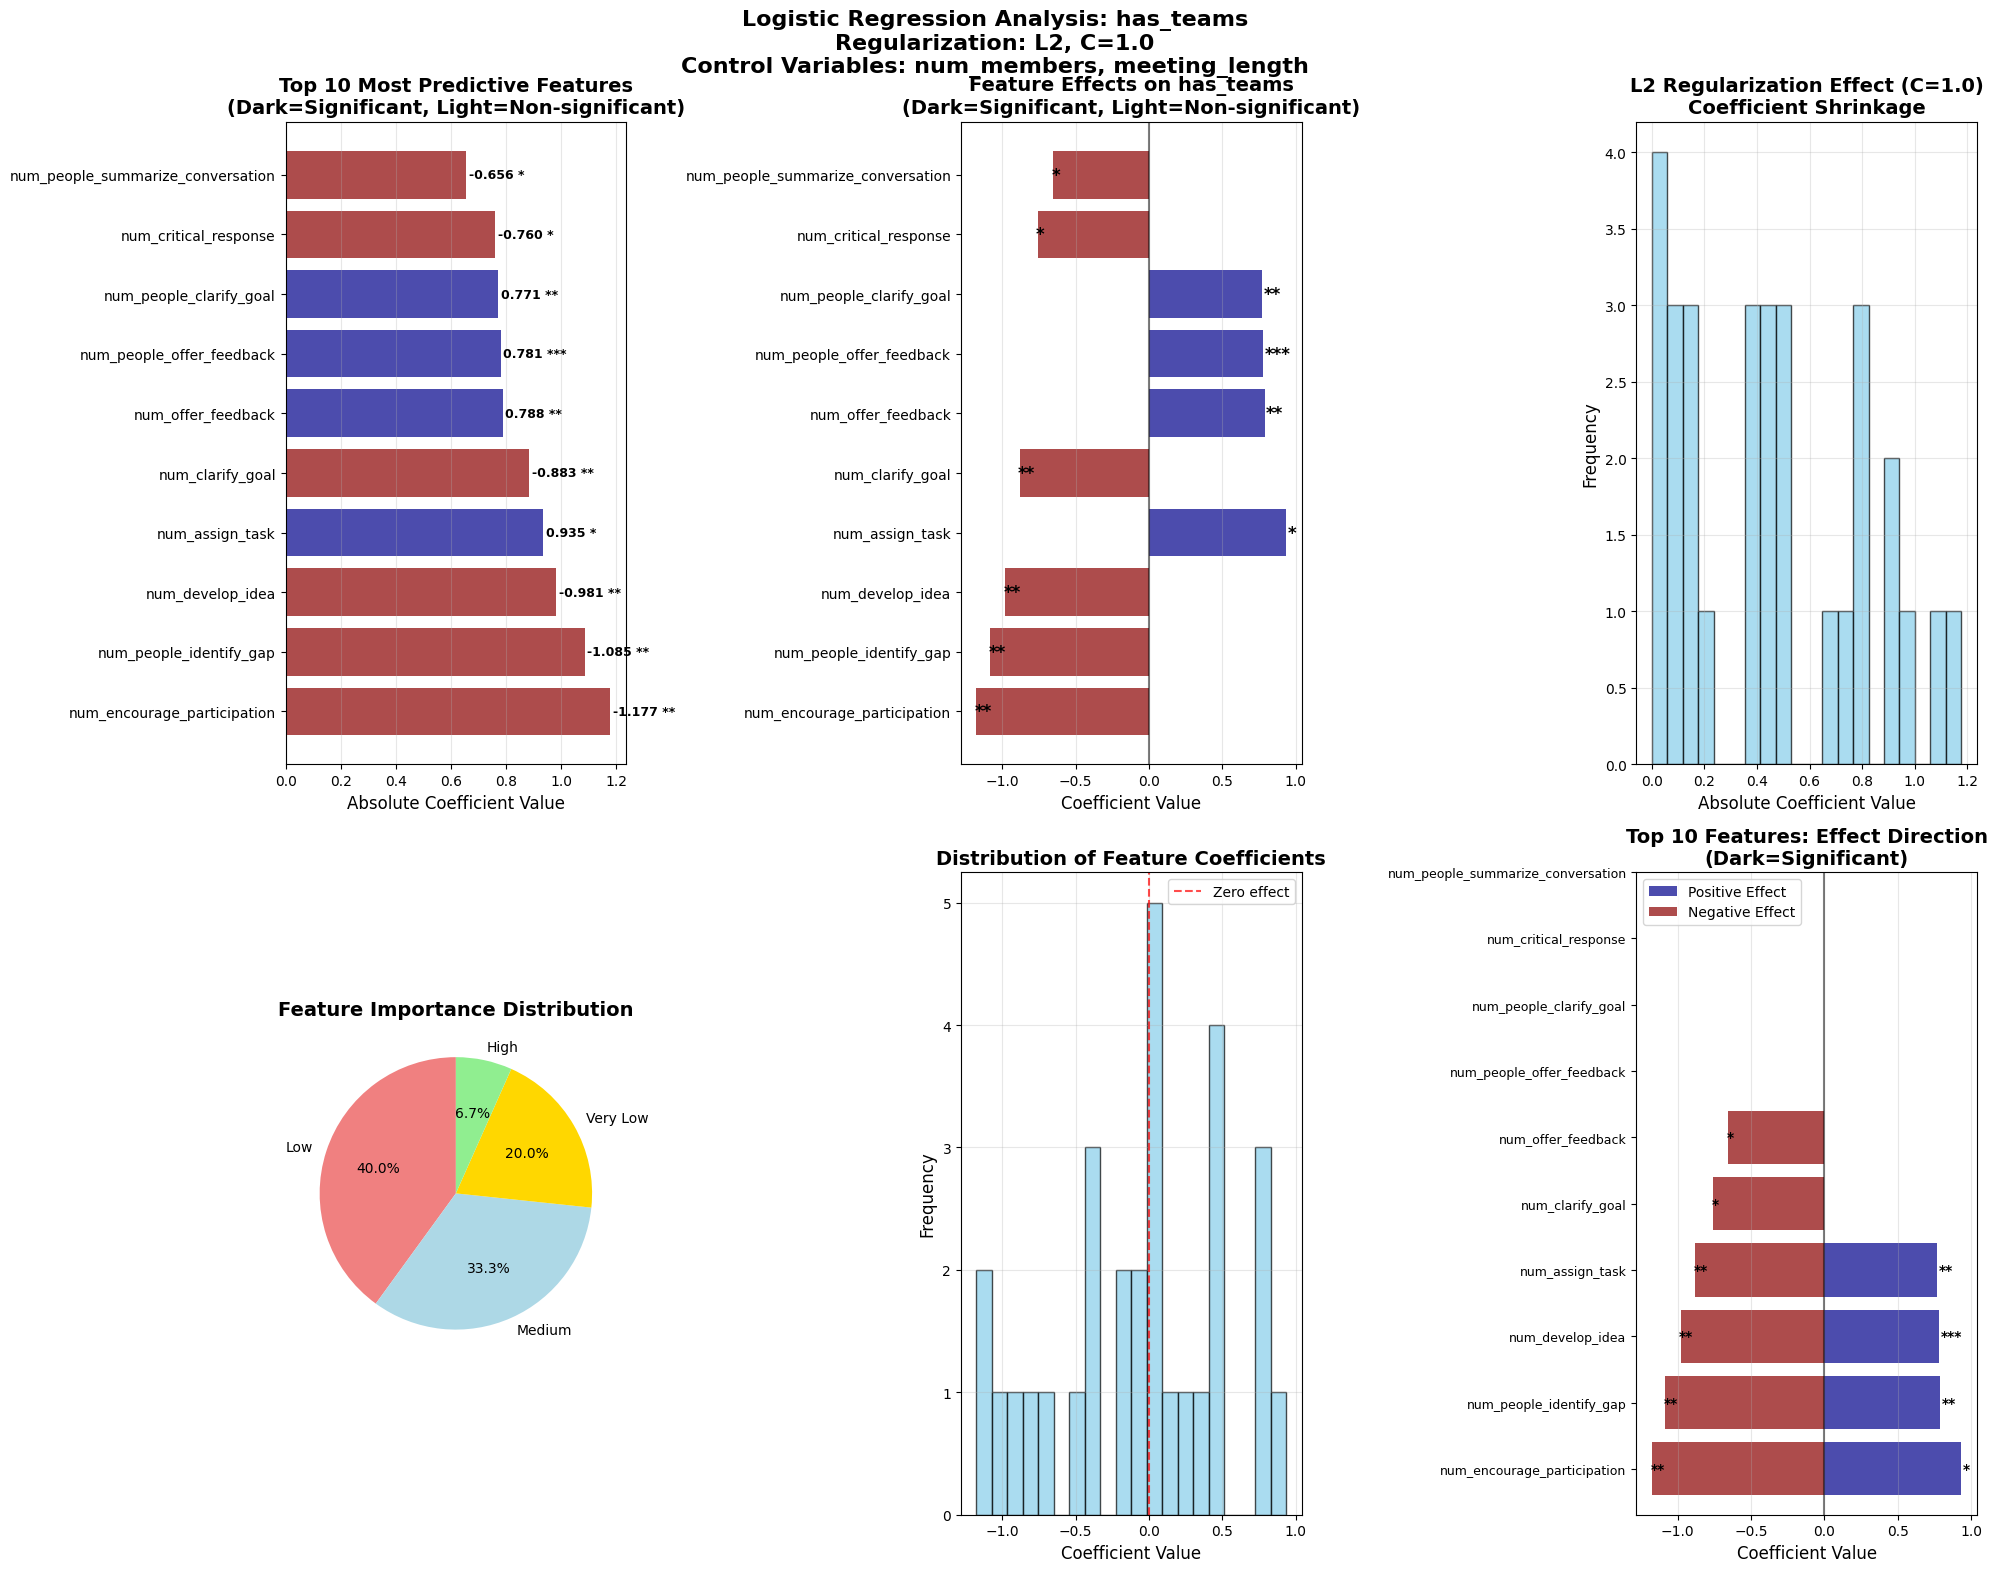


SUMMARY STATISTICS:
Total features analyzed: 30
Positive coefficients: 15
Negative coefficients: 15
Zero coefficients: 0
Mean absolute coefficient: 0.4587
Max absolute coefficient: 1.1771

STATISTICAL SIGNIFICANCE:
Significant features (p < 0.05): 13
Highly significant features (p < 0.01): 8
Very highly significant features (p < 0.001): 1

Top significant features:
  num_encourage_participation: -1.177 ** (p=0.008)
  num_people_identify_gap: -1.085 ** (p=0.003)
  num_develop_idea: -0.981 ** (p=0.006)
  num_assign_task: 0.935 * (p=0.018)
  num_clarify_goal: -0.883 ** (p=0.009)


feature  coefficient  abs_coefficient  \
0          num_encourage_participation    -1.177132         1.177132   
1              num_people_identify_gap    -1.085205         1.085205   
2                     num_develop_idea    -0.980949         0.980949   
3                      num_assign_task     0.934524         0.934524   
4                     num_clarify_goal    -0.882911         0.882911   
5                   num_offer_feedback     0.787860         0.787860   
6            num_people_offer_feedback     0.780817         0.780817   
7              num_people_clarify_goal     0.771312         0.771312   
8                num_critical_response    -0.759909         0.759909   
9    num_people_summarize_conversation    -0.655571         0.655571   
10             num_supportive_response     0.508788         0.508788   
11                num_propose_new_idea     0.506929         0.506929   
12              num_people_assign_task    -0.480294         0.480294   
13  num_people_encourage_participation     0.449860         0.449860   
14                    num_ask_question     0.442301         0.442301   
15      num_people_supportive_response    -0.429540         0.429540   
16                   num_express_humor    -0.396758         0.396758   
17        num_people_critical_response     0.372770         0.372770   
18              num_process_management    -0.360965         0.360965   
19             num_people_ask_question     0.222483         0.222483   
20            num_people_express_humor    -0.149397         0.149397   
21        num_acknowledge_contribution    -0.140341         0.140341   
22                    num_interruption     0.127853         0.127853   
23       num_people_process_management    -0.106736         0.106736   
24          num_summarize_conversation     0.086082         0.086082   
25            percent_time_screenshare    -0.074426         0.074426   
26                num_confirm_decision     0.043185         0.043185   
27         num_people_confirm_decision     0.043185         0.043185   
28                    num_identify_gap     0.004145         0.004145   
29                num_signal_expertise    -0.000195         0.000195   

         p_value  significant significance importance_level  
0   7.896567e-03         True           **             High  
1   2.554350e-03         True           **             High  
2   6.032604e-03         True           **           Medium  
3   1.762056e-02         True            *           Medium  
4   8.726028e-03         True           **           Medium  
5   5.257114e-03         True           **           Medium  
6   6.203282e-10         True          ***           Medium  
7   8.657378e-03         True           **           Medium  
8   1.350943e-02         True            *           Medium  
9   2.546808e-02         True            *           Medium  
10  2.011831e-03         True           **           Medium  
11  3.270586e-02         True            *           Medium  
12  1.410674e-01        False                           Low  
13  1.297113e-01        False                           Low  
14  1.738619e-01        False                           Low  
15  3.881022e-02         True            *              Low  
16  2.235502e-01        False                           Low  
17  9.704160e-02        False                           Low  
18  1.180277e-01        False                           Low  
19  8.726697e-01        False                           Low  
20  8.863461e-02        False                           Low  
21  3.351766e-01        False                           Low  
22  7.987616e-01        False                           Low  
23  7.949347e-01        False                           Low  
24  8.623808e-01        False                      Very Low  
25  9.288031e-01        False                      Very Low  
26           NaN        False                      Very Low  
27           NaN        False                      Very Low  


In [129]:
# 3. Visualize feature importance
visualize_logistic_features(
    importance, 'has_teams', 
    control_variables=['num_members', 'meeting_length'],
    X_train_scaled_df=X_train,  # Now available
    y_train=y_train             # Now available!
)

Visualizing decision boundaries for has_teams
Residualizing features against control variables...
Using top 2 features for 2D visualization: ['num_assign_task', 'num_people_identify_gap']


/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:778: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:778: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:778: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:786: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/17/4vnbnj_12z

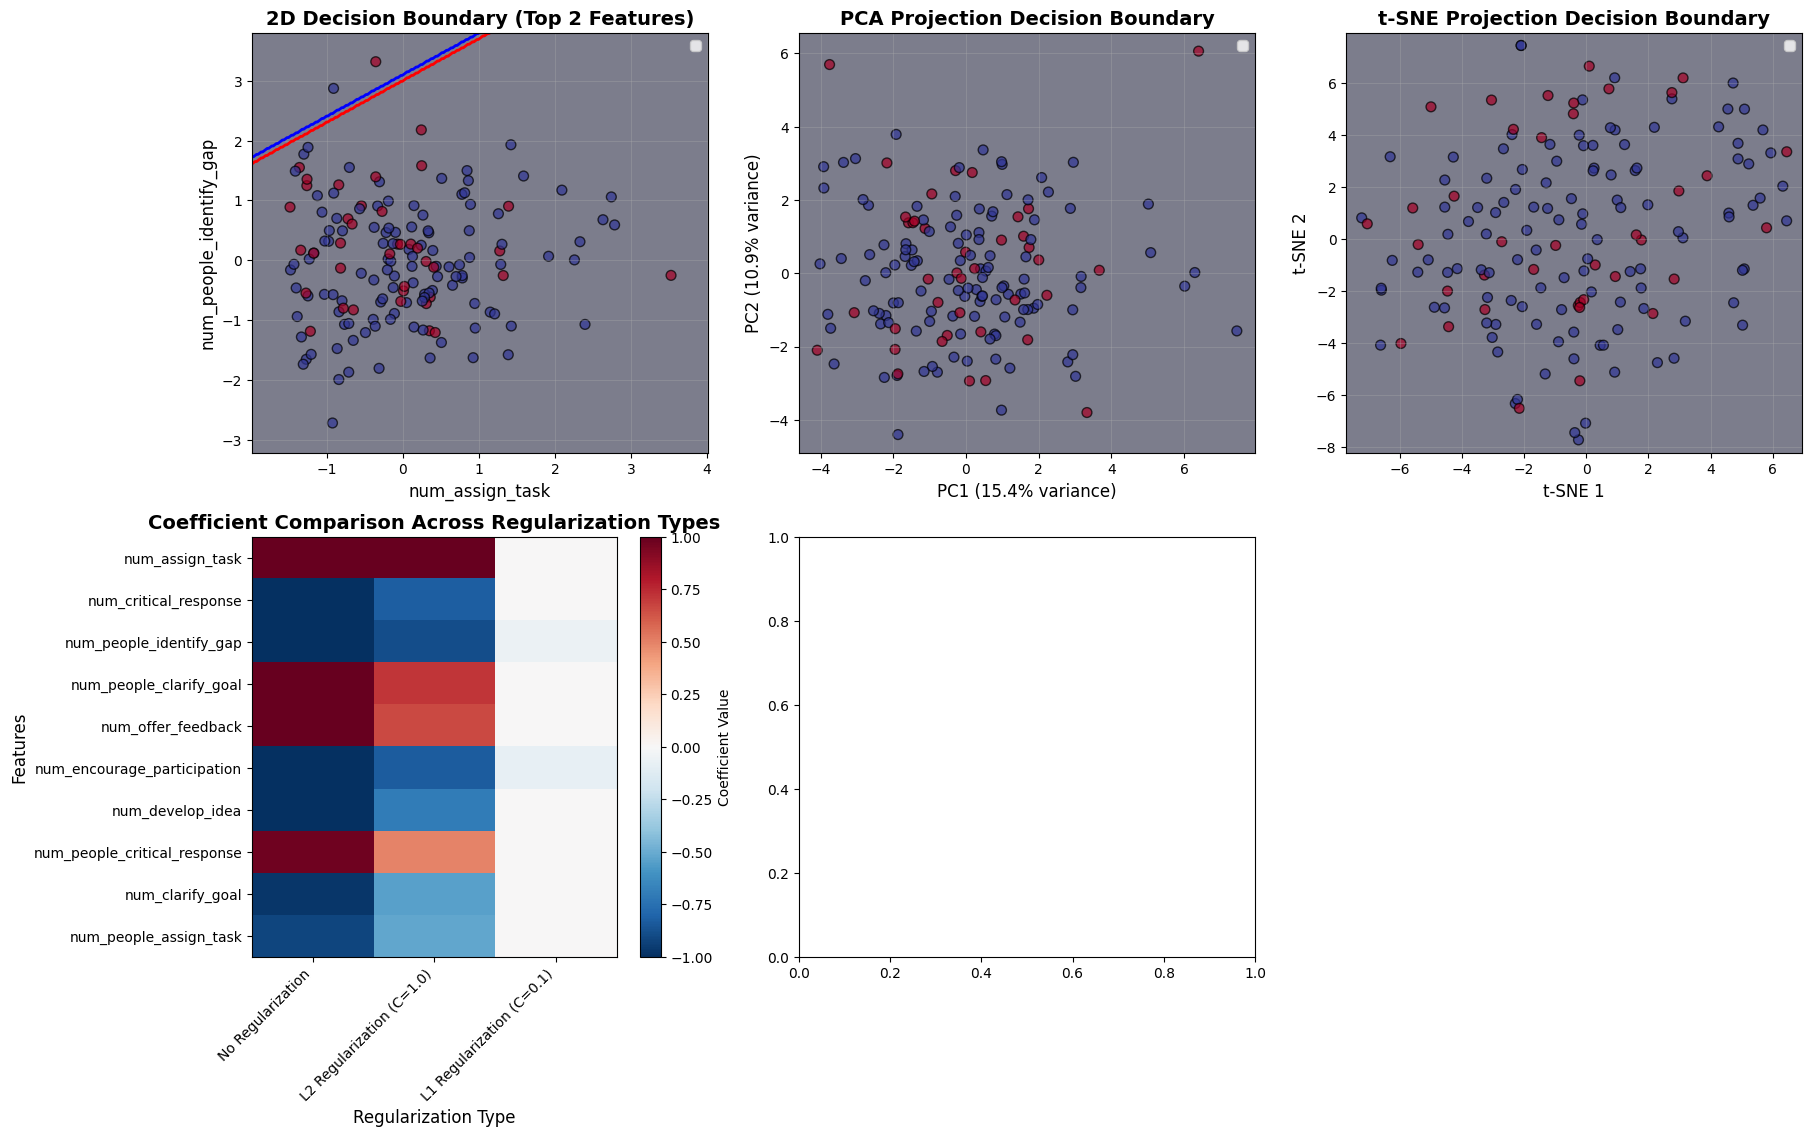

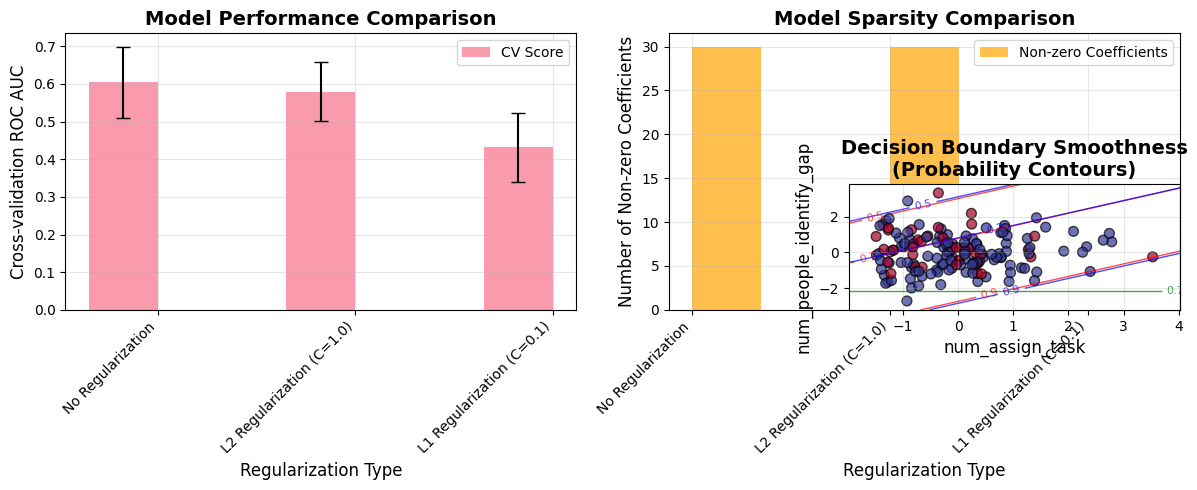

In [94]:
# 4. Compare decision boundaries with and without regularization
models = visualize_decision_boundaries(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length'],
    regularization_comparison=True,  # Compare regularization types
    top_features=2,                 # Use top 2 features for 2D plots
    save_plots=False                 # Save plots to files
)



Residualizing features against control variables...
Finding optimal L2 regularization strength...
Testing C values: [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

Best C value: 1000.0
Best cross-validation score: 0.605


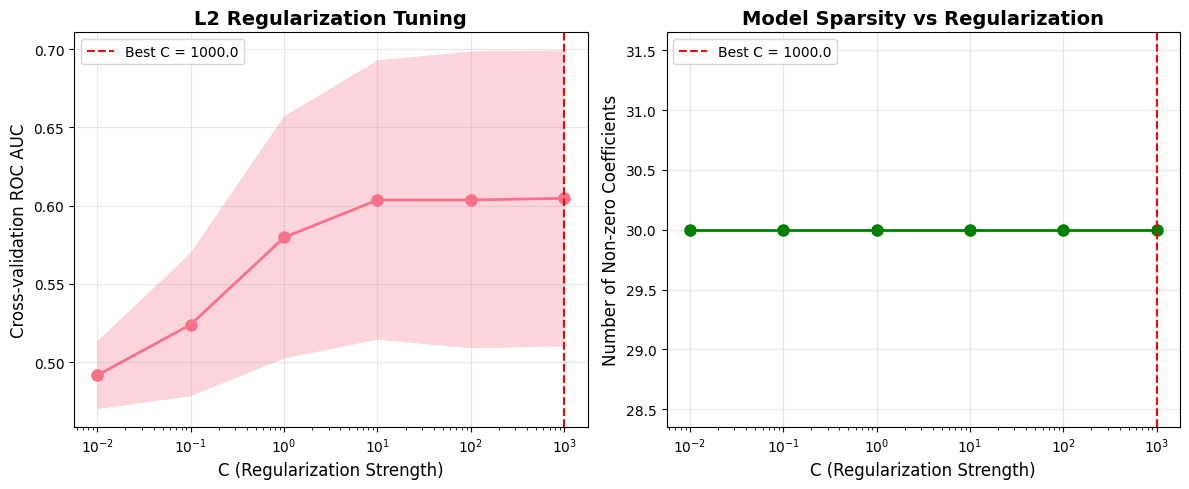

In [86]:
# 5. Find optimal regularization strength
best_c_l1, best_c_l2 = find_optimal_regularization(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length']
)



Quick Diagnosis for has_teams

1. Target Variable Analysis:
------------------------------
Target variable distribution:
  1: 117 (75.0%)
  0: 39 (25.0%)

2. Feature Correlation Analysis:
------------------------------
Top 10 features by absolute correlation with has_teams:
  num_people_offer_feedback: 0.231
  num_offer_feedback: 0.195
  num_people_clarify_goal: 0.171
  num_ask_question: 0.153
  num_assign_task: 0.150
  num_propose_new_idea: 0.136
  num_people_supportive_response: 0.104
  num_people_ask_question: 0.096
  percent_time_screenshare: -0.095
  num_signal_expertise: 0.094

3. Feature Variance Analysis:
------------------------------
Top 10 features by variance:
  percent_time_screenshare: 578.586
  num_develop_idea: 269.243
  num_process_management: 173.605
  num_ask_question: 171.643
  num_supportive_response: 131.948
  num_identify_gap: 84.221
  num_encourage_participation: 74.128
  num_acknowledge_contribution: 48.591
  num_signal_expertise: 48.153
  num_propose_new_idea:

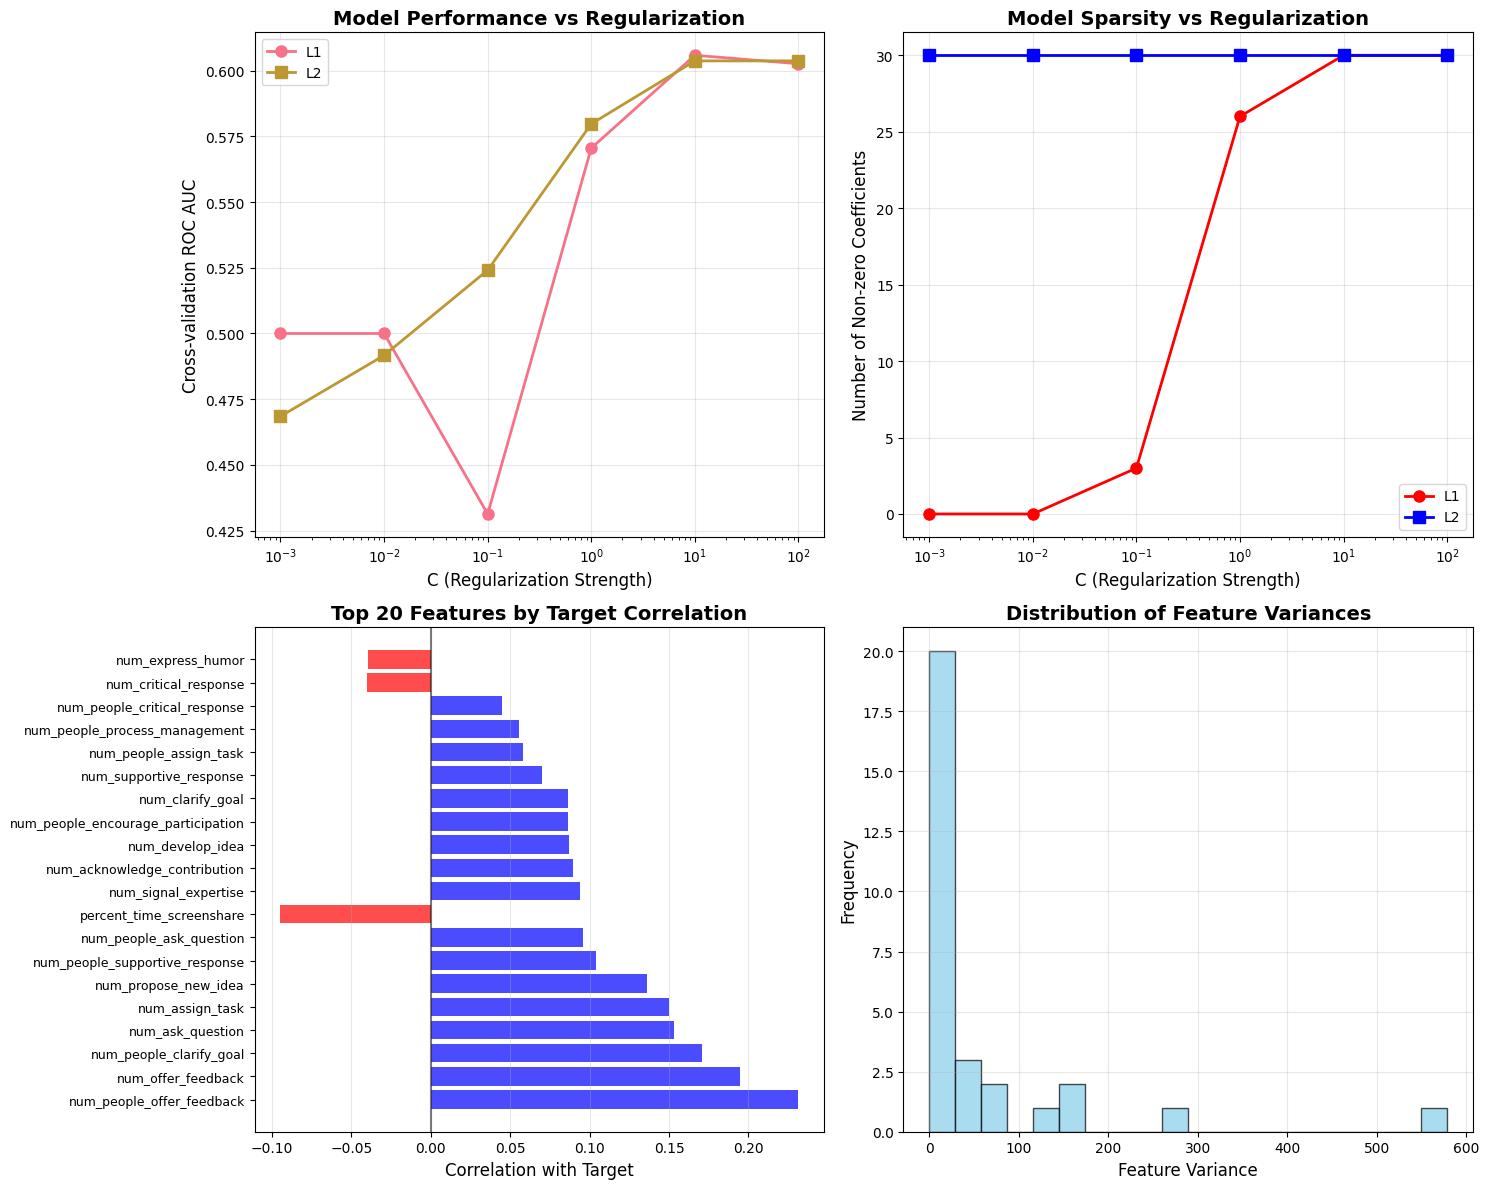


6. Recommendations:
------------------------------
Best L1 regularization C: 10.0 (CV score: 0.606)
Best L2 regularization C: 100.0 (CV score: 0.604)
Recommendation: Use L1 regularization with C=10.0


C  L1_non_zero  L2_non_zero  L1_cv_score  L2_cv_score
0    0.001            0           30     0.500000     0.468504
1    0.010            0           30     0.500000     0.491680
2    0.100            3           30     0.431360     0.524075
3    1.000           26           30     0.570484     0.579710
4   10.000           30           30     0.605804     0.603662
5  100.000           30           30     0.602588     0.603675

In [87]:
# 6. Quick diagnosis of regularization issues
quick_diagnosis(all_data_df, 'has_teams', 
               control_variables=['num_members', 'meeting_length'])



In [88]:
# 7. Compare all three approaches
compare_models_with_and_without_controls(
    all_data_df, 'has_teams', 
    control_variables=['num_members', 'meeting_length']
)

COMPARING MODELS WITH AND WITHOUT CONTROL VARIABLES

MODEL 1: WITHOUT CONTROL VARIABLES

Using L2 regularization with C=1.0

Logistic Regression Results for has_teams
Regularization: L2, C=1.0
Training samples: 124
Test samples: 32
ROC AUC: 0.536

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.76      0.92      0.83        24

    accuracy                           0.72        32
   macro avg       0.55      0.52      0.51        32
weighted avg       0.65      0.72      0.67        32


Top 10 Most Predictive Features:
                        feature  coefficient  abs_coefficient
1                meeting_length     1.693582         1.693582
15  num_encourage_participation    -1.139250         1.139250
21      num_people_identify_gap    -1.136932         1.136932
5              num_develop_idea    -0.957455         0.957455
17              num_assign_task     0.903748         0.903

{'model1': (LogisticRegression(max_iter=1000, random_state=42),
  StandardScaler(),
                                 feature  coefficient  abs_coefficient
  1                       meeting_length     1.693582         1.693582
  15         num_encourage_participation    -1.139250         1.139250
  21             num_people_identify_gap    -1.136932         1.136932
  5                     num_develop_idea    -0.957455         0.957455
  17                     num_assign_task     0.903748         0.903748
  18                    num_clarify_goal    -0.769716         0.769716
  30             num_people_clarify_goal     0.734696         0.734696
  24           num_people_offer_feedback     0.676626         0.676626
  11               num_critical_response    -0.649872         0.649872
  12                  num_offer_feedback     0.642551         0.642551
  29              num_people_assign_task    -0.621661         0.621661
  25   num_people_summarize_conversation    -0.612531         0.

#### has funded teams

Visualizing decision boundaries for has_funded_teams
Residualizing features against control variables...
Using top 2 features for 2D visualization: ['num_offer_feedback', 'num_assign_task']


/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:778: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:778: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:778: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors=colors[i], linewidths=2, label=name)
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_51394/1424950707.py:786: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/17/4vnbnj_12z

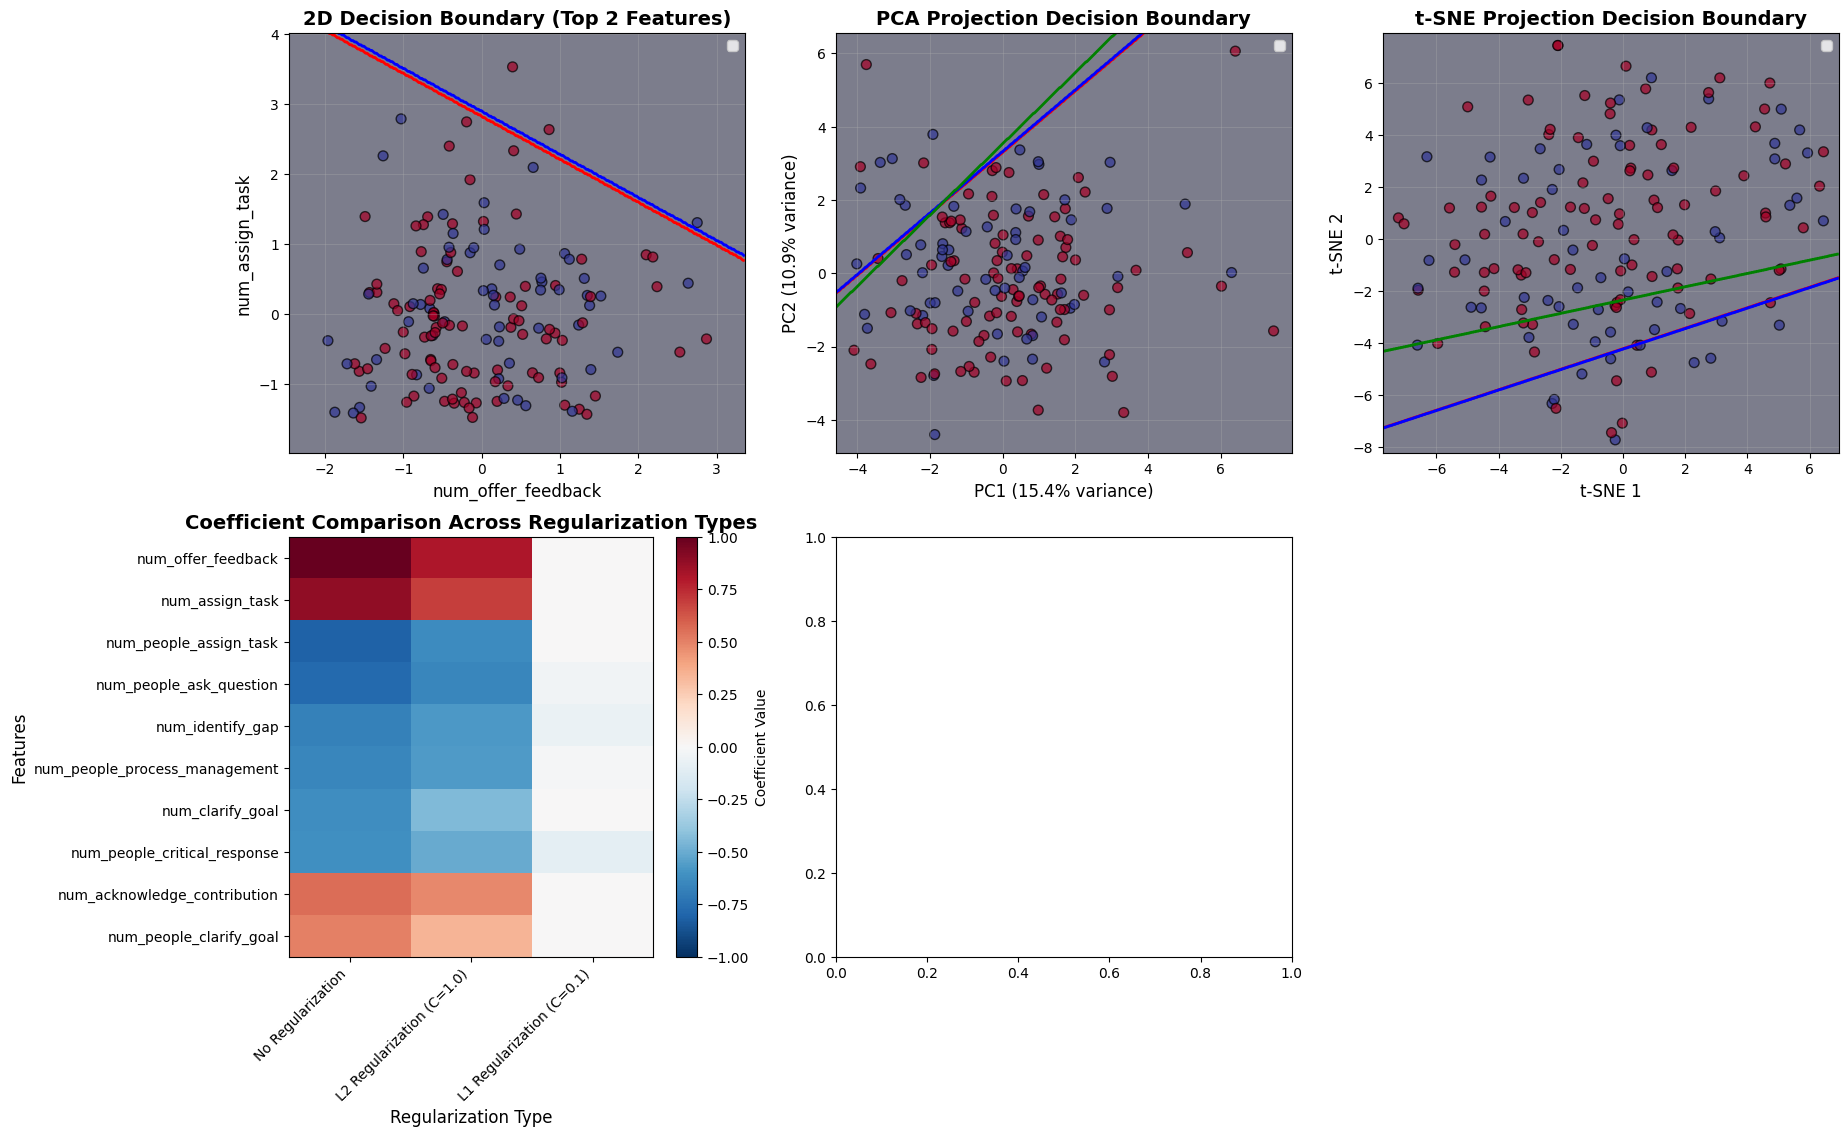

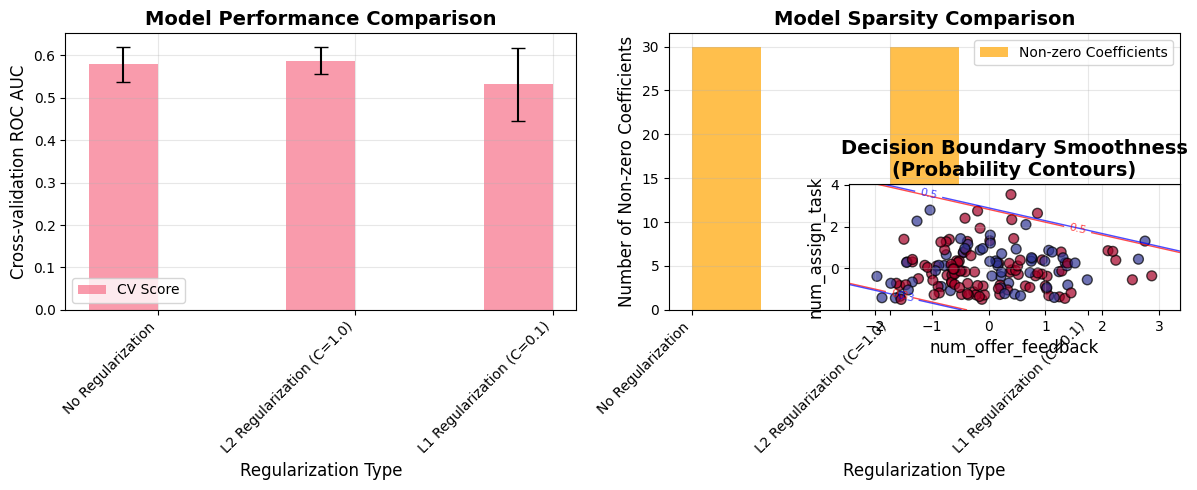

In [95]:
# 4. Compare decision boundaries with and without regularization
models = visualize_decision_boundaries(
    all_data_df, 'has_funded_teams', 
    control_variables=['num_members', 'meeting_length'],
    regularization_comparison=True,  # Compare regularization types
    top_features=2,                 # Use top 2 features for 2D plots
    save_plots=False                 # Save plots to files
)



Quick Diagnosis for has_funded_teams

1. Target Variable Analysis:
------------------------------
Target variable distribution:
  0: 96 (61.5%)
  1: 60 (38.5%)

2. Feature Correlation Analysis:
------------------------------
Top 10 features by absolute correlation with has_funded_teams:
  num_acknowledge_contribution: 0.178
  num_assign_task: 0.143
  num_process_management: 0.139
  num_summarize_conversation: 0.137
  num_encourage_participation: 0.131
  num_offer_feedback: 0.130
  num_people_critical_response: -0.121
  num_people_summarize_conversation: 0.110
  num_people_offer_feedback: 0.110
  num_critical_response: -0.107

3. Feature Variance Analysis:
------------------------------
Top 10 features by variance:
  percent_time_screenshare: 578.586
  num_develop_idea: 269.243
  num_process_management: 173.605
  num_ask_question: 171.643
  num_supportive_response: 131.948
  num_identify_gap: 84.221
  num_encourage_participation: 74.128
  num_acknowledge_contribution: 48.591
  num_signa

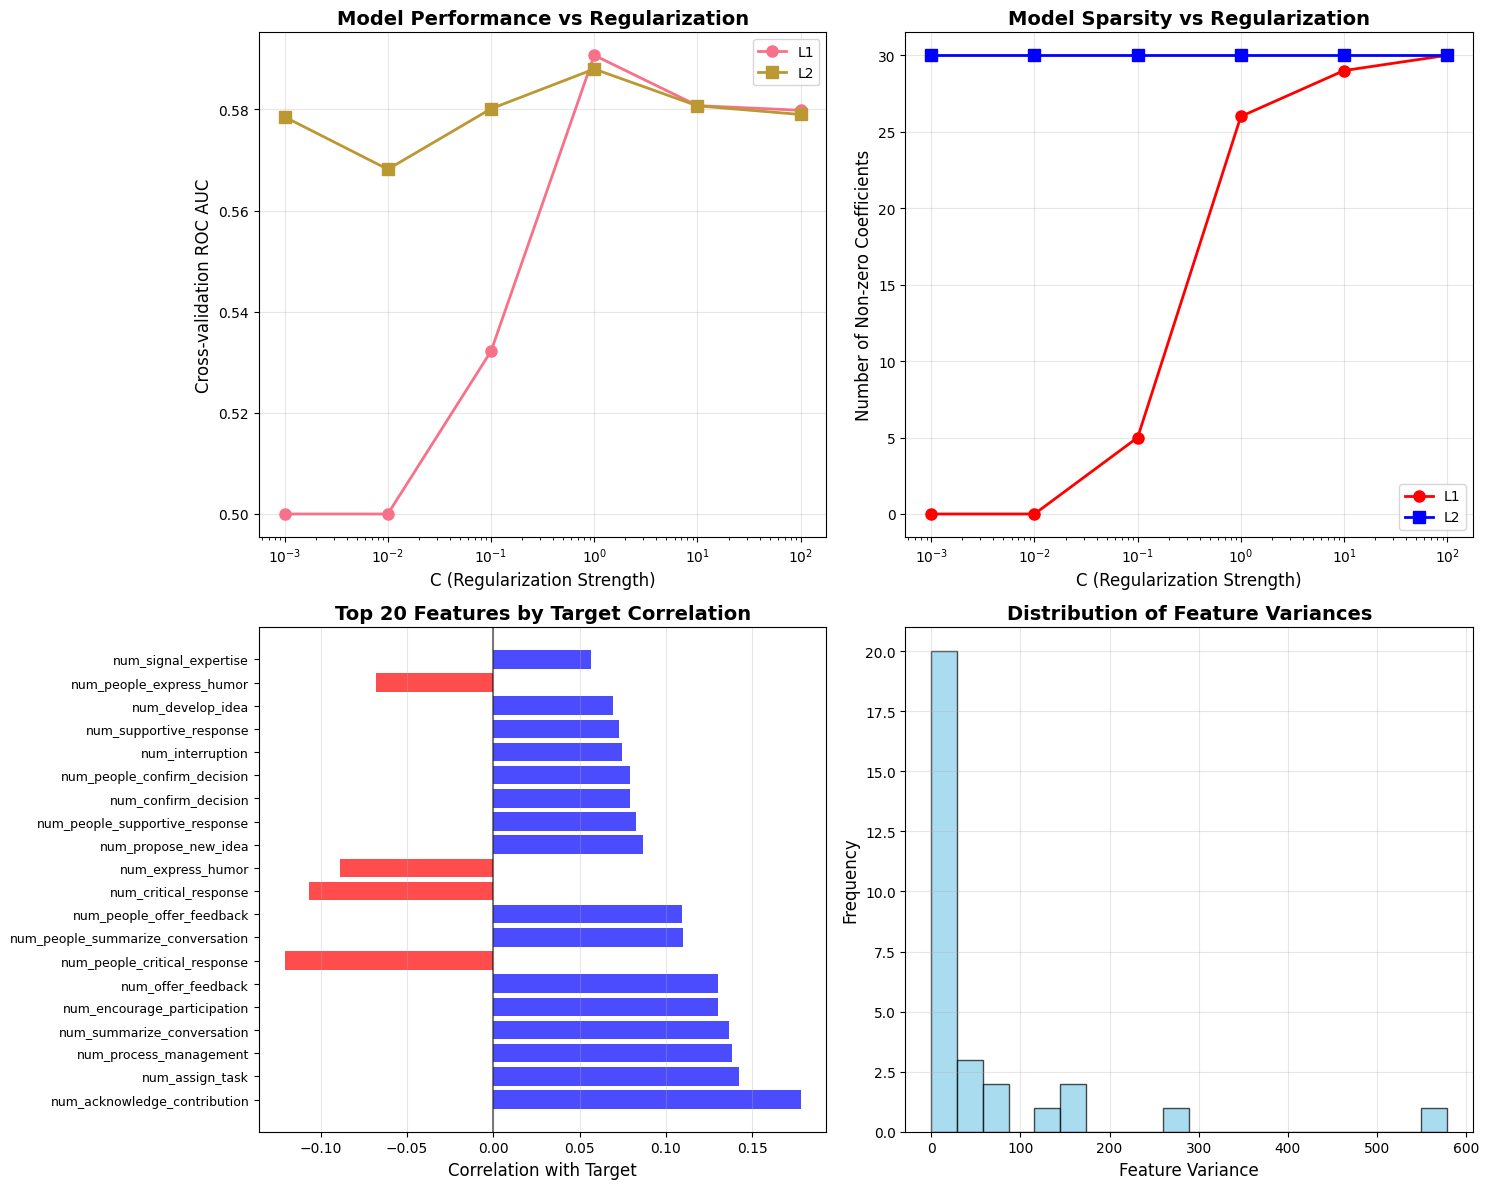


6. Recommendations:
------------------------------
Best L1 regularization C: 1.0 (CV score: 0.591)
Best L2 regularization C: 1.0 (CV score: 0.588)
Recommendation: Use L1 regularization with C=1.0


C  L1_non_zero  L2_non_zero  L1_cv_score  L2_cv_score
0    0.001            0           30     0.500000     0.578509
1    0.010            0           30     0.500000     0.568158
2    0.100            5           30     0.532193     0.580132
3    1.000           26           30     0.590702     0.587982
4   10.000           29           30     0.580746     0.580702
5  100.000           30           30     0.579825     0.578991

In [96]:

quick_diagnosis(all_data_df, 'has_funded_teams', 
               control_variables=['num_members', 'meeting_length'])

Control variables: ['num_members', 'meeting_length']
Features (excluding controls): 30

Residualizing features against control variables...
Features have been residualized against control variables.

Using L2 regularization with C=1.0

Logistic Regression Results for has_funded_teams
Control variables: ['num_members', 'meeting_length']
Regularization: L2, C=1.0
Training samples: 124
Test samples: 32
ROC AUC: 0.710

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.94      0.74        17
           1       0.83      0.33      0.48        15

    accuracy                           0.66        32
   macro avg       0.72      0.64      0.61        32
weighted avg       0.72      0.66      0.62        32


Top 10 Most Predictive Features:
                          feature  coefficient  abs_coefficient
26  num_people_process_management    -0.773022         0.773022
18        num_people_ask_question    -0.719689         0.719689
10   

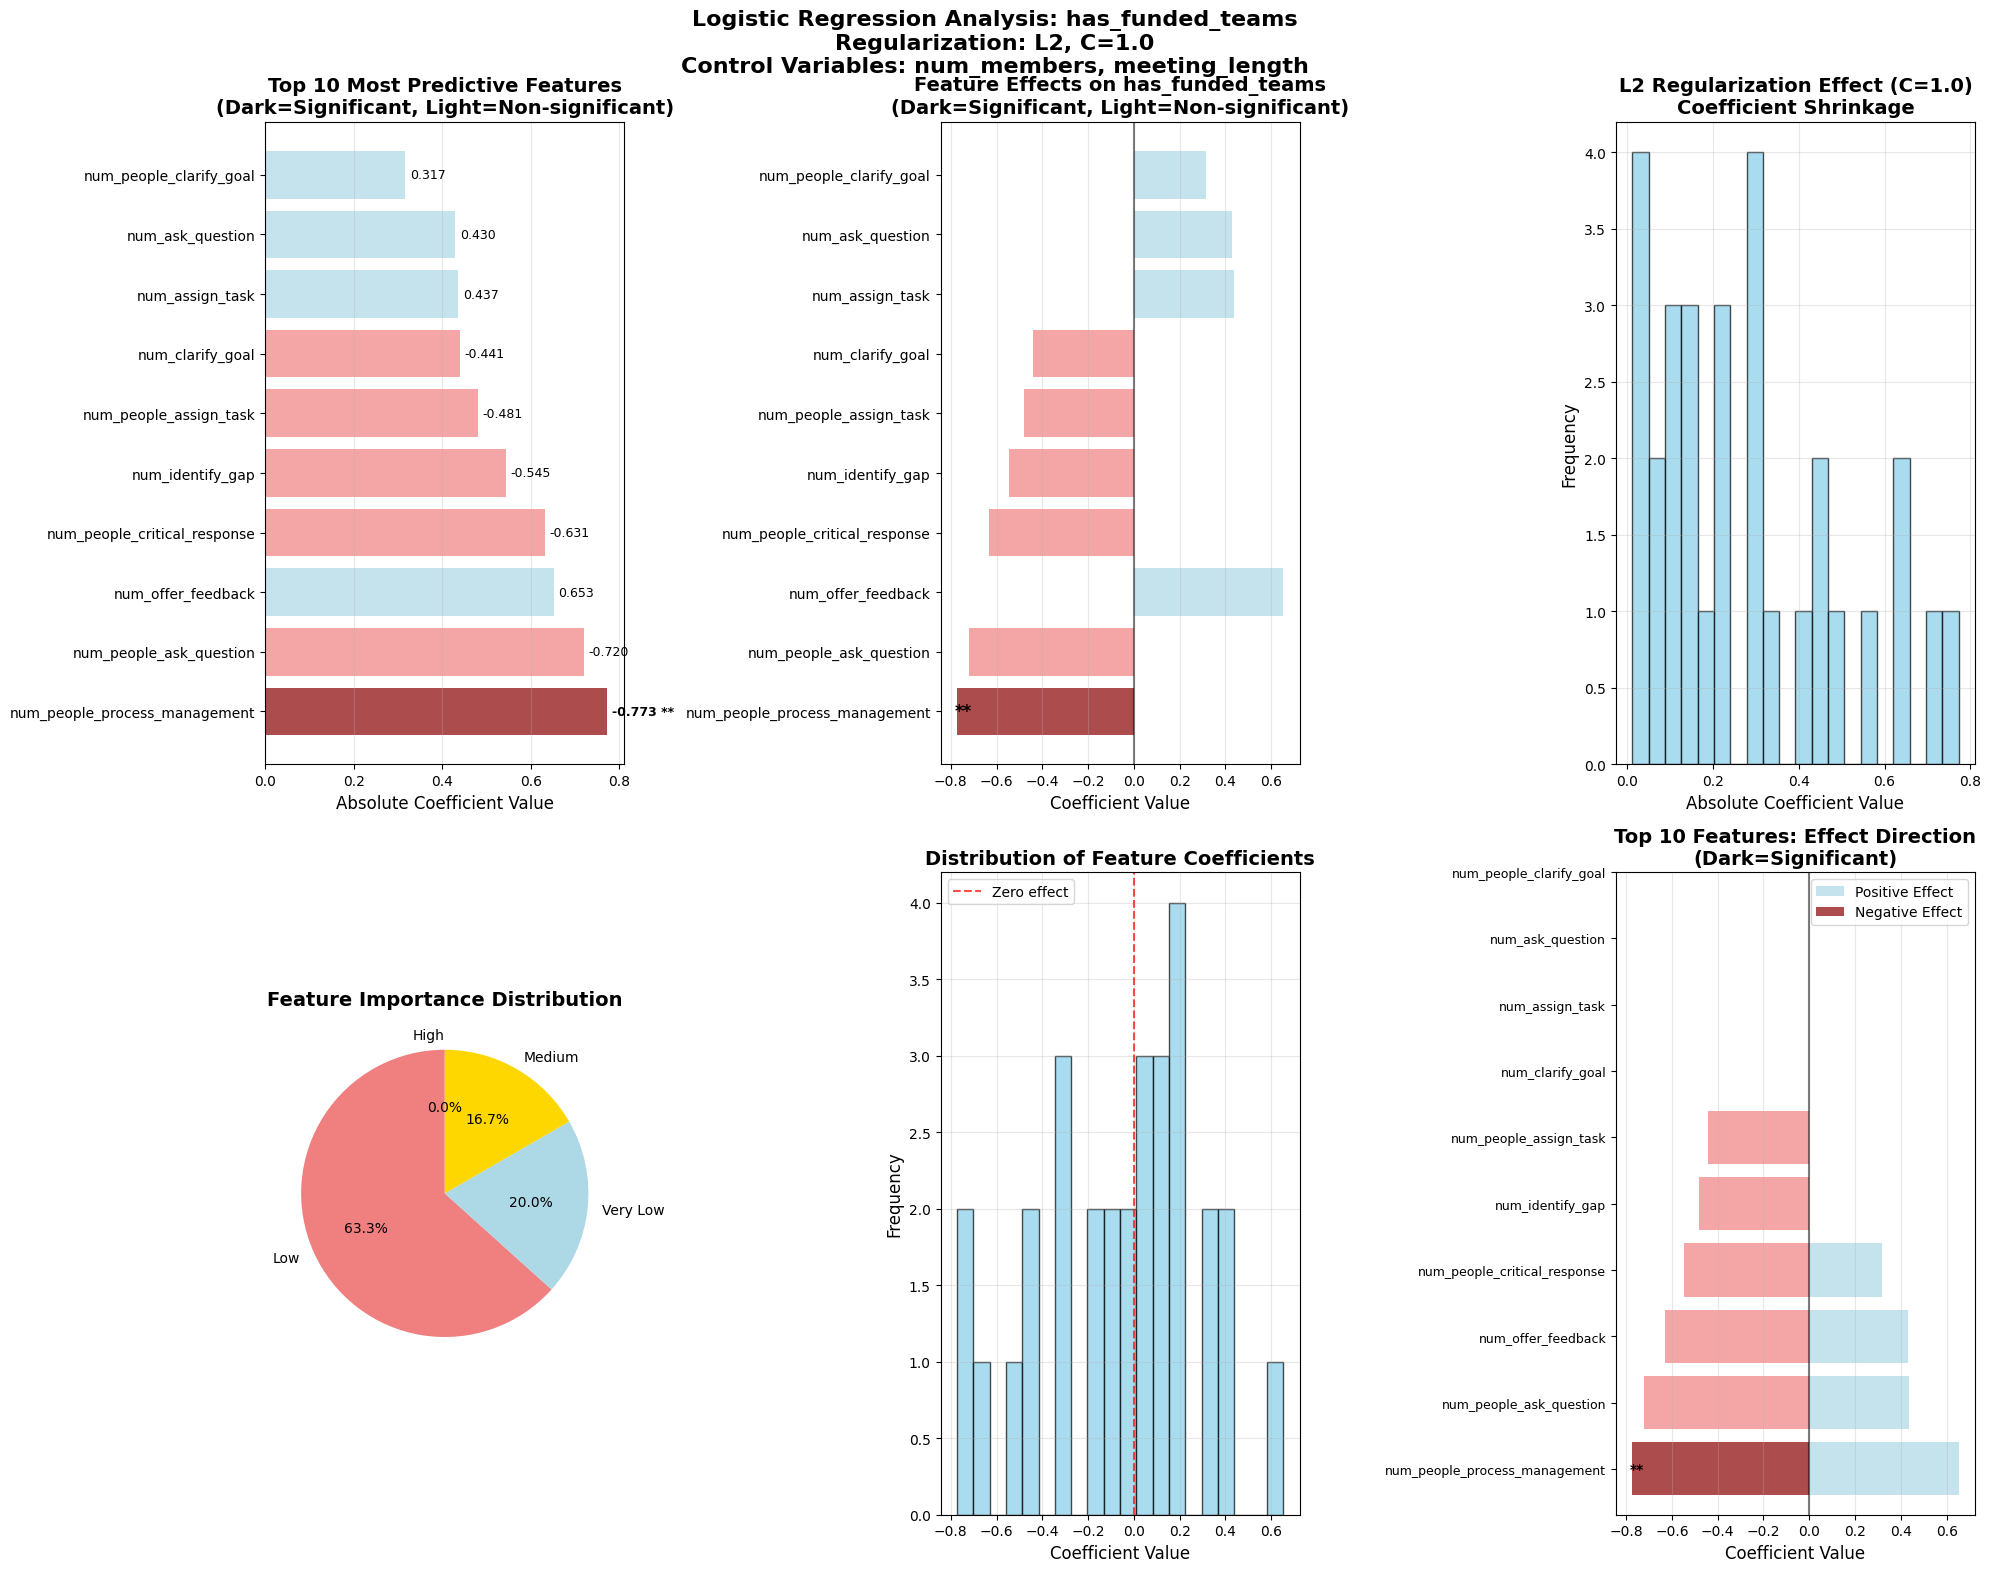


SUMMARY STATISTICS:
Total features analyzed: 30
Positive coefficients: 15
Negative coefficients: 15
Zero coefficients: 0
Mean absolute coefficient: 0.2827
Max absolute coefficient: 0.7730

STATISTICAL SIGNIFICANCE:
Significant features (p < 0.05): 2
Highly significant features (p < 0.01): 2
Very highly significant features (p < 0.001): 0

Top significant features:
  num_people_process_management: -0.773 ** (p=0.003)
  num_supportive_response: 0.144 ** (p=0.003)


feature  coefficient  abs_coefficient  \
0        num_people_process_management    -0.773022         0.773022   
1              num_people_ask_question    -0.719689         0.719689   
2                   num_offer_feedback     0.652692         0.652692   
3         num_people_critical_response    -0.631300         0.631300   
4                     num_identify_gap    -0.545165         0.545165   
5               num_people_assign_task    -0.480639         0.480639   
6                     num_clarify_goal    -0.440808         0.440808   
7                      num_assign_task     0.436582         0.436582   
8                     num_ask_question     0.429676         0.429676   
9              num_people_clarify_goal     0.316765         0.316765   
10                    num_interruption     0.303304         0.303304   
11   num_people_summarize_conversation    -0.293269         0.293269   
12                    num_develop_idea    -0.288413         0.288413   
13                   num_express_humor    -0.288272         0.288272   
14         num_people_confirm_decision     0.216740         0.216740   
15                num_confirm_decision     0.216740         0.216740   
16        num_acknowledge_contribution     0.210884         0.210884   
17              num_process_management     0.189636         0.189636   
18                num_signal_expertise    -0.163579         0.163579   
19         num_encourage_participation    -0.152053         0.152053   
20             num_supportive_response     0.144155         0.144155   
21          num_summarize_conversation     0.114388         0.114388   
22                num_propose_new_idea     0.104853         0.104853   
23            num_people_express_humor    -0.102342         0.102342   
24  num_people_encourage_participation     0.081741         0.081741   
25      num_people_supportive_response    -0.061225         0.061225   
26               num_critical_response    -0.049434         0.049434   
27            percent_time_screenshare    -0.033244         0.033244   
28           num_people_offer_feedback     0.028730         0.028730   
29             num_people_identify_gap     0.011533         0.011533   

     p_value  significant significance importance_level  
0   0.002638         True           **           Medium  
1   0.129327        False                        Medium  
2   0.132790        False                        Medium  
3        NaN        False                        Medium  
4   0.060604        False                        Medium  
5   0.099726        False                           Low  
6        NaN        False                           Low  
7   0.068911        False                           Low  
8   0.360412        False                           Low  
9        NaN        False                           Low  
10  0.104293        False                           Low  
11  0.334049        False                           Low  
12  0.174081        False                           Low  
13  0.582784        False                           Low  
14  1.000000        False                           Low  
15  1.000000        False                           Low  
16  0.397312        False                           Low  
17  0.487290        False                           Low  
18  0.715460        False                           Low  
19  0.550789        False                           Low  
20  0.002540         True           **              Low  
21  0.852090        False                           Low  
22  0.218319        False                           Low  
23  0.998099        False                           Low  
24  0.712016        False                      Very Low  
25       NaN        False                      Very Low  
26  0.386329        False                      Very Low  
27  0.904146        False                      Very Low  
28  0.896822        False                      Very Low  
29  0.755981        False                      Very Low

In [131]:

# 2. Residualized logistic regression (recommended)
model, scaler, importance, X_train, X_test, y_train, y_test = normalize_and_run_logistic_regression(
    all_data_df, 'has_funded_teams', 
    control_variables=['num_members', 'meeting_length']
)


visualize_logistic_features(
    importance, 'has_funded_teams', 
    control_variables=['num_members', 'meeting_length'],
    X_train_scaled_df=X_train,  # Now available
    y_train=y_train             # Now available!
)

### linear regression with controls

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy import stats

def run_linear_regression_with_stats_controls(all_data_df, target_column, control_variables=None, 
                                             test_size=0.2, random_state=42):
    """
    Run linear regression with statistical significance testing using statsmodels,
    including control variables via residualization.
    
    Parameters:
    - all_data_df: DataFrame with features and target
    - target_column: Name of the target variable
    - control_variables: List of control variable names (e.g., ['num_members', 'meeting_length'])
    - test_size: Proportion of data for testing
    - random_state: Random seed for reproducibility
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams'] 
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    # If control variables are specified, remove them from features
    if control_variables:
        feature_columns = [col for col in feature_columns if col not in control_variables]
        print(f"Control variables: {control_variables}")
        print(f"Features (excluding controls): {len(feature_columns)}")
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Handle control variables by residualization
    if control_variables:
        print("\nResidualizing features and target against control variables...")
        
        # Get control variables data
        controls_train = all_data_df.loc[X_train.index, control_variables].fillna(0)
        controls_test = all_data_df.loc[X_test.index, control_variables].fillna(0)
        
        # Residualize each feature against control variables
        X_train_residualized = X_train.copy()
        X_test_residualized = X_test.copy()
        
        for feature in feature_columns:
            # Fit linear regression: feature ~ controls
            lr = LinearRegression()
            lr.fit(controls_train, X_train[feature])
            
            # Get residuals
            X_train_residualized[feature] = X_train[feature] - lr.predict(controls_train)
            X_test_residualized[feature] = X_test[feature] - lr.predict(controls_test)
        
        # Residualize target variable against control variables
        lr_target = LinearRegression()
        lr_target.fit(controls_train, y_train)
        
        y_train_residualized = y_train - lr_target.predict(controls_train)
        y_test_residualized = y_test - lr_target.predict(controls_test)
        
        X_train = X_train_residualized
        X_test = X_test_residualized
        y_train = y_train_residualized
        y_test = y_test_residualized
        
        print("Features and target have been residualized against control variables.")
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)
    
    # Fit linear regression with statsmodels
    model = sm.OLS(y_train, X_train_with_const)
    results = model.fit()
    
    # Get predictions
    y_pred = results.predict(X_test_with_const)
    
    print(f"\nLinear Regression Results for {target_column}")
    print("=" * 60)
    if control_variables:
        print(f"Control variables: {control_variables}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"F-statistic p-value: {results.f_pvalue:.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    print(results.summary())
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + feature_columns
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    t_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        't_score': t_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    if len(significant_features) > 0:
        print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features are statistically significant at p < 0.05")
    
    print("\n" + "="*60)
    print("HIGHLY SIGNIFICANT FEATURES (p < 0.01):")
    print("="*60)
    highly_significant_features = results_df[results_df['highly_significant']].sort_values('p_value')
    if len(highly_significant_features) > 0:
        print(highly_significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features are highly statistically significant at p < 0.01")
    
    return results, results_df

def run_linear_regression_with_stats_direct_controls(all_data_df, target_column, control_variables=None, 
                                                   test_size=0.2, random_state=42):
    """
    Alternative method: Include control variables directly in the linear regression model.
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams'] 
                      and not col.endswith('_numeric')
                      and not col.startswith('num_teams')
                      and not col.startswith('num_funded_teams')
                      and not col.startswith('has_teams')
                      and not col.startswith('has_funded_teams')]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)
    
    # Fit linear regression with statsmodels
    model = sm.OLS(y_train, X_train_with_const)
    results = model.fit()
    
    # Get predictions
    y_pred = results.predict(X_test_with_const)
    
    print(f"\nLinear Regression Results for {target_column}")
    print("=" * 60)
    if control_variables:
        print(f"Control variables included in model: {control_variables}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"F-statistic p-value: {results.f_pvalue:.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    print(results.summary())
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + feature_columns
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    t_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        't_score': t_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    # Show control variable coefficients if they exist
    if control_variables:
        control_importance = results_df[results_df['feature'].isin(control_variables)]
        if not control_importance.empty:
            print("\n" + "="*60)
            print("CONTROL VARIABLE COEFFICIENTS:")
            print("="*60)
            print(control_importance[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    if len(significant_features) > 0:
        print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features are statistically significant at p < 0.05")
    
    return results, results_df

# Example usage:
if __name__ == "__main__":
    print("Linear Regression with Statistical Significance Testing and Control Variables")
    print("=" * 80)
    
    print("""
# Load your data
# all_data_df = pd.read_csv('your_data.csv')

# Method 1: Residualization (recommended - control variables don't appear in results)
results, results_df = run_linear_regression_with_stats_controls(
    all_data_df, 'num_funded_teams', 
    control_variables=['num_members', 'meeting_length']
)

# Method 2: Direct inclusion (control variables appear in results)
results, results_df = run_linear_regression_with_stats_direct_controls(
    all_data_df, 'num_funded_teams', 
    control_variables=['num_members', 'meeting_length']
)
""")


Linear Regression with Statistical Significance Testing and Control Variables

# Load your data
# all_data_df = pd.read_csv('your_data.csv')

# Method 1: Residualization (recommended - control variables don't appear in results)
results, results_df = run_linear_regression_with_stats_controls(
    all_data_df, 'num_funded_teams', 
    control_variables=['num_members', 'meeting_length']
)

# Method 2: Direct inclusion (control variables appear in results)
results, results_df = run_linear_regression_with_stats_direct_controls(
    all_data_df, 'num_funded_teams', 
    control_variables=['num_members', 'meeting_length']
)



In [118]:
# Method 1: Residualization (recommended - control variables don't appear in results)
results, results_df = run_linear_regression_with_stats_controls(
    all_data_df, 'num_teams', 
    control_variables=['num_members', 'meeting_length']
)

Control variables: ['num_members', 'meeting_length']
Features (excluding controls): 30

Residualizing features and target against control variables...
Features and target have been residualized against control variables.

Linear Regression Results for num_teams
Control variables: ['num_members', 'meeting_length']
Training samples: 124
Test samples: 32
R² Score: 0.092
Adjusted R²: 0.065
F-statistic: 1.294
F-statistic p-value: 0.178

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:              num_teams   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.294
Date:                Mon, 01 Sep 2025   Prob (F-statistic):              0.178
Time:                        10:12:25   Log-Likelihood:                -156.98
No. Observations:                 124   AIC:                         

In [119]:
# Method 1: Residualization (recommended - control variables don't appear in results)
results, results_df = run_linear_regression_with_stats_controls(
    all_data_df, 'num_funded_teams', 
    control_variables=['num_members', 'meeting_length']
)

Control variables: ['num_members', 'meeting_length']
Features (excluding controls): 30

Residualizing features and target against control variables...
Features and target have been residualized against control variables.

Linear Regression Results for num_funded_teams
Control variables: ['num_members', 'meeting_length']
Training samples: 124
Test samples: 32
R² Score: 0.058
Adjusted R²: 0.080
F-statistic: 1.369
F-statistic p-value: 0.131

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1.369
Date:                Mon, 01 Sep 2025   Prob (F-statistic):              0.131
Time:                        10:34:37   Log-Likelihood:                -90.301
No. Observations:                 124   AIC:                  

### Cross validation

In [ ]:
### Cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score

# For logistic regression
def evaluate_logistic_model(X, y, model, cv_folds=5):
    # Cross-validation for accuracy
    cv_accuracy = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
    
    # Cross-validation for ROC AUC
    cv_auc = cross_val_score(model, X, y, cv=cv_folds, scoring='roc_auc')
    
    print(f"Cross-validation Accuracy: {cv_accuracy.mean():.3f} (+/- {cv_accuracy.std() * 2:.3f})")
    print(f"Cross-validation ROC AUC: {cv_auc.mean():.3f} (+/- {cv_auc.std() * 2:.3f})")
    
    return cv_accuracy, cv_auc

# For linear regression
def evaluate_linear_model(X, y, model, cv_folds=5):
    # Cross-validation for R²
    cv_r2 = cross_val_score(model, X, y, cv=cv_folds, scoring='r2')
    
    # Cross-validation for MSE
    cv_mse = cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    
    print(f"Cross-validation R²: {cv_r2.mean():.3f} (+/- {cv_r2.std() * 2:.3f})")
    print(f"Cross-validation MSE: {-cv_mse.mean():.3f} (+/- {cv_mse.std() * 2:.3f})")
    
    return cv_r2, cv_mse

### feature importance and effect size

2021_09_30_MZT_S7


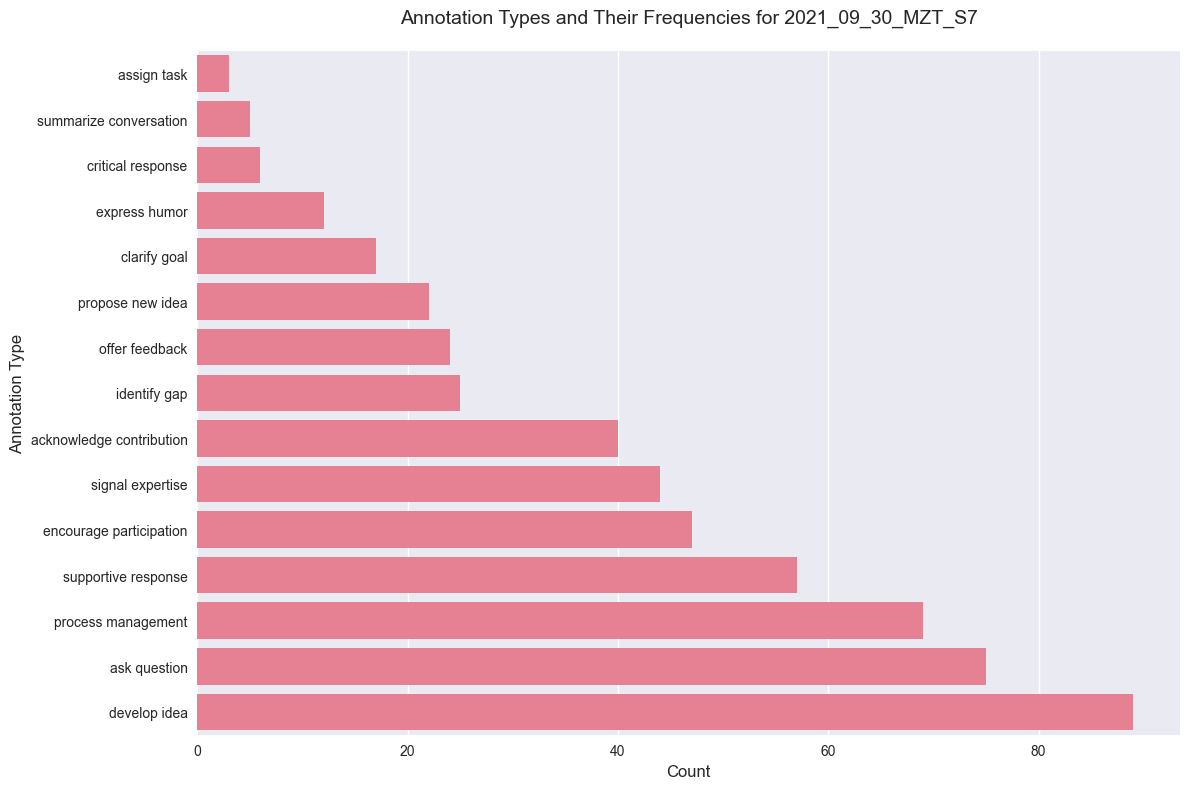

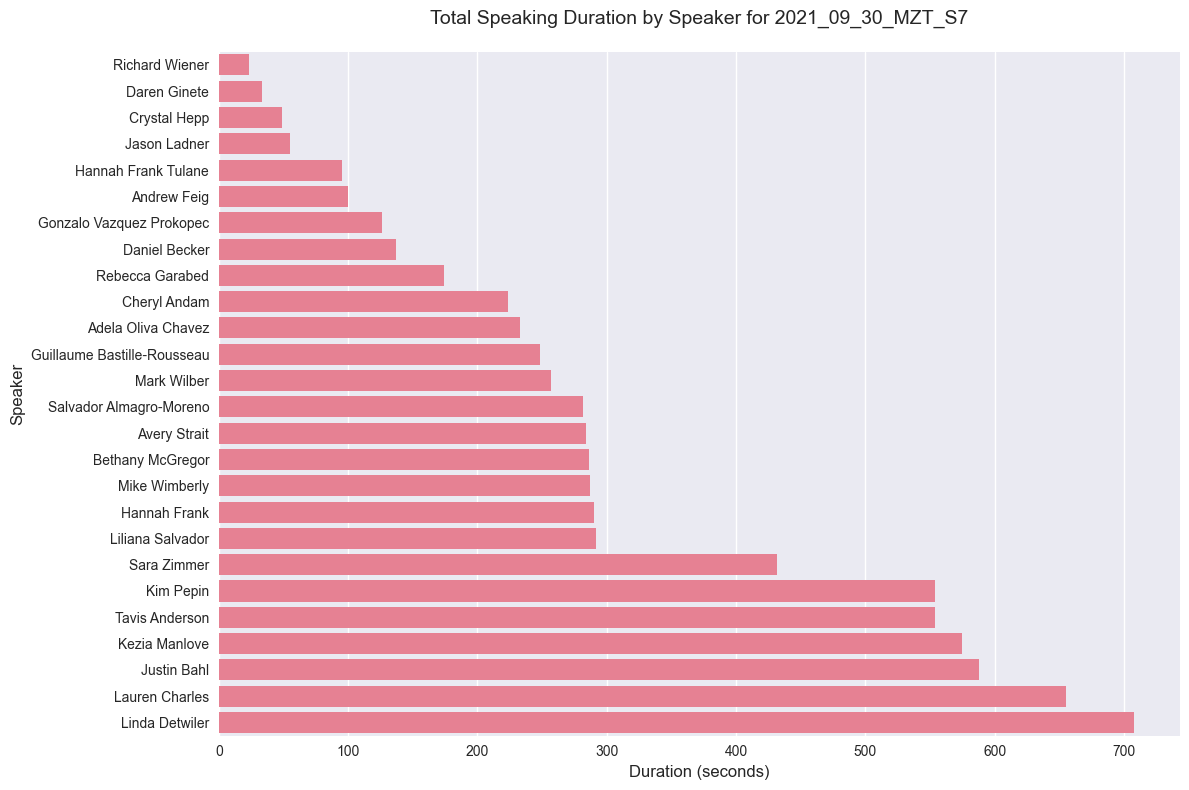

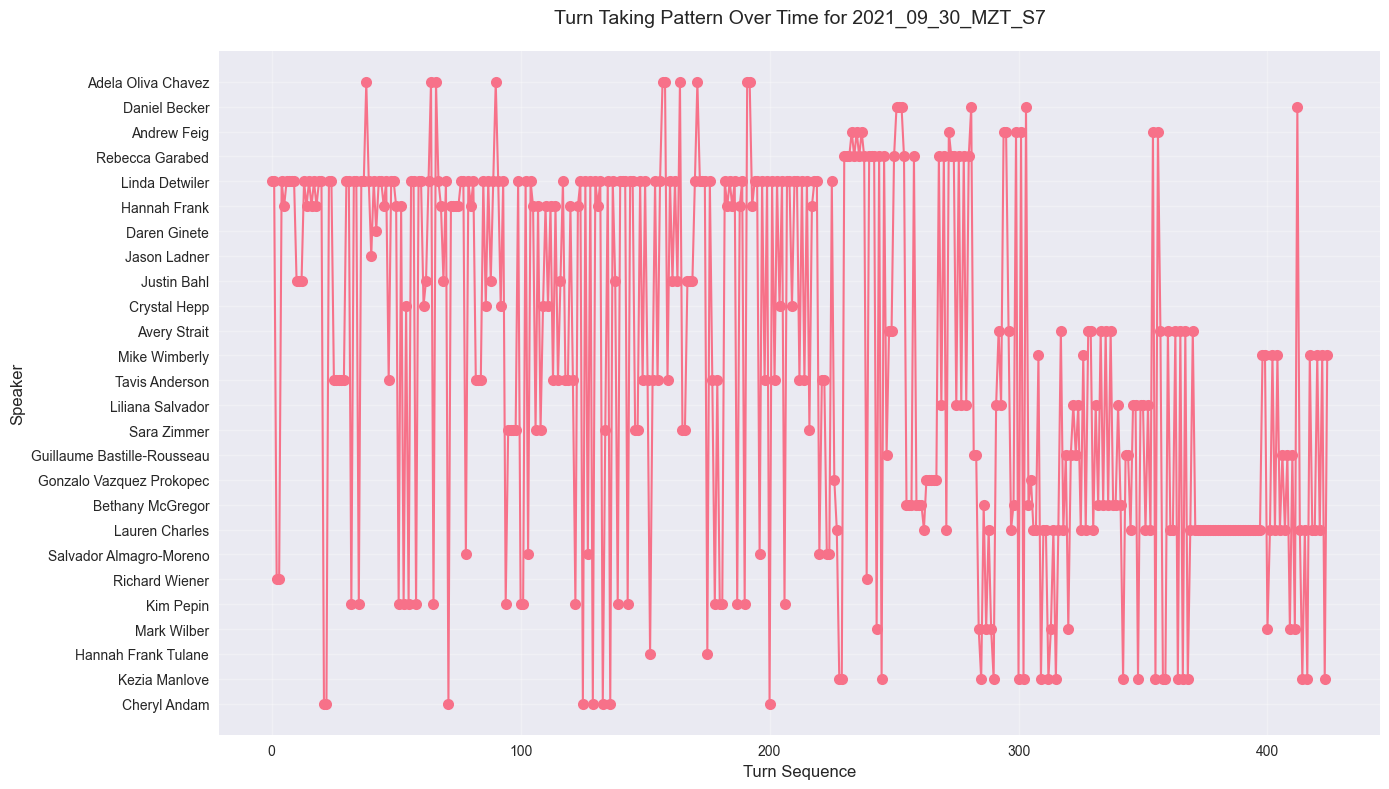

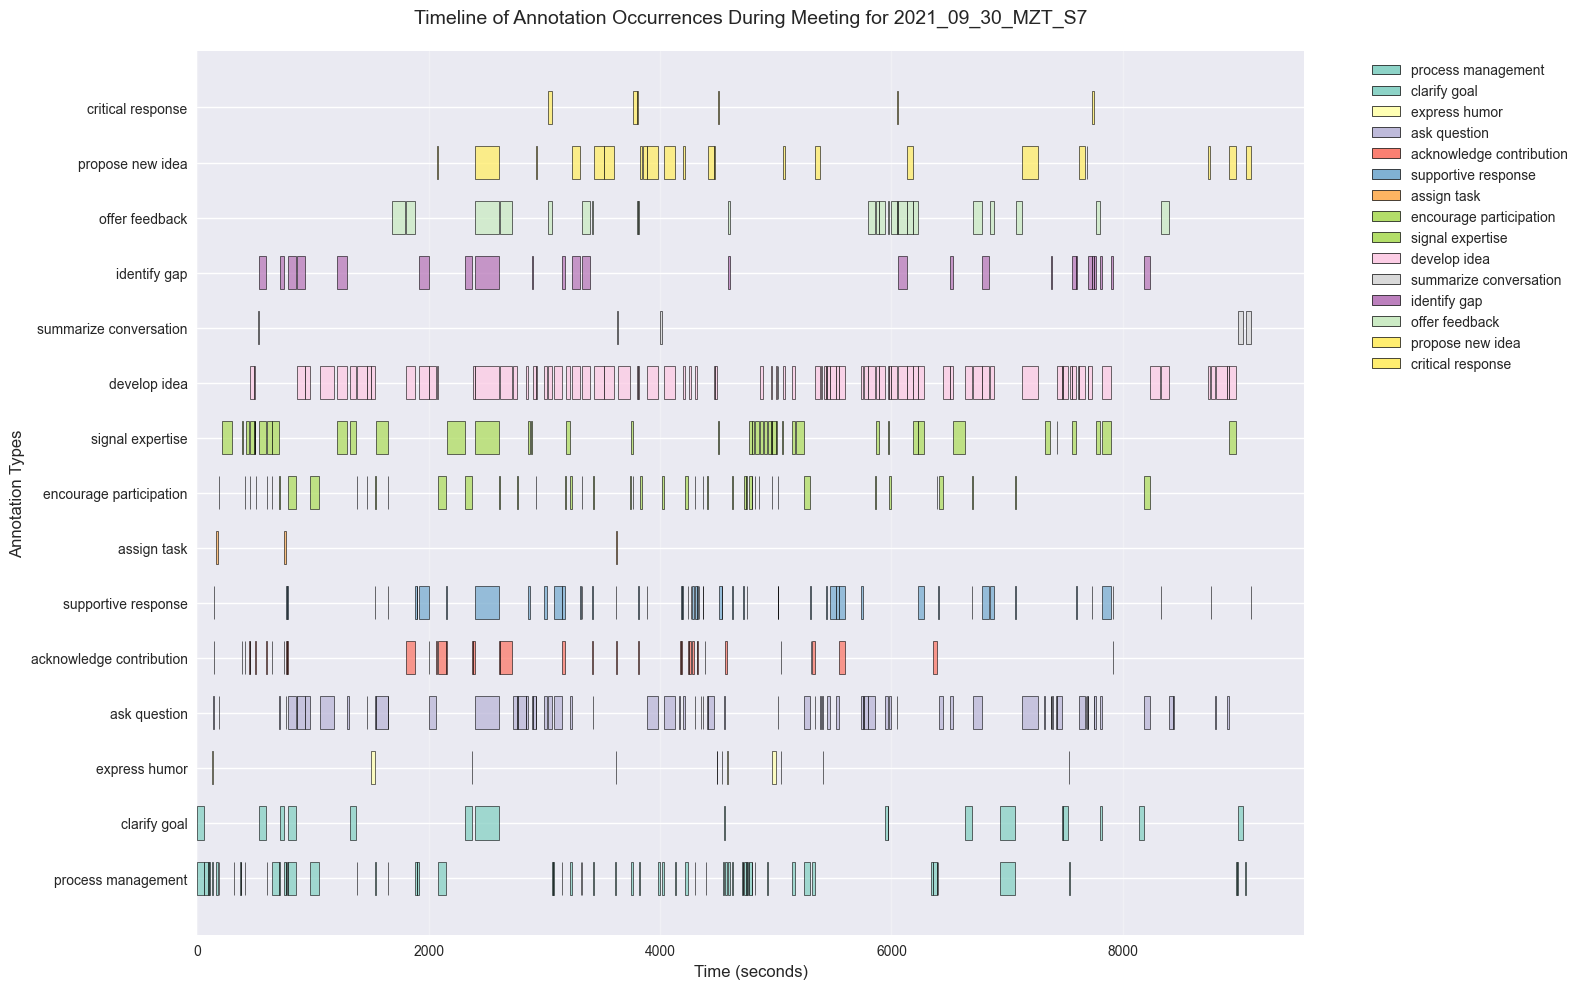

In [ ]:
file_path='/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S7.json'
analyze_meeting(file_path)

2021_09_30_MZT_S7


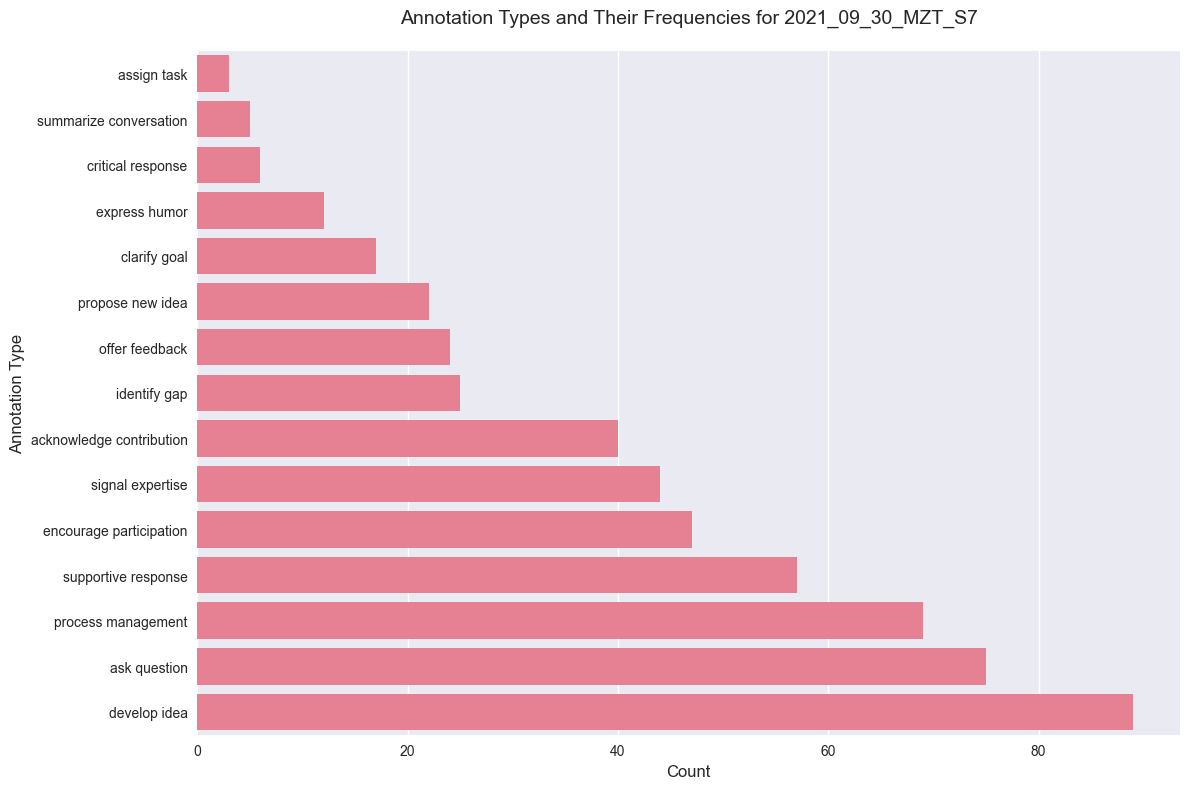

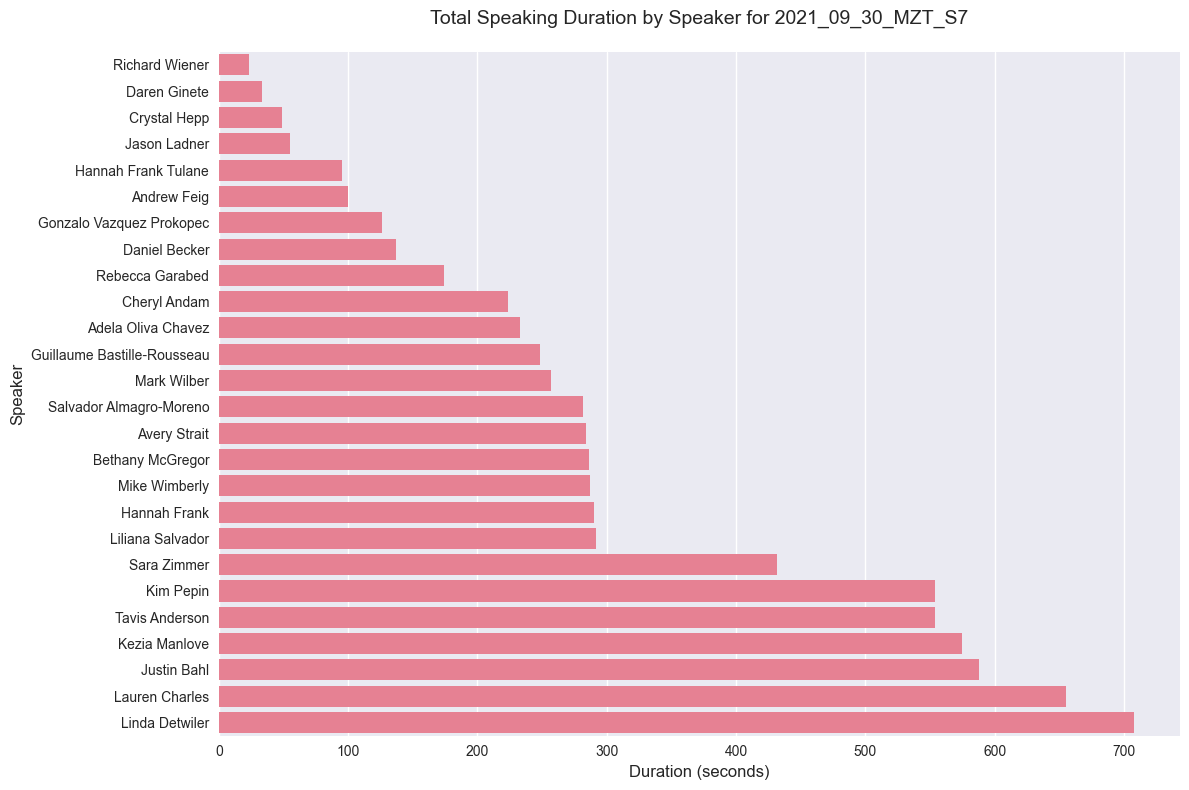

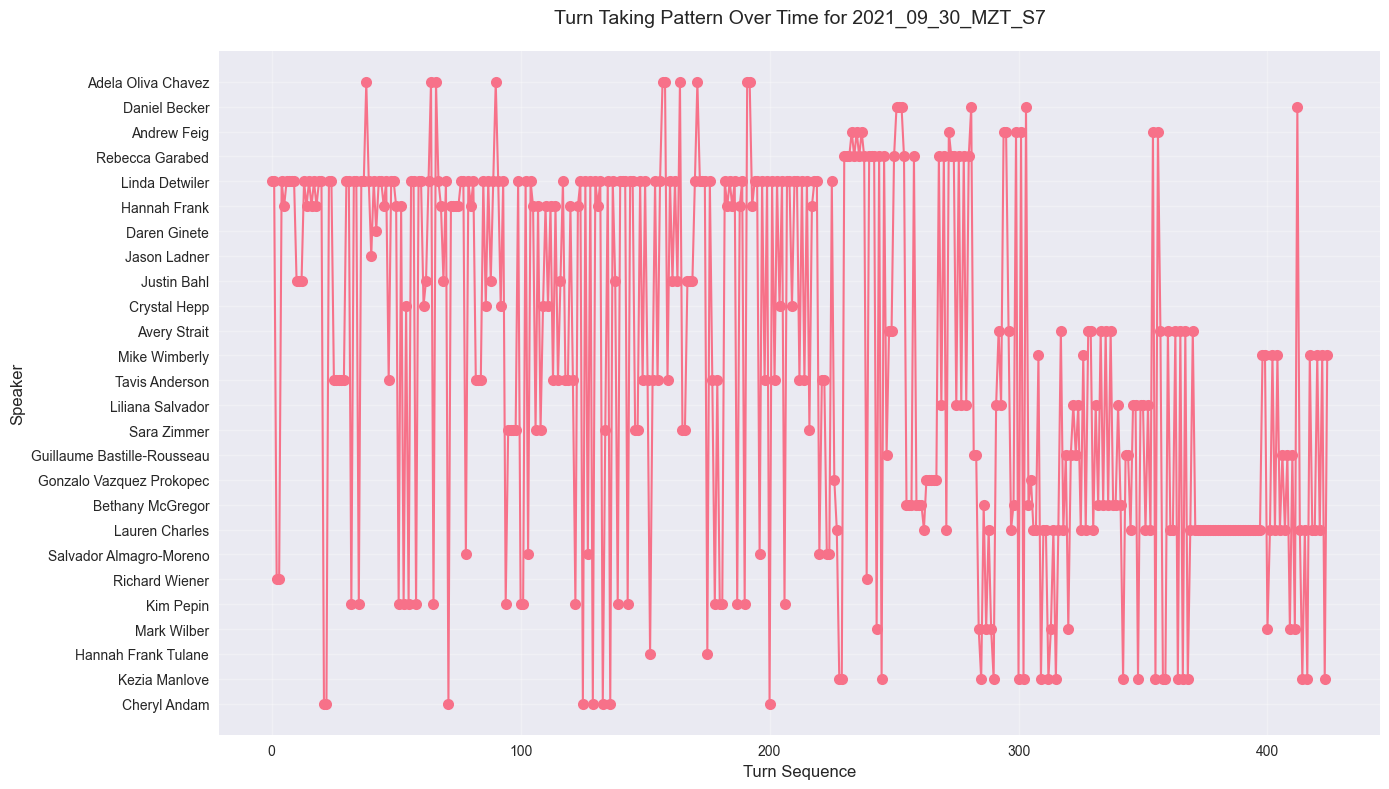

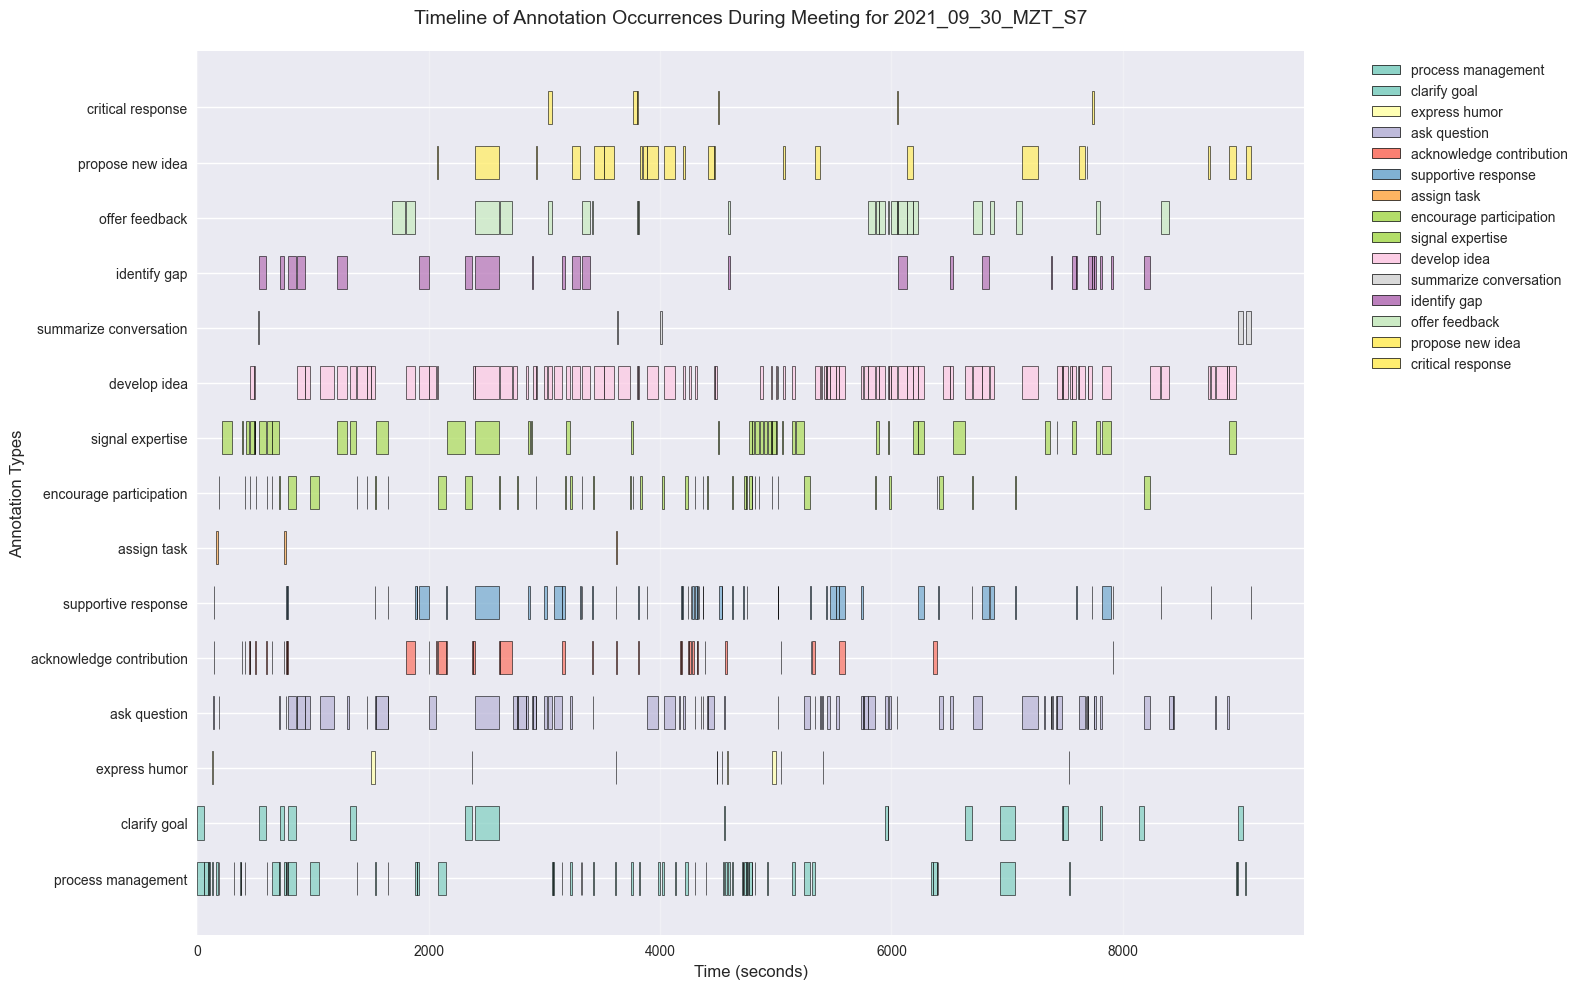

In [ ]:
file_path='/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S7.json'
analyze_meeting(file_path)

In [ ]:
def analyze_feature_importance(model, feature_names, X, y):
    """Analyze feature importance beyond just p-values"""
    
    # Fit the model
    model.fit(X, y)
    
    # Get coefficients
    if hasattr(model, 'coef_'):
        coefficients = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
    else:
        coefficients = model.feature_importances_
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients),
        'effect_size': np.abs(coefficients) / np.std(X, axis=0)  # Standardized effect size
    })
    
    # Sort by absolute coefficient
    importance_df = importance_df.sort_values('abs_coefficient', ascending=False)
    
    # Add practical significance categories
    importance_df['practical_significance'] = pd.cut(
        importance_df['effect_size'], 
        bins=[0, 0.1, 0.3, 0.5, np.inf],
        labels=['Negligible', 'Small', 'Medium', 'Large']
    )
    
    print("Feature Importance Analysis:")
    print("=" * 50)
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    plt.subplot(1, 2, 1)
    plt.barh(range(len(top_features)), top_features['abs_coefficient'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Absolute Coefficient')
    plt.title('Feature Importance (Absolute Coefficients)')
    
    plt.subplot(1, 2, 2)
    plt.barh(range(len(top_features)), top_features['effect_size'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Standardized Effect Size')
    plt.title('Feature Importance (Effect Sizes)')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df